In [3]:
import numpy as np
from sklearn.datasets import fetch_openml
from scipy.fftpack import fft
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tqdm import tqdm
import math

In [4]:
import lib.python.lib_FHRR_Loihi as lib
import lib.python.utility as util
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps

In [2]:
# Load MNIST data
mnist = fetch_openml('mnist_784')
X, y = mnist.data, mnist.target
print(f'Size of the dataset: {len(X)}')

Size of the dataset: 70000


In [3]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Random projection to higher dimensional space
np.random.seed(42)
random_projection_matrix = np.random.randn(784, 1000)
X_train_projected = np.dot(X_train, random_projection_matrix)
X_test_projected = np.dot(X_test, random_projection_matrix)

In [5]:
# Apply FFT to the projected data
X_train_fft = fft(X_train_projected)
X_test_fft = fft(X_test_projected)

In [6]:
def normalize_complex_vectors(vectors):
    """
    Normalize an array of complex vectors.

    Parameters:
    vectors (np.ndarray): An array of complex vectors.

    Returns:
    np.ndarray: An array of normalized complex vectors.
    """
    # Calculate the magnitude (Euclidean norm) of each vector
    magnitudes = np.linalg.norm(vectors, axis=1)

    # Avoid division by zero
    magnitudes[magnitudes == 0] = 1

    # Normalize each vector by its magnitude
    normalized_vectors = vectors / magnitudes[:, np.newaxis]

    return normalized_vectors

# Example usage
complex_vectors = np.array([[1 + 2j, 3 + 4j], [5 + 6j, 7 + 8j]])
normalized_vectors = normalize_complex_vectors(complex_vectors)
print("Normalized Complex Vectors:")
print(normalized_vectors)


Normalized Complex Vectors:
[[0.18257419+0.36514837j 0.54772256+0.73029674j]
 [0.37904902+0.45485883j 0.53066863+0.60647843j]]


In [7]:
# Normalize the complex vectors
X_train_normalized = normalize_complex_vectors(X_train_fft)
X_test_normalized = normalize_complex_vectors(X_test_fft)

In [8]:
X_train_normalized

array([[ 0.03092297-0.j        , -0.03993076-0.00381547j,
        -0.01159966-0.02425549j, ..., -0.00749615+0.01339627j,
        -0.01159966+0.02425549j, -0.03993076+0.00381547j],
       [-0.05065162+0.j        , -0.02231251+0.00846852j,
         0.00335354-0.00520468j, ...,  0.00429344+0.0075598j ,
         0.00335354+0.00520468j, -0.02231251-0.00846852j],
       [-0.01941088+0.j        , -0.00019993+0.00319346j,
        -0.00265312-0.02163137j, ...,  0.00504714-0.00074251j,
        -0.00265312+0.02163137j, -0.00019993-0.00319346j],
       ...,
       [ 0.02137554-0.j        , -0.00899519+0.00061645j,
         0.0097466 -0.01803944j, ..., -0.02140605-0.01537631j,
         0.0097466 +0.01803944j, -0.00899519-0.00061645j],
       [-0.02780032+0.j        , -0.00403469+0.02811587j,
         0.00253468-0.02521861j, ..., -0.04195111+0.01743131j,
         0.00253468+0.02521861j, -0.00403469-0.02811587j],
       [-0.0321835 +0.j        ,  0.00258729+0.02685165j,
        -0.00288961+0.00034421

## K Nearest Neighbour Classification

In [45]:
# Classification using K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_normalized, y_train)
y_pred = knn.predict(X_test_normalized)

ValueError: Complex data not supported
[[ 0.03092297-0.j         -0.03993076-0.00381547j -0.01159966-0.02425549j
  ... -0.00749615+0.01339627j -0.01159966+0.02425549j
  -0.03993076+0.00381547j]
 [-0.05065162+0.j         -0.02231251+0.00846852j  0.00335354-0.00520468j
  ...  0.00429344+0.0075598j   0.00335354+0.00520468j
  -0.02231251-0.00846852j]
 [-0.01941088+0.j         -0.00019993+0.00319346j -0.00265312-0.02163137j
  ...  0.00504714-0.00074251j -0.00265312+0.02163137j
  -0.00019993-0.00319346j]
 ...
 [ 0.02137554-0.j         -0.00899519+0.00061645j  0.0097466 -0.01803944j
  ... -0.02140605-0.01537631j  0.0097466 +0.01803944j
  -0.00899519-0.00061645j]
 [-0.02780032+0.j         -0.00403469+0.02811587j  0.00253468-0.02521861j
  ... -0.04195111+0.01743131j  0.00253468+0.02521861j
  -0.00403469-0.02811587j]
 [-0.0321835 +0.j          0.00258729+0.02685165j -0.00288961+0.00034421j
  ... -0.06544192+0.03447034j -0.00288961-0.00034421j
   0.00258729-0.02685165j]]


In [8]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 97.16%


In [9]:
# Predictions for train and test sets
y_train_pred = knn.predict(X_train_normalized)
y_test_pred = knn.predict(X_test_normalized)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

In [12]:
print("Confusion Matrix for Training Set:")
print(conf_matrix_train)

print("\nConfusion Matrix for Test Set:")
print(conf_matrix_test)

# F1 scores for each digit
f1_scores_train = f1_score(y_train, y_train_pred, average=None)
f1_scores_test = f1_score(y_test, y_test_pred, average=None)

# print("\nF1 Scores for Training Set:")
# for i, score in enumerate(f1_scores_train):
#     print(f"Digit {i}: {score:.2f}")

# print("\nF1 Scores for Test Set:")
# for i, score in enumerate(f1_scores_test):
#     print(f"Digit {i}: {score:.2f}")



# Classification reports
report_train = classification_report(y_train, y_train_pred)
report_test = classification_report(y_test, y_test_pred)

print("Classification Report for Training Set:")
print(report_train)

print("\nClassification Report for Test Set:")
print(report_test)


Confusion Matrix for Training Set:
[[5553    2    1    1    0    0    2    0    0    1]
 [   1 6258    7    0    1    0    3    5    1    1]
 [  26   10 5534    5    2    0    5   20    6    2]
 [   7    7   17 5603    0   21    1   16   24   12]
 [   7   19    3    0 5430    1   12    3    1   53]
 [  19    2    4   36    3 4919   31    0   10   16]
 [   9    8    1    0    2    8 5449    0    3    0]
 [   5   33   13    1    8    1    0 5690    1   38]
 [  13   34    6   28   13   20   10    1 5331   12]
 [  12    8    2   19   17    7    2   22    9 5440]]

Confusion Matrix for Test Set:
[[1333    0    4    0    0    0    2    1    3    0]
 [   0 1591    3    0    1    0    0    4    0    1]
 [  10    9 1337    1    2    0    5    8    6    2]
 [   4    2   13 1371    0   10    1    6   15   11]
 [   2    6    2    0 1247    0    2    2    1   33]
 [   8    2    0   18    2 1216   17    0    6    4]
 [   5    0    0    0    1    4 1385    0    1    0]
 [   3   13    4    2    6    0

In [9]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plotting confusion matrices
plot_confusion_matrix(conf_matrix_train, 'Confusion Matrix for Training Set')
plot_confusion_matrix(conf_matrix_test, 'Confusion Matrix for Test Set')


NameError: name 'conf_matrix_train' is not defined

## Generate Holistic Vectors for each class

In [5]:
from numpy.linalg import norm

In [6]:
X_train_fft = X_train_normalized 
X_test_fft  = X_test_normalized 

NameError: name 'X_train_normalized' is not defined

In [ ]:
# Create an empty array to store the holistic vectors for each class
holistic_vectors = np.zeros((10, X_train_fft.shape[1]), dtype=complex)

# Compute the holistic vector for each class
for i in range(10):
    class_indices = np.where(y_train == str(i))[0]
    holistic_vectors[i] = np.mean(X_train_fft[class_indices], axis=0)

In [12]:
np.where(y_train == str(0))

(array([    3,    19,    58, ..., 55990, 55998, 55999], dtype=int64),)

In [13]:
np.where(y_train == str(0))[0]

array([    3,    19,    58, ..., 55990, 55998, 55999], dtype=int64)

In [3]:
# Function to compute cosine similarity between two complex vectors
def cosine_similarity_complex(vec1, vec2):
    real_dot_product = np.dot(vec1.real, vec2.real) + np.dot(vec1.imag, vec2.imag)
    norm_product = norm(vec1) * norm(vec2)
    return real_dot_product / norm_product if norm_product != 0 else 0

In [15]:
# Classify test vectors
y_test_pred_cosine = []
for test_vec in X_test_fft:
    similarities = [cosine_similarity_complex(test_vec, holistic_vec) for holistic_vec in holistic_vectors]
    predicted_class = np.argmax(similarities)
    y_test_pred_cosine.append(str(predicted_class))

In [16]:
# Calculate accuracy
accuracy_cosine = accuracy_score(y_test, y_test_pred_cosine)
print(f'Accuracy using Cosine Similarity: {accuracy_cosine * 100:.2f}%')

Accuracy using Cosine Similarity: 81.33%


## Lava Vector Encode

Use the test dataset to encode the vectors to spikes and decode them to classify them

In [3]:
# TIME_STEPS = 1000
# lib.GlobalVars.global_threshold = int((TIME_STEPS - 1)/2)
# lib.GlobalVars.time_steps = TIME_STEPS

# for i in range(1,100):
#     lib.GlobalVars.global_threshold = i
#     print(lib.GlobalVars.global_threshold)

In [10]:
def generate_random_normalized_vector(dim):
    real_part = np.random.randn(dim)
    imag_part = np.random.randn(dim)
    vector = real_part + 1j * imag_part
    return vector / np.linalg.norm(vector)

In [11]:
vectt = generate_random_normalized_vector(1000)

In [21]:

v1 = np.array(util.complexarr2phase(vectt))
# v1 = rnd_vectors[0]

In [22]:
encoder  = lib.FHRR_Encoder(vec = vectt)

In [23]:
decoder  = lib.FHRR_Decoder(dimension=v1.shape[0])

In [24]:
encoder.spikes_out.connect(decoder.spikes_a_in)

In [25]:
decoder.run(condition=RunSteps(num_steps=1000), run_cfg=Loihi1SimCfg())

In [26]:
raw_rslt  = decoder.get_decoded_value()
rect_rslt = util.phase2complex_array(raw_rslt)

In [27]:
util.similarity( vectt, rect_rslt  )

0.9946505681574478

In [31]:
# print(v1[:10])
# print(raw_rslt[:10])

In [32]:
# print(rnd_vectors[0][:10])
# print(rect_rslt[:10])

# Dim vs Sim Time

In [33]:
# Define ranges for dimensions and TIME_STEPS
dimensions = range(100, 5000, 500)
time_steps_range = range(100, 1001, 100)

print(f'dimensions: {len(dimensions)}')
print(f'time_steps_range: {len(time_steps_range)}')

dimensions: 10
time_steps_range: 10


In [34]:
# Initialize a dictionary to store similarities
similarities = {}
rnd_vectors = []
snn_vectors = []

# Initialize a matrix to store similarities
similarity_matrix = np.zeros((len(dimensions), len(time_steps_range)))

In [35]:
# Iterate over dimensions and TIME_STEPS with a progress bar
for i, dim in enumerate(tqdm(dimensions, desc='Dimensions')):
    similarities[dim] = []
    for j, TIME_STEPS in enumerate(tqdm(time_steps_range, desc=f'TIME_STEPS for Dim {dim}', leave=False)):
        # Generate a random normalized complex vector
        random_normalized_vector = generate_random_normalized_vector(dim)
        rnd_vectors.append(random_normalized_vector)
        
        # Convert to phase representation, encode, decode, and convert back
        encoder = lib.FHRR_Encoder(vec=random_normalized_vector)
        decoder = lib.FHRR_Decoder(dimension=random_normalized_vector.shape[0])
        encoder.spikes_out.connect(decoder.spikes_a_in)
        decoder.run(condition=RunSteps(num_steps=TIME_STEPS), run_cfg=Loihi1SimCfg())
        raw_rslt = decoder.get_decoded_value()
        rect_rslt = util.phase2complex_array(raw_rslt)

        snn_vectors.append(rect_rslt)
        # Compute similarity
        similarity = util.similarity(rect_rslt, random_normalized_vector)
        
        print(similarity)
        print(rect_rslt[:10])
        print(random_normalized_vector[:10])
        similarities[dim].append(similarity)

        similarity_matrix[i, j] = similarity

TIME_STEPS for Dim 100:  10%|█         | 1/10 [00:01<00:13,  1.51s/it]

0.9637533756670871
[(0.7467529543114478-0.6651015149788224j), (0.7467529543114478-0.6651015149788224j), (0.999999995+9.999999983333334e-05j), (0.10004046639387086+0.9949833692498065j), (-0.5190356253846217-0.85475260723884j), (0.5140231914341965+0.8577762870747847j), (0.999999995+9.999999983333334e-05j), (-0.9090341385007688-0.4167216517534999j), (0.999999995+9.999999983333334e-05j), (0.5233425926926495-0.8521223683683791j)]
[ 0.01269278-0.00917115j  0.02414411-0.01027815j  0.09877259+0.08994824j
  0.00646557+0.09822948j -0.01538173-0.02984537j  0.02320463+0.04042908j
  0.12984017+0.20222417j -0.05038655-0.02390105j  0.10753891+0.04093067j
  0.04093752-0.05012914j]



TIME_STEPS for Dim 100:  20%|██        | 2/10 [00:03<00:12,  1.57s/it]

0.9915543547413185
[(0.9207365363804042-0.39018486717736317j), (0.5140231914341965+0.8577762870747847j), (0.7588701679614305+0.6512419428892693j), (0.8132283436161958+0.5819447234396568j), (0.9207365363804042-0.39018486717736317j), (0.28366218546322625-0.9589242746631385j), (0.04949555009741456-0.9987743441441387j), (0.8512223899816774+0.5248051474536822j), (-0.15274137361439757+0.9882661953069056j), (0.6144632264484674+0.7889454628442574j)]
[ 0.04647787-0.00559798j  0.04136701+0.07002452j  0.11046375+0.09671339j
  0.04595519+0.0331844j   0.10059407-0.03886442j  0.04288907-0.10848403j
  0.01179828-0.10451168j  0.08049599+0.05019061j -0.01042859+0.0575644j
  0.14257759+0.18844617j]



TIME_STEPS for Dim 100:  30%|███       | 3/10 [00:04<00:11,  1.61s/it]

0.9934054721114353
[(0.8109631195052179+0.5850972729404622j), (0.7467529543114478-0.6651015149788224j), (-0.1825600552208028+0.9831947041343222j), (0.5403023058681398+0.8414709848078965j), (-0.4529041164186286+0.8915592304110037j), (0.7467529543114478-0.6651015149788224j), (-0.8461318632533809-0.532973610967149j), (-0.8011436155469337+0.5984721441039565j), (0.3153223623952687+0.9489846193555862j), (-0.7618958404911819-0.6476995663440231j)]
[ 0.03858495+0.0281993j   0.0315133 -0.01453791j -0.01743389+0.08037803j
  0.06781028+0.10765726j -0.04333043+0.07709285j  0.14223517-0.07618438j
 -0.04649348-0.03434194j -0.1245075 +0.08172867j  0.01671396+0.05295151j
 -0.07459961-0.07490875j]



TIME_STEPS for Dim 100:  40%|████      | 4/10 [00:06<00:09,  1.62s/it]

0.994175124794327
[(-0.9052239194266833+0.4249348840678928j), (0.1995839531068051+0.9798807303250027j), (-0.16616018460355178-0.9860987744909298j), (-0.9799838101673936+0.19907720062779133j), (-0.95981620122199+0.28062939951435684j), (-0.9964561132805041-0.08411429311306796j), (-0.042094457589425385+0.9991136354991118j), (0.7621133212351487+0.6474436543792293j), (0.5233425926926495-0.8521223683683791j), (-0.5285259596126687+0.8489171396641181j)]
[-0.02139929+0.00865517j  0.01663693+0.08758733j -0.0088471 -0.06179455j
 -0.08627766+0.01226482j -0.17684664+0.03640362j -0.05656986-0.00518509j
 -0.00522103+0.08438319j  0.01722022+0.0147611j   0.10763983-0.10910414j
 -0.02776812+0.04235992j]



TIME_STEPS for Dim 100:  50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

0.9924725897295334
[(-0.8378355048012958+0.5459227664188021j), (0.28366218546322625-0.9589242746631385j), (0.04949555009741456-0.9987743441441387j), (-0.993813698804694+0.11106003812412972j), (-0.993813698804694+0.11106003812412972j), (-0.7243947646475003+0.6893853965317895j), (-0.7243947646475003+0.6893853965317895j), (-0.8461318632533809-0.532973610967149j), (-0.4529041164186286+0.8915592304110037j), (-0.9998623450816866+0.016591892229347906j)]
[-0.0457989 +0.02796347j  0.01466106-0.02577074j  0.01130506-0.2066985j
 -0.0722455 +0.00780748j -0.07817792+0.00352293j -0.03036105+0.02663001j
 -0.12973686+0.12012606j -0.09873638-0.07672773j -0.02805334+0.05226593j
 -0.04188228-0.00023057j]



TIME_STEPS for Dim 100:  60%|██████    | 6/10 [00:09<00:06,  1.58s/it]

0.9950677444285645
[(0.8559151974656445+0.5171162100991873j), (-0.953340145572774-0.30189827233570254j), (0.5797447389500795+0.8147981576192377j), (-0.16616018460355178-0.9860987744909298j), (0.9207365363804042-0.39018486717736317j), (0.5870419787426026+0.8095564928984077j), (-0.9799838101673936+0.19907720062779133j), (0.10004046639387086+0.9949833692498065j), (0.04949555009741456-0.9987743441441387j), (0.42089585752825376+0.9071089665059848j)]
[ 0.11585302+0.07001848j -0.09006132-0.03483147j  0.09180472+0.13065191j
 -0.00756998-0.10308354j  0.08200798-0.01288173j  0.09534432+0.1325111j
 -0.15634182+0.02634195j  0.01050173+0.10551379j  0.00783302-0.04071932j
  0.03891821+0.08646735j]



TIME_STEPS for Dim 100:  70%|███████   | 7/10 [00:11<00:04,  1.63s/it]

0.9955255419255781
[(0.04949555009741456-0.9987743441441387j), (-0.9964561132805041-0.08411429311306796j), (0.9207365363804042-0.39018486717736317j), (0.9207365363804042-0.39018486717736317j), (0.999999995+9.999999983333334e-05j), (-0.5190356253846217-0.85475260723884j), (-0.953340145572774-0.30189827233570254j), (-0.35654094875525416-0.9342796968042831j), (-0.16616018460355178-0.9860987744909298j), (-0.4903898319782835+0.8715031914412654j)]
[ 9.85718667e-03-0.0349873j  -2.56236807e-02-0.00293068j
  1.53029454e-01-0.02308387j  3.53779079e-02-0.01126769j
  8.91406851e-02+0.00987117j -2.27389012e-02-0.04646957j
 -6.29273944e-02-0.02182722j -3.24673557e-02-0.10376883j
  7.20825471e-06-0.01505257j -4.17813719e-02+0.06977742j]



TIME_STEPS for Dim 100:  80%|████████  | 8/10 [00:12<00:03,  1.67s/it]

0.9944674420365868
[(0.9085340177272306+0.4178108885996345j), (0.07817915528244454+0.9969393259769239j), (-0.6851321243741246+0.7284188164446324j), (0.9207365363804042-0.39018486717736317j), (0.6078619028434016+0.7940427614880694j), (-0.9345461343110483+0.3558419914010657j), (-0.8378355048012958+0.5459227664188021j), (-0.9345461343110483+0.3558419914010657j), (0.5233425926926495-0.8521223683683791j), (-0.35654094875525416-0.9342796968042831j)]
[ 0.06015739+0.02779407j  0.01063101+0.18682809j -0.06016219+0.05994682j
  0.0215539 -0.00112007j  0.02839153+0.03760636j -0.13378881+0.04355818j
 -0.07367815+0.04587198j -0.09501931+0.03310923j  0.0470628 -0.05406065j
 -0.01681994-0.0845532j ]



TIME_STEPS for Dim 100:  90%|█████████ | 9/10 [00:14<00:01,  1.68s/it]

0.9932005755256011
[(-0.016504511113083493+0.9998637912800513j), (-0.5190356253846217-0.85475260723884j), (0.28366218546322625-0.9589242746631385j), (0.5233425926926495-0.8521223683683791j), (0.04949555009741456-0.9987743441441387j), (-0.9964561132805041-0.08411429311306796j), (0.9130203962482237+0.4079139076260289j), (-0.6536436208636119-0.7568024953079282j), (-0.981674004711079-0.19056796287548539j), (0.5233425926926495-0.8521223683683791j)]
[-0.001569  +0.07972434j -0.06129479-0.11747942j  0.03117204-0.10342713j
  0.08658608-0.08736405j  0.00940792-0.05328813j -0.00820742-0.00138785j
  0.06175974+0.02764257j -0.03450815-0.04470988j -0.07282502-0.02262718j
  0.07674806-0.09837595j]



Dimensions:  10%|█         | 1/10 [00:16<02:28, 16.49s/it]             

0.9965364080690331
[(0.5233425926926495-0.8521223683683791j), (0.28366218546322625-0.9589242746631385j), (-0.5190356253846217-0.85475260723884j), (-0.9799838101673936+0.19907720062779133j), (-0.5672120640663181+0.8235717785218403j), (-0.6063209223738354+0.7952200570230491j), (-0.35654094875525416-0.9342796968042831j), (0.9792475210564969+0.20266793654820095j), (0.04949555009741456-0.9987743441441387j), (-0.8461318632533809-0.532973610967149j)]
[ 0.09857047-0.10003455j  0.00931176-0.02817944j -0.0316892 -0.05541061j
 -0.08618211+0.01461629j -0.0990566 +0.13340371j -0.0749096 +0.08904517j
 -0.0146835 -0.06791188j  0.05187207+0.01073793j  0.0144207 -0.13072441j
 -0.04784816-0.03344027j]



TIME_STEPS for Dim 600:  10%|█         | 1/10 [00:01<00:13,  1.47s/it]

0.9715392229811944
[(0.5230181084730104+0.8523215697196184j), (0.28366218546322625-0.9589242746631385j), (0.9207365363804042-0.39018486717736317j), (-0.95981620122199+0.28062939951435684j), (0.28366218546322625-0.9589242746631385j), (0.7467529543114478-0.6651015149788224j), (0.9207365363804042-0.39018486717736317j), (0.999999995+9.999999983333334e-05j), (0.7467529543114478-0.6651015149788224j), (0.25225204013212676+0.9676615670001469j)]
[ 0.00531085+0.00889809j  0.01889178-0.03210996j  0.01484793-0.00521011j
 -0.03725121+0.01002619j  0.01128411-0.01947651j  0.03657106-0.02947402j
  0.06550761-0.02699602j  0.06034149+0.0245223j   0.01895207-0.00986696j
  0.0033168 +0.01406816j]



TIME_STEPS for Dim 600:  20%|██        | 2/10 [00:02<00:11,  1.49s/it]

0.991551429984953
[(-0.7243947646475003+0.6893853965317895j), (-0.5190356253846217-0.85475260723884j), (0.999999995+9.999999983333334e-05j), (-0.953340145572774-0.30189827233570254j), (0.5233425926926495-0.8521223683683791j), (-0.6063209223738354+0.7952200570230491j), (0.837538075077588+0.5463789644517151j), (0.04949555009741456-0.9987743441441387j), (0.999999995+9.999999983333334e-05j), (0.8543756797391656+0.5196558456038369j)]
[-0.0155022 +1.35368211e-02j -0.01115789-2.21486755e-02j
  0.00552866+6.32175702e-06j -0.06360082-2.44156103e-02j
  0.03806964-3.95733626e-02j -0.01349041+1.67698928e-02j
  0.02253216+1.49085959e-02j  0.02044085-7.35744280e-02j
  0.02887029+1.10033971e-02j  0.03784866+2.33287730e-02j]



TIME_STEPS for Dim 600:  30%|███       | 3/10 [00:04<00:10,  1.57s/it]

0.9944788317974087
[(0.8687444924992417+0.4952605443120167j), (-0.5190356253846217-0.85475260723884j), (0.9207365363804042-0.39018486717736317j), (0.999999995+9.999999983333334e-05j), (0.04949555009741456-0.9987743441441387j), (0.9207365363804042-0.39018486717736317j), (-0.7243947646475003+0.6893853965317895j), (-0.9799838101673936+0.19907720062779133j), (-0.4529041164186286+0.8915592304110037j), (0.7100338835660797+0.7041675114545337j)]
[ 0.01953405+0.01124246j -0.01567428-0.02751197j  0.05129096-0.01718518j
  0.03445934+0.00510873j  0.0012959 -0.02578408j  0.02430425-0.0065809j
 -0.01414987+0.01276545j -0.03042402+0.00444497j -0.00766952+0.01426746j
  0.06285434+0.06276613j]



TIME_STEPS for Dim 600:  40%|████      | 4/10 [00:06<00:09,  1.61s/it]

0.9942977770486061
[(0.8799451923395468+0.4750752134962611j), (-0.953340145572774-0.30189827233570254j), (-0.9964561132805041-0.08411429311306796j), (0.008296231623858378+0.9999655856782489j), (-0.5190356253846217-0.85475260723884j), (0.9207365363804042-0.39018486717736317j), (-0.5190356253846217-0.85475260723884j), (-0.7618958404911819-0.6476995663440231j), (-0.9052239194266833+0.4249348840678928j), (-0.8727378164983598+0.4881892088664755j)]
[ 0.03071438+0.01676424j -0.02181122-0.00949121j -0.04239414-0.00381234j
 -0.00018566+0.02983767j -0.01490491-0.03703721j  0.05732857-0.01253597j
 -0.01011659-0.02606045j -0.01695156-0.01629946j -0.02823279+0.01127977j
 -0.02280832+0.01081774j]



TIME_STEPS for Dim 600:  50%|█████     | 5/10 [00:07<00:08,  1.63s/it]

0.9944848385540662
[(-0.8727378164983598+0.4881892088664755j), (-0.016504511113083493+0.9998637912800513j), (0.999999995+9.999999983333334e-05j), (-0.993813698804694+0.11106003812412972j), (-0.5190356253846217-0.85475260723884j), (-0.5672120640663181+0.8235717785218403j), (-0.8727378164983598+0.4881892088664755j), (-0.6456933542311118+0.763596812658209j), (-0.7618958404911819-0.6476995663440231j), (-0.5285259596126687+0.8489171396641181j)]
[-0.00442843+0.00240648j -0.0008477 +0.04007546j  0.04449404+0.00486011j
 -0.07037028+0.00140852j -0.0146002 -0.03019034j -0.02561   +0.03594214j
 -0.05333772+0.02697242j -0.01414717+0.0162031j  -0.02480311-0.02348336j
 -0.00806526+0.01180907j]



TIME_STEPS for Dim 600:  60%|██████    | 6/10 [00:09<00:06,  1.61s/it]

0.9945570195994136
[(-0.5190356253846217-0.85475260723884j), (0.28366218546322625-0.9589242746631385j), (0.5797447389500795+0.8147981576192377j), (-0.5285259596126687+0.8489171396641181j), (0.05561610016580674+0.9984522269003895j), (0.5233425926926495-0.8521223683683791j), (-0.7243947646475003+0.6893853965317895j), (-0.35654094875525416-0.9342796968042831j), (0.28366218546322625-0.9589242746631385j), (0.28366218546322625-0.9589242746631385j)]
[-0.01015774-0.01707727j  0.02836896-0.06215739j  0.01927874+0.02755808j
 -0.01898892+0.03013616j  0.00155461+0.03092975j  0.0388124 -0.03608294j
 -0.01262702+0.01168535j -0.006386  -0.03692905j  0.01248704-0.0280014j
  0.01194453-0.02795808j]



TIME_STEPS for Dim 600:  70%|███████   | 7/10 [00:11<00:05,  1.70s/it]

0.9952266844097983
[(-0.8461318632533809-0.532973610967149j), (-0.95981620122199+0.28062939951435684j), (0.9207365363804042-0.39018486717736317j), (-0.3801773040989977+0.9249136270203928j), (-0.8378355048012958+0.5459227664188021j), (0.999999995+9.999999983333334e-05j), (0.8338250916881907+0.5520287279401139j), (-0.5190356253846217-0.85475260723884j), (-0.16616018460355178-0.9860987744909298j), (0.4545751960981932+0.8907083647818118j)]
[-0.01973845-0.01466963j -0.03966971+0.01141449j  0.04700236-0.01847205j
 -0.0311816 +0.06929527j -0.04826475+0.02885975j  0.05693935+0.0001054j
  0.03323709+0.02210305j -0.01504093-0.02820344j -0.00731881-0.04733153j
  0.01196192+0.02380795j]



TIME_STEPS for Dim 600:  80%|████████  | 8/10 [00:13<00:03,  1.78s/it]

0.9946554272694523
[(-0.6063209223738354+0.7952200570230491j), (-0.6851321243741246+0.7284188164446324j), (-0.95981620122199+0.28062939951435684j), (-0.12380048697021406+0.9923071295853607j), (0.032329154083361726+0.9994772762780824j), (0.8739067095531404+0.48609367718373275j), (0.7467529543114478-0.6651015149788224j), (0.5233425926926495-0.8521223683683791j), (0.04949555009741456-0.9987743441441387j), (0.28366218546322625-0.9589242746631385j)]
[-0.0265656 +0.03177237j -0.02544021+0.0254584j  -0.02180645+0.00513427j
 -0.00472546+0.03384827j  0.00088429+0.02978862j  0.01993566+0.01113551j
  0.03241157-0.01608657j  0.02536651-0.02603085j  0.00457811-0.02795516j
  0.01344817-0.02220125j]



TIME_STEPS for Dim 600:  90%|█████████ | 9/10 [00:15<00:01,  1.78s/it]

0.9954450694497962
[(0.14174589725634046+0.9899030763721239j), (0.04949555009741456-0.9987743441441387j), (-0.27736991252352794+0.9607632026814362j), (-0.3801773040989977+0.9249136270203928j), (-0.8727378164983598+0.4881892088664755j), (-0.953340145572774-0.30189827233570254j), (0.9137361079693227+0.40630816505833883j), (-0.35654094875525416-0.9342796968042831j), (-0.981674004711079-0.19056796287548539j), (0.28366218546322625-0.9589242746631385j)]
[ 0.00402473+0.03027849j  0.0012611 -0.01868168j -0.00600743+0.01887261j
 -0.00816078+0.01958323j -0.05287537+0.02774464j -0.04796068-0.01996477j
  0.02382922+0.01061825j -0.00631219-0.03552303j -0.05555335-0.01581196j
  0.00366345-0.00841179j]



Dimensions:  20%|██        | 2/10 [00:34<02:17, 17.21s/it]             

0.9944917678084217
[(-0.5190356253846217-0.85475260723884j), (0.7652925021148411+0.6436826750867277j), (0.28366218546322625-0.9589242746631385j), (-0.9052239194266833+0.4249348840678928j), (-0.2132672753837673+0.9769938941725196j), (0.5233425926926495-0.8521223683683791j), (-0.5190356253846217-0.85475260723884j), (-0.34503924378889006+0.9385882591667077j), (-0.35654094875525416-0.9342796968042831j), (0.5233425926926495-0.8521223683683791j)]
[-0.02530938-0.06283744j  0.00253702+0.00214549j  0.011555  -0.03850002j
 -0.06311405+0.02709397j -0.00787923+0.03326185j  0.00910262-0.00860327j
 -0.0154833 -0.0322292j  -0.00864096+0.02142367j -0.01365213-0.04337932j
  0.01776729-0.02834084j]



TIME_STEPS for Dim 1100:  10%|█         | 1/10 [00:01<00:14,  1.58s/it]

0.9670070108412822
[(0.5233425926926495-0.8521223683683791j), (0.28366218546322625-0.9589242746631385j), (0.37121774967833887+0.9285458428767802j), (-0.34503924378889006+0.9385882591667077j), (0.999999995+9.999999983333334e-05j), (0.7467529543114478-0.6651015149788224j), (-0.7618958404911819-0.6476995663440231j), (0.999999995+9.999999983333334e-05j), (-0.9799838101673936+0.19907720062779133j), (-0.5190356253846217-0.85475260723884j)]
[ 0.01464893-0.01756659j  0.01125609-0.02756044j  0.01088411+0.02894612j
 -0.00405258+0.0089058j   0.00735566+0.00795798j  0.03588675-0.03083673j
 -0.04471229-0.04843049j  0.02599876+0.0152039j  -0.01903208+0.00298502j
 -0.01727574-0.04388351j]



TIME_STEPS for Dim 1100:  20%|██        | 2/10 [00:03<00:12,  1.60s/it]

0.9916758754320968
[(0.999999995+9.999999983333334e-05j), (-0.5190356253846217-0.85475260723884j), (-0.9998623450816866+0.016591892229347906j), (0.7467529543114478-0.6651015149788224j), (-0.4903898319782835+0.8715031914412654j), (0.21768794244665535+0.9760184218104399j), (0.9207365363804042-0.39018486717736317j), (0.3153223623952687+0.9489846193555862j), (-0.042094457589425385+0.9991136354991118j), (-0.4903898319782835+0.8715031914412654j)]
[ 0.04818468+1.63062517e-02j -0.01313232-2.55857687e-02j
 -0.04161265-2.69558435e-05j  0.02967567-1.32538300e-02j
 -0.01433417+2.38486031e-02j  0.00610101+2.93627769e-02j
  0.00396808-1.97582546e-04j  0.0025157 +7.86200833e-03j
 -0.0004553 +8.18772229e-03j -0.02390524+3.98804840e-02j]



TIME_STEPS for Dim 1100:  30%|███       | 3/10 [00:04<00:11,  1.63s/it]

0.9942833362876885
[(-0.5190356253846217-0.85475260723884j), (0.9994494182244994-0.03317921654755682j), (-0.9345461343110483+0.3558419914010657j), (0.817639731537178+0.5757302054016373j), (0.9994494182244994-0.03317921654755682j), (0.7467529543114478-0.6651015149788224j), (-0.06849426571540826+0.9976515100796004j), (0.28366218546322625-0.9589242746631385j), (-0.35654094875525416-0.9342796968042831j), (-0.9998623450816866+0.016591892229347906j)]
[-0.0325099 -0.05378415j  0.02483922-0.0003242j  -0.03326176+0.01208124j
  0.02577922+0.01838697j  0.00842197-0.00016509j  0.05318086-0.02646364j
 -0.0005211 +0.00758864j  0.00952296-0.02095166j -0.00171072-0.00555963j
 -0.02507012-0.00129697j]



TIME_STEPS for Dim 1100:  40%|████      | 4/10 [00:06<00:09,  1.64s/it]

0.9948593816100649
[(-0.5190356253846217-0.85475260723884j), (0.2687499769545138+0.9632099718581345j), (-0.7618958404911819-0.6476995663440231j), (-0.5672120640663181+0.8235717785218403j), (-0.7618958404911819-0.6476995663440231j), (-0.6063209223738354+0.7952200570230491j), (0.9207365363804042-0.39018486717736317j), (0.9207365363804042-0.39018486717736317j), (-0.9799838101673936+0.19907720062779133j), (-0.16616018460355178-0.9860987744909298j)]
[-0.01042943-0.02001312j  0.00223232+0.00819799j -0.02035492-0.01968186j
 -0.0287496 +0.03922311j -0.00416486-0.0036126j  -0.02775558+0.03312048j
  0.01860691-0.00601462j  0.02906795-0.00659626j -0.03657335+0.00577426j
 -0.00013205-0.00383474j]



TIME_STEPS for Dim 1100:  50%|█████     | 5/10 [00:08<00:08,  1.66s/it]

0.9936528628860697
[(-0.7618958404911819-0.6476995663440231j), (0.7467529543114478-0.6651015149788224j), (0.7467529543114478-0.6651015149788224j), (-0.9964561132805041-0.08411429311306796j), (0.9207365363804042-0.39018486717736317j), (0.7467529543114478-0.6651015149788224j), (0.14174589725634046+0.9899030763721239j), (0.42089585752825376+0.9071089665059848j), (0.8687444924992417+0.4952605443120167j), (0.9403215814112726+0.3402871192569642j)]
[-0.01965883-0.01948511j  0.03210534-0.01476502j  0.0194065 -0.01466294j
 -0.02446779-0.00362661j  0.02287752-0.00286921j  0.01238308-0.00792462j
  0.00712175+0.05436312j  0.00700603+0.01559692j  0.01504914+0.00861368j
  0.0146275 +0.00532531j]



TIME_STEPS for Dim 1100:  60%|██████    | 6/10 [00:09<00:06,  1.65s/it]

0.9948660054691779
[(0.5233425926926495-0.8521223683683791j), (-0.3801773040989977+0.9249136270203928j), (-0.9799838101673936+0.19907720062779133j), (-0.7618958404911819-0.6476995663440231j), (-0.16616018460355178-0.9860987744909298j), (0.5233425926926495-0.8521223683683791j), (-0.9345461343110483+0.3558419914010657j), (-0.9799838101673936+0.19907720062779133j), (0.9207365363804042-0.39018486717736317j), (-0.6851321243741246+0.7284188164446324j)]
[ 0.03666887-0.03594682j -0.01410555+0.03134774j -0.04781824+0.00599373j
 -0.00872535-0.00867927j -0.00030415-0.00218879j  0.01349426-0.02143434j
 -0.0112368 +0.00401424j -0.04517118+0.00831084j  0.01841047-0.00343075j
 -0.03231768+0.03405888j]



TIME_STEPS for Dim 1100:  70%|███████   | 7/10 [00:11<00:05,  1.68s/it]

0.9949705048432181
[(-0.9345461343110483+0.3558419914010657j), (-0.3801773040989977+0.9249136270203928j), (-0.4161468365471424+0.9092974268256817j), (-0.5190356253846217-0.85475260723884j), (-0.953340145572774-0.30189827233570254j), (-0.7618958404911819-0.6476995663440231j), (0.04949555009741456-0.9987743441441387j), (0.07817915528244454+0.9969393259769239j), (-0.953340145572774-0.30189827233570254j), (-0.016504511113083493+0.9998637912800513j)]
[-0.06414961+0.01906034j -0.00378051+0.00890732j -0.0125071 +0.02494596j
 -0.02037476-0.04029445j -0.01258995-0.00426582j -0.00807359-0.00927303j
  0.0034264 -0.02098008j  0.00146236+0.01937918j -0.02828043-0.00949599j
 -0.0006053 +0.0192982j ]



TIME_STEPS for Dim 1100:  80%|████████  | 8/10 [00:13<00:03,  1.71s/it]

0.9953371569396404
[(-0.34503924378889006+0.9385882591667077j), (0.6271892555745167+0.7788668934367949j), (-0.9998623450816866+0.016591892229347906j), (-0.9998623450816866+0.016591892229347906j), (-0.6536436208636119-0.7568024953079282j), (0.04949555009741456-0.9987743441441387j), (0.6824608905587893+0.7309221113481956j), (0.9715196635021482+0.2369589488258939j), (0.28366218546322625-0.9589242746631385j), (0.5233425926926495-0.8521223683683791j)]
[-0.00588696+1.53585867e-02j  0.01593862+2.00123817e-02j
 -0.03983973-5.99138355e-04j -0.00566986+6.94133827e-05j
 -0.01045856-1.56006264e-02j  0.00175527-6.94978881e-03j
  0.01937871+2.10136705e-02j  0.04053021+9.91746999e-03j
  0.00824618-1.63027762e-02j  0.04184812-3.72777689e-02j]



TIME_STEPS for Dim 1100:  90%|█████████ | 9/10 [00:15<00:01,  1.72s/it]

0.9952616987970929
[(-0.5672120640663181+0.8235717785218403j), (-0.5190356253846217-0.85475260723884j), (-0.5190356253846217-0.85475260723884j), (0.28366218546322625-0.9589242746631385j), (-0.16616018460355178-0.9860987744909298j), (0.9207365363804042-0.39018486717736317j), (0.37121774967833887+0.9285458428767802j), (0.7467529543114478-0.6651015149788224j), (0.04949555009741456-0.9987743441441387j), (-0.31076343038793947+0.950487290990006j)]
[-0.02340943+0.03312372j -0.01978756-0.03941368j -0.00127769-0.00323953j
  0.00610585-0.01669094j -0.00314127-0.02460164j  0.02265287-0.00288803j
  0.01005477+0.02550604j  0.00242655-0.00174682j  0.00311397-0.01566627j
 -0.01087517+0.03129487j]



Dimensions:  30%|███       | 3/10 [00:52<02:03, 17.58s/it]              

0.9942967835052429
[(0.28366218546322625-0.9589242746631385j), (0.9158312873615967+0.40156326162835226j), (-0.9090341385007688-0.4167216517534999j), (0.9207365363804042-0.39018486717736317j), (-0.981674004711079-0.19056796287548539j), (0.9252489358641427+0.3793605233577574j), (0.9929557415576565+0.11848584433460567j), (0.9911713510726844+0.13258715176347022j), (0.7467529543114478-0.6651015149788224j), (0.999999995+9.999999983333334e-05j)]
[ 0.00768808-0.01794056j  0.00666474+0.00292675j -0.04265027-0.02273446j
  0.05904979-0.00484774j -0.02321361-0.0052981j   0.01423852+0.00585805j
  0.03446864+0.00412289j  0.02924077+0.00391735j  0.01237754-0.01053264j
  0.02730269+0.00166827j]



TIME_STEPS for Dim 1600:  10%|█         | 1/10 [00:01<00:14,  1.64s/it]

0.968536163524405
[(-0.6536436208636119-0.7568024953079282j), (-0.6063209223738354+0.7952200570230491j), (0.42089585752825376+0.9071089665059848j), (0.999999995+9.999999983333334e-05j), (-0.9090341385007688-0.4167216517534999j), (0.032329154083361726+0.9994772762780824j), (-0.31076343038793947+0.950487290990006j), (-0.9998623450816866+0.016591892229347906j), (0.28366218546322625-0.9589242746631385j), (0.999999995+9.999999983333334e-05j)]
[-0.01228094-2.01700476e-02j -0.00468703+5.84495489e-03j
  0.00983293+2.23843324e-02j  0.00853079+3.25831687e-03j
 -0.00384434-1.79673168e-03j  0.00014346+1.94076724e-02j
 -0.00684362+1.85916770e-02j -0.02778468-3.19771292e-05j
  0.01594077-2.84753127e-02j  0.01555676+1.77974048e-02j]



TIME_STEPS for Dim 1600:  20%|██        | 2/10 [00:03<00:12,  1.57s/it]

0.9923429287885019
[(0.7467529543114478-0.6651015149788224j), (-0.06849426571540826+0.9976515100796004j), (0.7467529543114478-0.6651015149788224j), (-0.9964561132805041-0.08411429311306796j), (0.04949555009741456-0.9987743441441387j), (-0.6536436208636119-0.7568024953079282j), (-0.016504511113083493+0.9998637912800513j), (0.1809058673577943+0.9835004154323089j), (0.7467529543114478-0.6651015149788224j), (0.999999995+9.999999983333334e-05j)]
[ 0.01814553-0.01472644j -0.00214813+0.02615763j  0.03320243-0.01439129j
 -0.02522829-0.00228178j  0.00149864-0.01151126j -0.01252698-0.01624723j
 -0.00029851+0.01452451j  0.00324608+0.01968248j  0.04936261-0.02628263j
  0.03939226+0.00331617j]



TIME_STEPS for Dim 1600:  30%|███       | 3/10 [00:04<00:11,  1.61s/it]

0.9938001137922086
[(0.04949555009741456-0.9987743441441387j), (0.04949555009741456-0.9987743441441387j), (0.7467529543114478-0.6651015149788224j), (-0.9964561132805041-0.08411429311306796j), (-0.9964561132805041-0.08411429311306796j), (-0.4903898319782835+0.8715031914412654j), (0.47549577709062063+0.8797180036630982j), (0.28366218546322625-0.9589242746631385j), (0.28366218546322625-0.9589242746631385j), (0.04949555009741456-0.9987743441441387j)]
[ 0.00210851-0.01036142j  0.00280289-0.01089236j  0.02873292-0.01663j
 -0.00660349-0.00101681j -0.04501985-0.00595491j -0.01424499+0.02360932j
  0.01011514+0.01922507j  0.00472906-0.01359804j  0.00537297-0.01503627j
  0.00232094-0.0226416j ]



TIME_STEPS for Dim 1600:  40%|████      | 4/10 [00:06<00:09,  1.63s/it]

0.9952021163662549
[(-0.9998623450816866+0.016591892229347906j), (0.4545751960981932+0.8907083647818118j), (-0.953340145572774-0.30189827233570254j), (-0.9799838101673936+0.19907720062779133j), (0.9207365363804042-0.39018486717736317j), (-0.6536436208636119-0.7568024953079282j), (0.4545751960981932+0.8907083647818118j), (0.6967067093471654+0.7173560908995228j), (-0.3801773040989977+0.9249136270203928j), (-0.953340145572774-0.30189827233570254j)]
[-0.01649359-0.00045476j  0.01652176+0.03325805j -0.02750733-0.01178564j
 -0.02888089+0.00440249j  0.01258842-0.00304178j -0.02650751-0.03218153j
  0.01600263+0.03204045j  0.02444581+0.0254486j  -0.00812636+0.01934895j
 -0.03512338-0.01413426j]



TIME_STEPS for Dim 1600:  50%|█████     | 5/10 [00:08<00:08,  1.65s/it]

0.9947383598947525
[(-0.9964561132805041-0.08411429311306796j), (-0.1825600552208028+0.9831947041343222j), (-0.9345461343110483+0.3558419914010657j), (0.10004046639387086+0.9949833692498065j), (-0.8727378164983598+0.4881892088664755j), (0.9178514149905888+0.39692414892492234j), (0.04949555009741456-0.9987743441441387j), (-0.9998623450816866+0.016591892229347906j), (0.16163342880813794+0.9868508675031524j), (0.9045263705750485+0.42641768834598087j)]
[-0.02501585-0.00479987j -0.00419242+0.0197179j  -0.0280718 +0.00871966j
  0.0024192 +0.02594316j -0.00501126+0.00279226j  0.00638039+0.00277138j
  0.00575143-0.02009011j -0.0093579 -0.00010111j  0.00477434+0.03012915j
  0.0174821 +0.00824831j]



TIME_STEPS for Dim 1600:  60%|██████    | 6/10 [00:10<00:07,  1.84s/it]

0.9946977588885872
[(-0.7618958404911819-0.6476995663440231j), (0.82189840263017+0.5696341069089657j), (0.9686008482088515+0.24862099036302904j), (-0.8461318632533809-0.532973610967149j), (0.6010948708300845+0.7991776750271269j), (-0.6536436208636119-0.7568024953079282j), (0.3578618092831215+0.9337745581544888j), (-0.35654094875525416-0.9342796968042831j), (0.37121774967833887+0.9285458428767802j), (0.032329154083361726+0.9994772762780824j)]
[-0.01752783-0.01810095j  0.01664925+0.01162582j  0.01899941+0.00489176j
 -0.02648501-0.0176j      0.01601203+0.02157669j -0.01744233-0.02215857j
  0.01165676+0.03084494j -0.00695943-0.02329226j  0.01102842+0.02870056j
  0.00043125+0.01626789j]



TIME_STEPS for Dim 1600:  70%|███████   | 7/10 [00:11<00:05,  1.77s/it]

0.9953518804391162
[(0.7467529543114478-0.6651015149788224j), (-0.9799838101673936+0.19907720062779133j), (-0.16616018460355178-0.9860987744909298j), (-0.8727378164983598+0.4881892088664755j), (0.07817915528244454+0.9969393259769239j), (-0.6456933542311118+0.763596812658209j), (0.9207365363804042-0.39018486717736317j), (0.9474164508276323+0.3200032323292575j), (0.9399092025731213+0.34142450251608947j), (-0.12380048697021406+0.9923071295853607j)]
[ 0.03761459-0.0244906j  -0.00941562+0.00108305j -0.00226114-0.02328303j
 -0.01772677+0.00977779j  0.00168044+0.03007051j -0.02100668+0.02482402j
  0.01853441-0.00238717j  0.0338226 +0.01144011j  0.0243858 +0.00887488j
 -0.00280891+0.01880563j]



TIME_STEPS for Dim 1600:  80%|████████  | 8/10 [00:13<00:03,  1.77s/it]

0.9951116212630694
[(0.28366218546322625-0.9589242746631385j), (0.999999995+9.999999983333334e-05j), (0.7467529543114478-0.6651015149788224j), (0.7467529543114478-0.6651015149788224j), (0.999999995+9.999999983333334e-05j), (0.25225204013212676+0.9676615670001469j), (-0.7631851459912401+0.6461798766120231j), (-0.27736991252352794+0.9607632026814362j), (0.5317751800910392+0.8468855636029834j), (0.16163342880813794+0.9868508675031524j)]
[ 0.00511619-0.01604897j  0.05059071+0.0005637j   0.01887708-0.01431482j
  0.02178191-0.01262077j  0.03924371+0.00379622j  0.00441759+0.01777619j
 -0.01112479+0.00842661j -0.00288984+0.00929326j  0.01223588+0.01970713j
  0.00606645+0.03822744j]



TIME_STEPS for Dim 1600:  90%|█████████ | 9/10 [00:15<00:01,  1.77s/it]

0.9948856628497248
[(-0.5672120640663181+0.8235717785218403j), (-0.9052239194266833+0.4249348840678928j), (0.05561610016580674+0.9984522269003895j), (-0.9090341385007688-0.4167216517534999j), (-0.7243947646475003+0.6893853965317895j), (-0.27736991252352794+0.9607632026814362j), (-0.35654094875525416-0.9342796968042831j), (-0.35654094875525416-0.9342796968042831j), (0.5797447389500795+0.8147981576192377j), (-0.993813698804694+0.11106003812412972j)]
[-0.02079082+0.02884271j -0.00931912+0.00390882j  0.00055895+0.01578258j
 -0.01654861-0.01027279j -0.01065692+0.00905097j -0.00354344+0.0113377j
 -0.00641744-0.01956912j -0.00415512-0.01261975j  0.00627116+0.00886214j
 -0.02426139+0.00089975j]



Dimensions:  40%|████      | 4/10 [01:09<01:44, 17.46s/it]              

0.9947497214379009
[(0.7265039917873152+0.6871622442459252j), (-0.4529041164186286+0.8915592304110037j), (0.817639731537178+0.5757302054016373j), (0.25225204013212676+0.9676615670001469j), (-0.35654094875525416-0.9342796968042831j), (0.7225179918904224+0.6913521182397806j), (-0.95981620122199+0.28062939951435684j), (0.10004046639387086+0.9949833692498065j), (0.5233425926926495-0.8521223683683791j), (-0.15274137361439757+0.9882661953069056j)]
[ 0.02672714+0.02553028j -0.01107042+0.02032827j  0.00239293+0.00168574j
  0.00097388+0.00390155j -0.00934366-0.02490739j  0.02123259+0.02040242j
 -0.01205696+0.00349332j  0.00311956+0.0390093j   0.00435976-0.00599211j
 -0.00504105+0.02858309j]



TIME_STEPS for Dim 2100:  10%|█         | 1/10 [00:01<00:13,  1.50s/it]

0.9677490856529171
[(-0.9052239194266833+0.4249348840678928j), (-0.8378355048012958+0.5459227664188021j), (0.04949555009741456-0.9987743441441387j), (0.999999995+9.999999983333334e-05j), (-0.5190356253846217-0.85475260723884j), (-0.24486988668507892+0.9695559491823237j), (0.4324433208787433+0.9016611193942901j), (0.28366218546322625-0.9589242746631385j), (0.28366218546322625-0.9589242746631385j), (-0.9964561132805041-0.08411429311306796j)]
[-0.00802676+0.0034044j  -0.0055078 +0.00325282j  0.00579501-0.02332658j
  0.02811117+0.02274918j -0.01115931-0.01930842j -0.0127668 +0.04143808j
  0.00736561+0.016051j    0.00478454-0.00829065j  0.01201721-0.02964492j
 -0.01069409-0.00181749j]



TIME_STEPS for Dim 2100:  20%|██        | 2/10 [00:03<00:12,  1.59s/it]

0.9916963408404267
[(-0.8461318632533809-0.532973610967149j), (-0.16616018460355178-0.9860987744909298j), (0.9207365363804042-0.39018486717736317j), (-0.7631851459912401+0.6461798766120231j), (-0.8727378164983598+0.4881892088664755j), (0.999999995+9.999999983333334e-05j), (-0.993813698804694+0.11106003812412972j), (-0.8461318632533809-0.532973610967149j), (0.5233425926926495-0.8521223683683791j), (-0.7618958404911819-0.6476995663440231j)]
[-0.00457675-0.00339737j  0.00024856-0.00954486j  0.02016741-0.00573008j
 -0.00896391+0.00718003j -0.02583611+0.01312293j  0.02163361+0.00833328j
 -0.02623033+0.00186777j -0.01970589-0.01473677j  0.00740535-0.00987893j
 -0.01737293-0.0162688j ]



TIME_STEPS for Dim 2100:  30%|███       | 3/10 [00:04<00:11,  1.65s/it]

0.9938497485204411
[(0.28366218546322625-0.9589242746631385j), (0.7467529543114478-0.6651015149788224j), (-0.1825600552208028+0.9831947041343222j), (0.28366218546322625-0.9589242746631385j), (0.999999995+9.999999983333334e-05j), (-0.7618958404911819-0.6476995663440231j), (-0.042094457589425385+0.9991136354991118j), (0.999999995+9.999999983333334e-05j), (0.999999995+9.999999983333334e-05j), (0.7467529543114478-0.6651015149788224j)]
[ 0.00412226-0.01325926j  0.01249791-0.00810466j -0.00644411+0.03150361j
  0.00945077-0.01760348j  0.02347447+0.00191736j -0.01456416-0.01543844j
 -0.00177787+0.03516569j  0.01600155+0.00452943j  0.02653976+0.00713469j
  0.00421205-0.00365373j]



TIME_STEPS for Dim 2100:  40%|████      | 4/10 [00:06<00:10,  1.67s/it]

0.9948060069188112
[(-0.9090341385007688-0.4167216517534999j), (0.3578618092831215+0.9337745581544888j), (0.7487396392960327+0.6628642037000089j), (-0.4903898319782835+0.8715031914412654j), (0.28366218546322625-0.9589242746631385j), (-0.7631851459912401+0.6461798766120231j), (-0.16616018460355178-0.9860987744909298j), (0.7684093529355933+0.6399586442271897j), (-0.35654094875525416-0.9342796968042831j), (-0.6536436208636119-0.7568024953079282j)]
[-0.0228009 -0.01247884j  0.00034917+0.00092215j  0.02667312+0.02385463j
 -0.00900764+0.01469696j  0.00579152-0.01628467j -0.01090494+0.0083851j
 -0.00099107-0.02457233j  0.01323485+0.01107433j -0.00629788-0.02940341j
 -0.00870202-0.01064582j]



TIME_STEPS for Dim 2100:  50%|█████     | 5/10 [00:08<00:08,  1.66s/it]

0.9950415233189608
[(-0.3801773040989977+0.9249136270203928j), (-0.981674004711079-0.19056796287548539j), (-0.9964561132805041-0.08411429311306796j), (0.9207365363804042-0.39018486717736317j), (-0.35654094875525416-0.9342796968042831j), (0.37121774967833887+0.9285458428767802j), (-0.34503924378889006+0.9385882591667077j), (-0.8461318632533809-0.532973610967149j), (0.5233425926926495-0.8521223683683791j), (-0.6536436208636119-0.7568024953079282j)]
[-0.00365068+0.00886556j -0.03234558-0.0079309j  -0.0144955 -0.00214981j
  0.0229878 -0.00201684j -0.01436234-0.04434616j  0.00759464+0.01923391j
 -0.00539597+0.01403104j -0.02096305-0.01765578j  0.00444559-0.00588781j
 -0.01408094-0.02060926j]



TIME_STEPS for Dim 2100:  60%|██████    | 6/10 [00:09<00:06,  1.65s/it]

0.9948932363066011
[(-0.16616018460355178-0.9860987744909298j), (0.04949555009741456-0.9987743441441387j), (-0.953340145572774-0.30189827233570254j), (-0.16616018460355178-0.9860987744909298j), (0.9228976701384681+0.385045309610424j), (-0.16616018460355178-0.9860987744909298j), (0.7467529543114478-0.6651015149788224j), (-0.7631851459912401+0.6461798766120231j), (-0.5190356253846217-0.85475260723884j), (0.04949555009741456-0.9987743441441387j)]
[-0.00027602-0.00222459j  0.00332599-0.01559467j -0.01539704-0.00492433j
 -0.00183345-0.01141696j  0.01557572+0.00650232j -0.00051235-0.01516012j
  0.01710718-0.01220277j -0.02565659+0.0212546j  -0.0049528 -0.00922211j
  0.00143532-0.00511993j]



TIME_STEPS for Dim 2100:  70%|███████   | 7/10 [00:11<00:05,  1.69s/it]

0.9944581028189242
[(-0.042094457589425385+0.9991136354991118j), (-0.953340145572774-0.30189827233570254j), (0.008296231623858378+0.9999655856782489j), (0.04949555009741456-0.9987743441441387j), (-0.8727378164983598+0.4881892088664755j), (-0.16616018460355178-0.9860987744909298j), (-0.27736991252352794+0.9607632026814362j), (-0.5190356253846217-0.85475260723884j), (-0.3801773040989977+0.9249136270203928j), (-0.3801773040989977+0.9249136270203928j)]
[-0.00073319+0.01446441j -0.01302294-0.00580981j -0.00016974+0.01408059j
  0.00067019-0.00636655j -0.00586548+0.00282464j -0.00233186-0.014604j
 -0.00580691+0.01995116j -0.02397057-0.04197975j -0.01449744+0.0320615j
 -0.00546875+0.01212513j]



TIME_STEPS for Dim 2100:  80%|████████  | 8/10 [00:13<00:03,  1.73s/it]

0.9947814902739083
[(-0.9090341385007688-0.4167216517534999j), (-0.6456933542311118+0.763596812658209j), (0.5233425926926495-0.8521223683683791j), (-0.953340145572774-0.30189827233570254j), (-0.5285259596126687+0.8489171396641181j), (-0.9964561132805041-0.08411429311306796j), (0.7467529543114478-0.6651015149788224j), (-0.9799838101673936+0.19907720062779133j), (0.28366218546322625-0.9589242746631385j), (0.6508681227351676+0.7591908105392207j)]
[-0.01293406-0.00720114j -0.00675345+0.00794484j  0.00838117-0.0108096j
 -0.02124625-0.0077936j  -0.01095137+0.01642521j -0.02421272-0.00281229j
  0.01139393-0.00588961j -0.02185179+0.00351577j  0.01137807-0.02358283j
  0.00602356+0.00707524j]



TIME_STEPS for Dim 2100:  90%|█████████ | 9/10 [00:18<00:02,  2.63s/it]

0.9951102664998427
[(0.34410380265899404+0.9389316125233084j), (-0.6456933542311118+0.763596812658209j), (0.28366218546322625-0.9589242746631385j), (0.7467529543114478-0.6651015149788224j), (-0.9799838101673936+0.19907720062779133j), (-0.993813698804694+0.11106003812412972j), (-0.35654094875525416-0.9342796968042831j), (-0.6536436208636119-0.7568024953079282j), (-0.5190356253846217-0.85475260723884j), (0.3299290592847802+0.9440057287111451j)]
[ 0.00414221+0.01171255j -0.00828014+0.00921459j  0.01209255-0.02723741j
  0.01765394-0.0129375j  -0.00927003+0.00169908j -0.02325713+0.00228222j
 -0.00252689-0.01153412j -0.00953782-0.01440311j -0.00817696-0.01877825j
  0.00366695+0.01080898j]



Dimensions:  50%|█████     | 5/10 [01:30<01:33, 18.71s/it]              

0.9947580644118726
[(-0.16616018460355178-0.9860987744909298j), (-0.8461318632533809-0.532973610967149j), (0.5233425926926495-0.8521223683683791j), (0.5645785415239551+0.8253793494210305j), (0.9100670872842439+0.41446097119267133j), (0.7467529543114478-0.6651015149788224j), (0.5233425926926495-0.8521223683683791j), (-0.8727378164983598+0.4881892088664755j), (0.04949555009741456-0.9987743441441387j), (-0.953340145572774-0.30189827233570254j)]
[-0.00118025-0.02762184j -0.02716144-0.01966459j  0.01766424-0.01844593j
  0.00805934+0.01193237j  0.01851086+0.0084482j   0.02441102-0.0128308j
  0.01846835-0.02075137j -0.02290986+0.01083559j  0.00105365-0.01803964j
 -0.01112184-0.00385666j]



TIME_STEPS for Dim 2600:  10%|█         | 1/10 [00:03<00:28,  3.20s/it]

0.9678007242974529
[(-0.9090341385007688-0.4167216517534999j), (0.28366218546322625-0.9589242746631385j), (0.04949555009741456-0.9987743441441387j), (-0.12380048697021406+0.9923071295853607j), (0.7467529543114478-0.6651015149788224j), (-0.5285259596126687+0.8489171396641181j), (0.999999995+9.999999983333334e-05j), (0.28366218546322625-0.9589242746631385j), (0.999999995+9.999999983333334e-05j), (0.9207365363804042-0.39018486717736317j)]
[-0.00991462-0.00543911j  0.00373843-0.0089616j   0.00391966-0.0142882j
 -0.00486714+0.02702487j  0.02465441-0.01801952j -0.00400052+0.00606346j
  0.02123034+0.01702364j  0.00881887-0.01777403j  0.01495856+0.01881407j
  0.01965182-0.00451628j]



TIME_STEPS for Dim 2600:  20%|██        | 2/10 [00:04<00:18,  2.27s/it]

0.9918611998873362
[(-0.8378355048012958+0.5459227664188021j), (0.6724122440830567+0.7401768531960371j), (-0.993813698804694+0.11106003812412972j), (-0.8011436155469337+0.5984721441039565j), (-0.5285259596126687+0.8489171396641181j), (-0.9090341385007688-0.4167216517534999j), (0.7467529543114478-0.6651015149788224j), (-0.5672120640663181+0.8235717785218403j), (-0.4903898319782835+0.8715031914412654j), (-0.8461318632533809-0.532973610967149j)]
[-0.00938232+0.00605809j  0.00767809+0.00864309j -0.020282  +0.00121136j
 -0.01599674+0.01150196j -0.01062034+0.01665654j -0.00868753-0.0054378j
  0.02707683-0.01463919j -0.00240176+0.00329522j -0.00091464+0.00157045j
 -0.01642987-0.01173729j]



TIME_STEPS for Dim 2600:  30%|███       | 3/10 [00:06<00:13,  1.95s/it]

0.9937063374211611
[(-0.1825600552208028+0.9831947041343222j), (0.5233425926926495-0.8521223683683791j), (0.38418576039005164+0.9232558158568609j), (0.28366218546322625-0.9589242746631385j), (-0.16616018460355178-0.9860987744909298j), (-0.981674004711079-0.19056796287548539j), (-0.6536436208636119-0.7568024953079282j), (-0.16616018460355178-0.9860987744909298j), (-0.9799838101673936+0.19907720062779133j), (-0.06849426571540826+0.9976515100796004j)]
[-0.00385591+0.01973102j  0.01407369-0.02114927j  0.00871392+0.02123582j
  0.00917363-0.02133869j -0.00123955-0.0078079j  -0.0038623 -0.00116417j
 -0.00366829-0.00486623j -0.00196042-0.02761878j -0.02103906+0.00369778j
 -0.00152611+0.01870766j]



TIME_STEPS for Dim 2600:  40%|████      | 4/10 [00:08<00:11,  1.86s/it]

0.994479146817489
[(0.8897798990999795+0.4563898894121456j), (-0.5190356253846217-0.85475260723884j), (-0.2132672753837673+0.9769938941725196j), (0.999999995+9.999999983333334e-05j), (0.04949555009741456-0.9987743441441387j), (-0.7631851459912401+0.6461798766120231j), (-0.981674004711079-0.19056796287548539j), (-0.8011436155469337+0.5984721441039565j), (0.9207365363804042-0.39018486717736317j), (-0.7618958404911819-0.6476995663440231j)]
[ 0.00736415+0.00380855j -0.00608327-0.01366729j -0.00311227+0.01298927j
  0.01860058+0.00411216j  0.00444689-0.03586142j -0.01215037+0.00976158j
 -0.02436537-0.00514856j -0.00903553+0.00598581j  0.01372937-0.00184668j
 -0.01003862-0.00887125j]



TIME_STEPS for Dim 2600:  50%|█████     | 5/10 [00:09<00:09,  1.83s/it]

0.9945186513265375
[(0.2687499769545138+0.9632099718581345j), (0.7467529543114478-0.6651015149788224j), (-0.9964561132805041-0.08411429311306796j), (0.3578618092831215+0.9337745581544888j), (-0.9799838101673936+0.19907720062779133j), (0.5233425926926495-0.8521223683683791j), (0.28366218546322625-0.9589242746631385j), (0.5233425926926495-0.8521223683683791j), (0.28366218546322625-0.9589242746631385j), (0.04949555009741456-0.9987743441441387j)]
[ 0.00217031+0.00786374j  0.00626982-0.00514131j -0.04005972-0.00760388j
  0.00725115+0.0194179j  -0.01867455+0.00266287j  0.00569714-0.00586007j
  0.00685864-0.01291832j  0.0069258 -0.00953365j  0.0074165 -0.01703981j
  0.00255984-0.01131869j]



TIME_STEPS for Dim 2600:  60%|██████    | 6/10 [00:11<00:07,  1.77s/it]

0.9945129644705715
[(-0.7631851459912401+0.6461798766120231j), (-0.16616018460355178-0.9860987744909298j), (0.999999995+9.999999983333334e-05j), (-0.5285259596126687+0.8489171396641181j), (-0.16616018460355178-0.9860987744909298j), (0.04949555009741456-0.9987743441441387j), (-0.993813698804694+0.11106003812412972j), (-0.993813698804694+0.11106003812412972j), (0.04949555009741456-0.9987743441441387j), (0.8356971513047824+0.5491905600982883j)]
[-9.88012200e-03+0.00741113j  5.32412030e-05-0.0224897j
  2.89895922e-02+0.00027574j -7.21394024e-03+0.01066815j
 -4.41511553e-04-0.00652954j  3.63346778e-03-0.0134072j
 -6.60027675e-03+0.00012457j -1.49417886e-02+0.00047124j
  4.18372808e-03-0.01465162j  4.91665941e-03+0.00324685j]



TIME_STEPS for Dim 2600:  70%|███████   | 7/10 [00:13<00:05,  1.73s/it]

0.9951265870732677
[(-0.2132672753837673+0.9769938941725196j), (-0.8461318632533809-0.532973610967149j), (-0.9964561132805041-0.08411429311306796j), (-0.8727378164983598+0.4881892088664755j), (0.23523757330298942+0.9719379013633127j), (0.7467529543114478-0.6651015149788224j), (0.34410380265899404+0.9389316125233084j), (-0.9052239194266833+0.4249348840678928j), (-0.35654094875525416-0.9342796968042831j), (0.04949555009741456-0.9987743441441387j)]
[-0.00152497+0.00653217j -0.01830983-0.01301716j -0.01539747-0.00273984j
 -0.01031441+0.00571769j  0.00650835+0.02855666j  0.00791605-0.0040148j
  0.00532776+0.01473032j -0.01100094+0.0042114j  -0.00252164-0.01168026j
  0.0033741 -0.01961136j]



TIME_STEPS for Dim 2600:  80%|████████  | 8/10 [00:14<00:03,  1.73s/it]

0.9944387449838342
[(0.28366218546322625-0.9589242746631385j), (0.6271892555745167+0.7788668934367949j), (-0.8378355048012958+0.5459227664188021j), (-0.953340145572774-0.30189827233570254j), (-0.5190356253846217-0.85475260723884j), (0.04949555009741456-0.9987743441441387j), (0.04949555009741456-0.9987743441441387j), (-0.6851321243741246+0.7284188164446324j), (0.5403023058681398+0.8414709848078965j), (0.48552756893266696+0.8742213562973249j)]
[ 0.00949789-0.01630012j  0.00321394+0.00403462j -0.00994502+0.00624571j
 -0.00531441-0.00186135j -0.01780792-0.03413037j  0.00640368-0.02400948j
  0.00092033-0.00984465j -0.01336225+0.01373063j  0.00558344+0.00877368j
  0.00622742+0.01145038j]



TIME_STEPS for Dim 2600:  90%|█████████ | 9/10 [00:16<00:01,  1.79s/it]

0.9948861240399949
[(0.032329154083361726+0.9994772762780824j), (-0.4529041164186286+0.8915592304110037j), (-0.9090341385007688-0.4167216517534999j), (-0.35654094875525416-0.9342796968042831j), (-0.9052239194266833+0.4249348840678928j), (-0.5190356253846217-0.85475260723884j), (0.48552756893266696+0.8742213562973249j), (0.9207365363804042-0.39018486717736317j), (-0.993813698804694+0.11106003812412972j), (-0.9052239194266833+0.4249348840678928j)]
[ 0.00021389+0.02038869j -0.00569984+0.01018066j -0.01446645-0.00795543j
 -0.00614684-0.01682903j -0.01086837+0.00480059j -0.00939842-0.02366846j
  0.01276614+0.02303458j  0.02699971-0.00642924j -0.01317467+0.00082509j
 -0.00890753+0.00350159j]



Dimensions:  60%|██████    | 6/10 [01:50<01:16, 19.05s/it]              

0.9950786022883524
[(-0.09572354801437566+0.9954079577517649j), (-0.16616018460355178-0.9860987744909298j), (0.5047822144359468+0.863246729498086j), (0.9207365363804042-0.39018486717736317j), (-0.8461318632533809-0.532973610967149j), (-0.35654094875525416-0.9342796968042831j), (-0.993813698804694+0.11106003812412972j), (-0.953340145572774-0.30189827233570254j), (0.7467529543114478-0.6651015149788224j), (-0.16616018460355178-0.9860987744909298j)]
[-0.0043956 +0.03803187j -0.0014267 -0.00938003j  0.02066531+0.03563506j
  0.01009499-0.00092075j -0.00721276-0.00487797j -0.0072262 -0.01975117j
 -0.02428427+0.00130907j -0.01294715-0.00542375j  0.03794761-0.02222749j
  0.00140574-0.03324898j]



TIME_STEPS for Dim 3100:  10%|█         | 1/10 [00:03<00:28,  3.17s/it]

0.9697345304306646
[(-0.9799838101673936+0.19907720062779133j), (-0.5190356253846217-0.85475260723884j), (-0.981674004711079-0.19056796287548539j), (0.999999995+9.999999983333334e-05j), (-0.8461318632533809-0.532973610967149j), (0.999999995+9.999999983333334e-05j), (0.999999995+9.999999983333334e-05j), (-0.5672120640663181+0.8235717785218403j), (-0.9964561132805041-0.08411429311306796j), (0.28366218546322625-0.9589242746631385j)]
[-0.01009848+0.00183312j -0.00895935-0.0161852j  -0.01654864-0.00500511j
  0.02242022+0.0020595j  -0.01929876-0.01232458j  0.01795031+0.00150229j
  0.01534668+0.01196321j -0.00658729+0.00929941j -0.00870733-0.0009728j
  0.00372121-0.00875668j]



TIME_STEPS for Dim 3100:  20%|██        | 2/10 [00:04<00:18,  2.25s/it]

0.9915798091187659
[(-0.9964561132805041-0.08411429311306796j), (-0.9090341385007688-0.4167216517534999j), (-0.9090341385007688-0.4167216517534999j), (-0.6536436208636119-0.7568024953079282j), (-0.7618958404911819-0.6476995663440231j), (0.9207365363804042-0.39018486717736317j), (-0.9052239194266833+0.4249348840678928j), (0.7467529543114478-0.6651015149788224j), (-0.9964561132805041-0.08411429311306796j), (0.28366218546322625-0.9589242746631385j)]
[-0.028382  -0.00498188j -0.01333529-0.00768404j -0.02221635-0.01166072j
 -0.01323475-0.01664982j -0.0116882 -0.01184675j  0.01993274-0.00123829j
 -0.01656349+0.00637617j  0.01293999-0.00791654j -0.02832361-0.00433546j
  0.00431352-0.0096308j ]



TIME_STEPS for Dim 3100:  30%|███       | 3/10 [00:06<00:14,  2.00s/it]

0.9939003465413163
[(-0.8378355048012958+0.5459227664188021j), (-0.5285259596126687+0.8489171396641181j), (0.28366218546322625-0.9589242746631385j), (-0.9799838101673936+0.19907720062779133j), (-0.5190356253846217-0.85475260723884j), (0.9207365363804042-0.39018486717736317j), (0.7467529543114478-0.6651015149788224j), (0.14174589725634046+0.9899030763721239j), (-0.6536436208636119-0.7568024953079282j), (0.7802845450368268+0.6254246787397123j)]
[-0.02324067+0.01390169j -0.01226686+0.01890622j  0.00506886-0.00925501j
 -0.02258759+0.00352179j -0.00499767-0.00920422j  0.00360676-0.00070634j
  0.0048261 -0.00306898j  0.00422991+0.03076661j -0.00596603-0.00849763j
  0.01124468+0.00903127j]



TIME_STEPS for Dim 3100:  40%|████      | 4/10 [00:08<00:11,  1.85s/it]

0.9945633135123234
[(-0.8461318632533809-0.532973610967149j), (0.40901195037184035+0.9125290266358781j), (0.46518165050530635+0.8852152461594632j), (0.9207365363804042-0.39018486717736317j), (-0.9090341385007688-0.4167216517534999j), (-0.8461318632533809-0.532973610967149j), (0.9207365363804042-0.39018486717736317j), (-0.8461318632533809-0.532973610967149j), (-0.16616018460355178-0.9860987744909298j), (-0.5190356253846217-0.85475260723884j)]
[-0.01580243-0.01016378j  0.00929646+0.02104511j  0.005569  +0.01071133j
  0.02254899-0.00592583j -0.01425077-0.00796727j -0.01057056-0.00681972j
  0.0112475 -0.00255658j -0.00623502-0.00502817j -0.00048684-0.00361712j
 -0.01001128-0.02454222j]



TIME_STEPS for Dim 3100:  50%|█████     | 5/10 [00:09<00:08,  1.78s/it]

0.9950172703173827
[(-0.2132672753837673+0.9769938941725196j), (0.5233425926926495-0.8521223683683791j), (0.7100338835660797+0.7041675114545337j), (0.04949555009741456-0.9987743441441387j), (-0.8461318632533809-0.532973610967149j), (-0.7618958404911819-0.6476995663440231j), (0.5233425926926495-0.8521223683683791j), (-0.953340145572774-0.30189827233570254j), (0.3967794573978568+0.9179139731952348j), (0.9207365363804042-0.39018486717736317j)]
[-0.00340962+0.01420128j  0.01119355-0.01479758j  0.00809426+0.0080895j
  0.00176049-0.01536159j -0.0119381 -0.00829908j -0.01672602-0.01473994j
  0.01353978-0.01414244j -0.0197915 -0.00788751j  0.01333199+0.03088561j
  0.01542291-0.00210075j]



TIME_STEPS for Dim 3100:  60%|██████    | 6/10 [00:11<00:07,  1.78s/it]

0.9944838145719858
[(-0.9799838101673936+0.19907720062779133j), (0.07817915528244454+0.9969393259769239j), (-0.5190356253846217-0.85475260723884j), (-0.8461318632533809-0.532973610967149j), (0.9536032825231296+0.3010660717535475j), (-0.15274137361439757+0.9882661953069056j), (-0.5190356253846217-0.85475260723884j), (0.5233425926926495-0.8521223683683791j), (-0.24486988668507892+0.9695559491823237j), (0.28366218546322625-0.9589242746631385j)]
[-0.0126789 +0.00193573j  0.0003397 +0.00510149j -0.01609114-0.03244018j
 -0.00368075-0.00290367j  0.01138823+0.00361708j -0.00397235+0.02386411j
 -0.00889207-0.01605196j  0.00473217-0.0061829j  -0.00702713+0.0253419j
  0.00782018-0.01915367j]



TIME_STEPS for Dim 3100:  70%|███████   | 7/10 [00:13<00:05,  1.76s/it]

0.9947704914688497
[(-0.8461318632533809-0.532973610967149j), (0.9734500906869364+0.22889936859151697j), (0.7265039917873152+0.6871622442459252j), (0.28366218546322625-0.9589242746631385j), (-0.15274137361439757+0.9882661953069056j), (0.6967067093471654+0.7173560908995228j), (-0.7618958404911819-0.6476995663440231j), (0.7467529543114478-0.6651015149788224j), (0.1995839531068051+0.9798807303250027j), (0.9207365363804042-0.39018486717736317j)]
[-0.02059251-0.0158975j   0.0083296 +0.0019663j   0.01505669+0.01431766j
  0.00625452-0.0162249j  -0.00071124+0.00456826j  0.01549056+0.01598642j
 -0.01523823-0.0158202j   0.02380286-0.01219121j  0.00039285+0.00194597j
  0.00532581-0.00034531j]



TIME_STEPS for Dim 3100:  80%|████████  | 8/10 [00:15<00:03,  1.78s/it]

0.9949303846349322
[(-0.8378355048012958+0.5459227664188021j), (-0.9964561132805041-0.08411429311306796j), (0.7467529543114478-0.6651015149788224j), (0.2687499769545138+0.9632099718581345j), (0.3153223623952687+0.9489846193555862j), (0.9207365363804042-0.39018486717736317j), (0.1995839531068051+0.9798807303250027j), (0.999999995+9.999999983333334e-05j), (-0.9090341385007688-0.4167216517534999j), (-0.9998623450816866+0.016591892229347906j)]
[-0.013038  +0.00818426j -0.02001295-0.00288172j  0.01795951-0.01042853j
  0.00485779+0.0178635j   0.0071151 +0.02219267j  0.02866861-0.00372485j
  0.00451376+0.02319282j  0.00528456+0.00025158j -0.01051969-0.00551712j
 -0.01718787-0.00115064j]



TIME_STEPS for Dim 3100:  90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]

0.9952517938904637
[(0.9207365363804042-0.39018486717736317j), (0.7467529543114478-0.6651015149788224j), (-0.9052239194266833+0.4249348840678928j), (-0.9998623450816866+0.016591892229347906j), (-0.7631851459912401+0.6461798766120231j), (0.7100338835660797+0.7041675114545337j), (-0.2132672753837673+0.9769938941725196j), (0.3967794573978568+0.9179139731952348j), (0.9207365363804042-0.39018486717736317j), (0.10004046639387086+0.9949833692498065j)]
[ 0.02741529-3.69522098e-03j  0.01466599-1.23384356e-02j
 -0.03636728+1.50640290e-02j -0.01967969+4.90104115e-05j
 -0.01855557+1.41396456e-02j  0.01048071+1.04457437e-02j
 -0.00333492+1.33838121e-02j  0.00383114+8.89922636e-03j
  0.00801807-7.15646003e-04j  0.00032091+3.74253684e-03j]



Dimensions:  70%|███████   | 7/10 [02:08<00:56, 18.97s/it]              

0.994573269952642
[(0.952162891425673+0.3055909491328271j), (0.9555132760478339+0.29494809593610893j), (0.9207365363804042-0.39018486717736317j), (-0.6536436208636119-0.7568024953079282j), (-0.95981620122199+0.28062939951435684j), (-0.953340145572774-0.30189827233570254j), (0.5233425926926495-0.8521223683683791j), (0.28366218546322625-0.9589242746631385j), (0.7467529543114478-0.6651015149788224j), (0.3002679382069597+0.9538548973952702j)]
[ 0.02146598+0.00690973j  0.01039023+0.003217j    0.02116256-0.00772452j
 -0.00359573-0.00586266j -0.00509489+0.00145935j -0.02711604-0.00869865j
  0.00671424-0.00819816j  0.00718094-0.02039913j  0.00874811-0.00774942j
  0.00292542+0.00962642j]



TIME_STEPS for Dim 3600:  10%|█         | 1/10 [00:02<00:21,  2.35s/it]

0.9698330886611264
[(0.008296231623858378+0.9999655856782489j), (-0.27736991252352794+0.9607632026814362j), (0.3967794573978568+0.9179139731952348j), (-0.34503924378889006+0.9385882591667077j), (-0.6063209223738354+0.7952200570230491j), (0.28366218546322625-0.9589242746631385j), (0.9207365363804042-0.39018486717736317j), (0.999999995+9.999999983333334e-05j), (0.4545751960981932+0.8907083647818118j), (0.999999995+9.999999983333334e-05j)]
[-8.88111236e-05+0.00245312j -4.25403384e-03+0.01172169j
  1.10754115e-02+0.02736188j -7.32633566e-03+0.01764427j
 -1.20271189e-02+0.01469459j  3.12071567e-03-0.00726441j
  4.59003343e-03-0.00090606j  7.32967242e-03+0.00534027j
  8.61352816e-03+0.01775041j  7.83268344e-03+0.00010668j]



TIME_STEPS for Dim 3600:  20%|██        | 2/10 [00:04<00:15,  1.96s/it]

0.9914159254370328
[(-0.7618958404911819-0.6476995663440231j), (-0.981674004711079-0.19056796287548539j), (0.28366218546322625-0.9589242746631385j), (-0.7618958404911819-0.6476995663440231j), (0.5233425926926495-0.8521223683683791j), (0.999999995+9.999999983333334e-05j), (-0.95981620122199+0.28062939951435684j), (0.9207365363804042-0.39018486717736317j), (0.10004046639387086+0.9949833692498065j), (0.6774938938207989+0.735528397708431j)]
[-0.00511429-0.00543966j -0.00876571-0.00183226j  0.0169578 -0.04083367j
 -0.00817352-0.00731388j  0.01107278-0.01326806j  0.00845419+0.00243676j
 -0.0148631 +0.00320724j  0.01494688-0.00182718j  0.00130895+0.01511298j
  0.01485617+0.01655481j]



TIME_STEPS for Dim 3600:  30%|███       | 3/10 [00:05<00:12,  1.85s/it]

0.994016184668695
[(-0.8011436155469337+0.5984721441039565j), (0.6920641380719618+0.7218360123980465j), (0.9207365363804042-0.39018486717736317j), (0.5486070830429639+0.8360803002314374j), (-0.9052239194266833+0.4249348840678928j), (0.8393485421360546+0.5435936210204088j), (0.008296231623858378+0.9999655856782489j), (-0.4529041164186286+0.8915592304110037j), (0.28474944705714905+0.9586019780913494j), (-0.8378355048012958+0.5459227664188021j)]
[-8.06636781e-03+0.00583277j  1.00316515e-02+0.0104731j
  6.55605077e-03-0.0010505j   6.30540501e-03+0.00972903j
 -1.32546001e-02+0.00572444j  2.04686227e-02+0.01342031j
  7.55766465e-05+0.0121897j  -4.62989073e-03+0.00828498j
  6.15463446e-03+0.02102711j -7.73858123e-03+0.00439252j]



TIME_STEPS for Dim 3600:  40%|████      | 4/10 [00:07<00:10,  1.76s/it]

0.9944927872223036
[(-0.9090341385007688-0.4167216517534999j), (0.7467529543114478-0.6651015149788224j), (0.9411337483907162+0.3380344178335103j), (-0.993813698804694+0.11106003812412972j), (-0.9964561132805041-0.08411429311306796j), (-0.5285259596126687+0.8489171396641181j), (-0.953340145572774-0.30189827233570254j), (-0.5672120640663181+0.8235717785218403j), (-0.4903898319782835+0.8715031914412654j), (-0.7618958404911819-0.6476995663440231j)]
[-0.01678555-0.00798143j  0.02221359-0.00960401j  0.01097437+0.00396358j
 -0.02204518+0.00143352j -0.01547379-0.00164422j -0.00821714+0.01203071j
 -0.01851846-0.00660583j -0.00640983+0.0091973j  -0.00367504+0.00590833j
 -0.00673797-0.00750158j]



TIME_STEPS for Dim 3600:  50%|█████     | 5/10 [00:09<00:08,  1.77s/it]

0.9945930104300312
[(-0.16616018460355178-0.9860987744909298j), (-0.7618958404911819-0.6476995663440231j), (0.4324433208787433+0.9016611193942901j), (-0.016504511113083493+0.9998637912800513j), (-0.16616018460355178-0.9860987744909298j), (0.28366218546322625-0.9589242746631385j), (-0.981674004711079-0.19056796287548539j), (0.28366218546322625-0.9589242746631385j), (0.5645785415239551+0.8253793494210305j), (0.28366218546322625-0.9589242746631385j)]
[-0.00427621-0.02625478j -0.00497536-0.00508376j  0.00313754+0.00668784j
 -0.00038591+0.01112056j -0.00114156-0.01099164j  0.00429183-0.00901558j
 -0.00661927-0.00141772j  0.00574824-0.01094987j  0.00460324+0.00685551j
  0.0092237 -0.02272309j]



TIME_STEPS for Dim 3600:  60%|██████    | 6/10 [00:10<00:07,  1.76s/it]

0.9951938496441036
[(0.6393121087462669+0.7689473503500752j), (-0.6063209223738354+0.7952200570230491j), (-0.6063209223738354+0.7952200570230491j), (0.28366218546322625-0.9589242746631385j), (-0.9799838101673936+0.19907720062779133j), (0.7467529543114478-0.6651015149788224j), (0.999999995+9.999999983333334e-05j), (0.28366218546322625-0.9589242746631385j), (0.7467529543114478-0.6651015149788224j), (0.032329154083361726+0.9994772762780824j)]
[ 0.01400282+0.01686001j -0.00675802+0.00883359j -0.01223568+0.01492829j
  0.00621374-0.01145002j -0.002235  +0.00026958j  0.01452173-0.01057206j
  0.00950109+0.00083461j  0.00590483-0.01677561j  0.02103704-0.00988051j
  0.00062755+0.03772712j]



TIME_STEPS for Dim 3600:  70%|███████   | 7/10 [00:12<00:05,  1.78s/it]

0.9948438044053489
[(-0.9799838101673936+0.19907720062779133j), (0.04949555009741456-0.9987743441441387j), (0.9207365363804042-0.39018486717736317j), (0.008296231623858378+0.9999655856782489j), (-0.5190356253846217-0.85475260723884j), (0.7467529543114478-0.6651015149788224j), (-0.993813698804694+0.11106003812412972j), (-0.5285259596126687+0.8489171396641181j), (0.7467529543114478-0.6651015149788224j), (0.28366218546322625-0.9589242746631385j)]
[-0.01858916+0.00272138j  0.00283003-0.01043809j  0.00398589-0.00125144j
  0.00014117+0.02519596j -0.01379903-0.0235026j   0.02771048-0.01213422j
 -0.01927585+0.00071633j -0.00597724+0.00911241j  0.01735111-0.01213874j
  0.00231361-0.00379621j]



TIME_STEPS for Dim 3600:  80%|████████  | 8/10 [00:14<00:03,  1.81s/it]

0.9952245828316285
[(-0.981674004711079-0.19056796287548539j), (0.5233425926926495-0.8521223683683791j), (-0.35654094875525416-0.9342796968042831j), (0.7467529543114478-0.6651015149788224j), (-0.27736991252352794+0.9607632026814362j), (0.7652925021148411+0.6436826750867277j), (0.7714654647199196+0.6362711974814501j), (-0.8461318632533809-0.532973610967149j), (-0.8461318632533809-0.532973610967149j), (-0.5285259596126687+0.8489171396641181j)]
[-0.0177736 -0.00500697j  0.01081366-0.01538364j -0.00450428-0.01275913j
  0.0054827 -0.00284916j -0.00128222+0.00407073j  0.0070162 +0.00592542j
  0.0088722 +0.00736842j -0.0049146 -0.00361737j -0.00483695-0.00332969j
 -0.0070605 +0.01096021j]



TIME_STEPS for Dim 3600:  90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]

0.994877898483137
[(0.9207365363804042-0.39018486717736317j), (-0.8461318632533809-0.532973610967149j), (0.999999995+9.999999983333334e-05j), (0.5233425926926495-0.8521223683683791j), (-0.7243947646475003+0.6893853965317895j), (-0.4161468365471424+0.9092974268256817j), (0.7467529543114478-0.6651015149788224j), (0.7467529543114478-0.6651015149788224j), (-0.8378355048012958+0.5459227664188021j), (-0.9090341385007688-0.4167216517534999j)]
[ 0.014323  -0.00084497j -0.00462914-0.00346454j  0.01030614+0.00103409j
  0.01748611-0.02552504j -0.00513376+0.00435514j -0.00678473+0.01445763j
  0.0083378 -0.00396329j  0.00348981-0.00271165j -0.01046899+0.0065153j
 -0.00619714-0.00328893j]



Dimensions:  80%|████████  | 8/10 [02:27<00:37, 18.79s/it]              

0.9948233332971252
[(0.04949555009741456-0.9987743441441387j), (0.7304063011371159+0.6830129100238126j), (0.04949555009741456-0.9987743441441387j), (-0.5190356253846217-0.85475260723884j), (-0.09572354801437566+0.9954079577517649j), (0.9207365363804042-0.39018486717736317j), (0.7467529543114478-0.6651015149788224j), (0.5233425926926495-0.8521223683683791j), (0.9207365363804042-0.39018486717736317j), (0.07817915528244454+0.9969393259769239j)]
[ 0.00232495-0.01541108j  0.0036083 +0.00339636j  0.00257137-0.01455334j
 -0.01107728-0.02552027j -0.00107784+0.0093753j   0.01808823-0.00246237j
  0.01805654-0.01310942j  0.00977008-0.00890774j  0.02252499-0.00396658j
  0.00106153+0.01513752j]



TIME_STEPS for Dim 4100:  10%|█         | 1/10 [00:01<00:15,  1.71s/it]

0.9679995930122064
[(0.4545751960981932+0.8907083647818118j), (-0.8011436155469337+0.5984721441039565j), (0.999999995+9.999999983333334e-05j), (0.999999995+9.999999983333334e-05j), (0.5233425926926495-0.8521223683683791j), (-0.016504511113083493+0.9998637912800513j), (0.7467529543114478-0.6651015149788224j), (-0.981674004711079-0.19056796287548539j), (0.999999995+9.999999983333334e-05j), (-0.016504511113083493+0.9998637912800513j)]
[ 0.00910019+0.01850701j -0.00668791+0.00475001j  0.0047845 +0.00743611j
  0.02283466+0.00169597j  0.01406002-0.02207404j -0.00030501+0.00527656j
  0.00562036-0.00276234j -0.02168843-0.00670922j  0.01216018+0.00118877j
 -0.00081981+0.01238502j]



TIME_STEPS for Dim 4100:  20%|██        | 2/10 [00:03<00:13,  1.72s/it]

0.9920301007982611
[(-0.7631851459912401+0.6461798766120231j), (0.999999995+9.999999983333334e-05j), (-0.953340145572774-0.30189827233570254j), (0.9207365363804042-0.39018486717736317j), (-0.5285259596126687+0.8489171396641181j), (-0.8461318632533809-0.532973610967149j), (-0.9345461343110483+0.3558419914010657j), (0.7939031529039693+0.6080442284975138j), (-0.9090341385007688-0.4167216517534999j), (0.7467529543114478-0.6651015149788224j)]
[-0.01120034+0.00934257j  0.01568595+0.0078653j  -0.01112956-0.00486472j
  0.01784108-0.00722476j -0.0160885 +0.02386017j -0.00769817-0.00618584j
 -0.00902982+0.00286153j  0.0159593 +0.01239506j -0.01826764-0.00869924j
  0.01560009-0.01378288j]



TIME_STEPS for Dim 4100:  30%|███       | 3/10 [00:05<00:12,  1.73s/it]

0.99383261740274
[(0.25225204013212676+0.9676615670001469j), (0.5233425926926495-0.8521223683683791j), (0.40901195037184035+0.9125290266358781j), (-0.6536436208636119-0.7568024953079282j), (0.12122209490630638+0.9926254095611932j), (-0.6536436208636119-0.7568024953079282j), (0.6508681227351676+0.7591908105392207j), (0.8496075628495278+0.5274153857718655j), (0.9122957871235229+0.40953192402628613j), (0.9207365363804042-0.39018486717736317j)]
[ 0.00319131+0.01256553j  0.00639389-0.00734917j  0.00897077+0.02048734j
 -0.00743244-0.01206171j  0.00106525+0.00883133j -0.00848549-0.01204692j
  0.01001832+0.01182778j  0.02010418+0.0126132j   0.00617372+0.00279256j
  0.00367112-0.00071841j]



TIME_STEPS for Dim 4100:  40%|████      | 4/10 [00:06<00:10,  1.70s/it]

0.9944399997056903
[(0.9291135538208759+0.36979454309973586j), (-0.9964561132805041-0.08411429311306796j), (0.5233425926926495-0.8521223683683791j), (0.28366218546322625-0.9589242746631385j), (-0.9799838101673936+0.19907720062779133j), (-0.3801773040989977+0.9249136270203928j), (0.633323744894435+0.7738869647131218j), (-0.35654094875525416-0.9342796968042831j), (-0.953340145572774-0.30189827233570254j), (-0.16616018460355178-0.9860987744909298j)]
[ 1.09499834e-02+0.00439466j -1.04844272e-02-0.00127812j
  1.43791890e-02-0.01767869j  2.86291388e-03-0.00490703j
 -2.43739628e-02+0.00487286j -5.05457566e-03+0.01201358j
  2.85323924e-03+0.0035339j  -5.68701496e-03-0.01648518j
 -1.91310125e-02-0.00790415j  3.61670497e-05-0.00973734j]



TIME_STEPS for Dim 4100:  50%|█████     | 5/10 [00:08<00:08,  1.77s/it]

0.9948423675867107
[(0.37121774967833887+0.9285458428767802j), (0.40901195037184035+0.9125290266358781j), (0.8897798990999795+0.4563898894121456j), (0.28366218546322625-0.9589242746631385j), (-0.7618958404911819-0.6476995663440231j), (0.999999995+9.999999983333334e-05j), (-0.15274137361439757+0.9882661953069056j), (-0.09572354801437566+0.9954079577517649j), (0.5233425926926495-0.8521223683683791j), (-0.8727378164983598+0.4881892088664755j)]
[ 0.00585461+0.01518004j  0.00378065+0.00862088j  0.02132925+0.01100028j
  0.00985913-0.01842087j -0.00563592-0.00495381j  0.00315574+0.0003712j
 -0.0060054 +0.03304134j -0.00178361+0.01435389j  0.01477035-0.01373497j
 -0.00870976+0.00475048j]



TIME_STEPS for Dim 4100:  60%|██████    | 6/10 [00:12<00:09,  2.49s/it]

0.9948079208281254
[(0.04949555009741456-0.9987743441441387j), (0.9207365363804042-0.39018486717736317j), (0.7467529543114478-0.6651015149788224j), (0.8811011251207619+0.4729279092112533j), (0.7304063011371159+0.6830129100238126j), (-0.6536436208636119-0.7568024953079282j), (0.7555613467006966+0.6550778971785186j), (0.6393121087462669+0.7689473503500752j), (0.9646546452305639+0.26351739114353506j), (0.5140231914341965+0.8577762870747847j)]
[ 0.00121089-0.00636264j  0.01657258-0.00539364j  0.01304085-0.00773776j
  0.00995147+0.00535142j  0.01549841+0.01457633j -0.0116038 -0.01544875j
  0.01134804+0.00991045j  0.01046554+0.01259669j  0.00374544+0.00102628j
  0.00677437+0.0114478j ]



TIME_STEPS for Dim 4100:  70%|███████   | 7/10 [00:14<00:07,  2.34s/it]

0.9949043102583183
[(0.9994494182244994-0.03317921654755682j), (0.9207365363804042-0.39018486717736317j), (0.9207365363804042-0.39018486717736317j), (0.04949555009741456-0.9987743441441387j), (0.04949555009741456-0.9987743441441387j), (0.7939031529039693+0.6080442284975138j), (-0.9090341385007688-0.4167216517534999j), (-0.6456933542311118+0.763596812658209j), (0.04949555009741456-0.9987743441441387j), (-0.12380048697021406+0.9923071295853607j)]
[ 0.02484065-0.00053917j  0.01729068-0.00550028j  0.00525218-0.00074369j
  0.00300831-0.01897809j  0.00088024-0.01235919j  0.01331322+0.01027768j
 -0.00524694-0.00241144j -0.01880288+0.02123464j  0.00069672-0.00365637j
 -0.001582  +0.01264218j]



TIME_STEPS for Dim 4100:  80%|████████  | 8/10 [00:18<00:05,  2.76s/it]

0.9948856420550113
[(-0.35654094875525416-0.9342796968042831j), (-0.8727378164983598+0.4881892088664755j), (0.04949555009741456-0.9987743441441387j), (0.999999995+9.999999983333334e-05j), (0.7467529543114478-0.6651015149788224j), (0.7467529543114478-0.6651015149788224j), (-0.7618958404911819-0.6476995663440231j), (-0.9964561132805041-0.08411429311306796j), (-0.9799838101673936+0.19907720062779133j), (-0.9052239194266833+0.4249348840678928j)]
[-0.00412275-0.02003501j -0.00435252+0.00211438j  0.00365351-0.02500254j
  0.01183405+0.00069514j  0.00707939-0.00315148j  0.00661695-0.0058169j
 -0.00965159-0.01084946j -0.00603788-0.00062099j -0.0142046 +0.00248095j
 -0.02434347+0.01006795j]



TIME_STEPS for Dim 4100:  90%|█████████ | 9/10 [00:20<00:02,  2.47s/it]

0.9949799859630922
[(0.9207365363804042-0.39018486717736317j), (-0.9345461343110483+0.3558419914010657j), (-0.16616018460355178-0.9860987744909298j), (-0.993813698804694+0.11106003812412972j), (0.5233425926926495-0.8521223683683791j), (-0.9052239194266833+0.4249348840678928j), (0.9738126017979362+0.22735218622114492j), (-0.953340145572774-0.30189827233570254j), (0.7467529543114478-0.6651015149788224j), (-0.4903898319782835+0.8715031914412654j)]
[ 0.00858912-0.00306479j -0.02402404+0.00849772j -0.00044047-0.01673246j
 -0.01300611+0.00108237j  0.01010395-0.01266005j -0.02161252+0.01007358j
  0.02280331+0.00533292j -0.01829308-0.00788429j  0.00469828-0.00342392j
 -0.00663852+0.01097915j]



Dimensions:  90%|█████████ | 9/10 [02:49<00:19, 19.78s/it]              

0.9948965382818737
[(0.1995839531068051+0.9798807303250027j), (-0.35654094875525416-0.9342796968042831j), (0.14174589725634046+0.9899030763721239j), (-0.8461318632533809-0.532973610967149j), (-0.35654094875525416-0.9342796968042831j), (-0.9998623450816866+0.016591892229347906j), (-0.6851321243741246+0.7284188164446324j), (-0.9052239194266833+0.4249348840678928j), (-0.6851321243741246+0.7284188164446324j), (0.9506545652941532+0.31025134566248824j)]
[ 0.00413671+0.02033697j -0.0003342 -0.0013569j   0.00013909+0.00103432j
 -0.01910167-0.01343277j -0.00401933-0.01551454j -0.01464787-0.00093341j
 -0.03071969+0.03122464j -0.01198075+0.00501954j -0.01076005+0.01100568j
  0.01739859+0.00568658j]



TIME_STEPS for Dim 4600:  10%|█         | 1/10 [00:01<00:17,  1.90s/it]

0.9681741146752434
[(0.999999995+9.999999983333334e-05j), (0.28474944705714905+0.9586019780913494j), (0.7467529543114478-0.6651015149788224j), (0.07817915528244454+0.9969393259769239j), (0.5233425926926495-0.8521223683683791j), (0.3002679382069597+0.9538548973952702j), (0.999999995+9.999999983333334e-05j), (0.04949555009741456-0.9987743441441387j), (-0.953340145572774-0.30189827233570254j), (-0.5190356253846217-0.85475260723884j)]
[ 0.00617732+0.00295861j  0.00326882+0.01180431j  0.00711864-0.00339226j
  0.00052828+0.00966871j  0.00685963-0.00874949j  0.00161584+0.0054837j
  0.00553314+0.00114334j  0.00109781-0.0128272j  -0.00597838-0.00252515j
 -0.00383612-0.00843028j]



TIME_STEPS for Dim 4600:  20%|██        | 2/10 [00:04<00:18,  2.28s/it]

0.991692797621844
[(-0.35654094875525416-0.9342796968042831j), (0.858922516031167+0.5121055667093355j), (-0.1825600552208028+0.9831947041343222j), (-0.95981620122199+0.28062939951435684j), (0.999999995+9.999999983333334e-05j), (0.9994494182244994-0.03317921654755682j), (0.5233425926926495-0.8521223683683791j), (-0.8461318632533809-0.532973610967149j), (-0.7631851459912401+0.6461798766120231j), (0.28366218546322625-0.9589242746631385j)]
[-0.01240129-3.39256541e-02j  0.01057145+6.36430463e-03j
 -0.00472949+2.33349392e-02j -0.01265108+3.61708331e-03j
  0.01031989+5.57026598e-03j  0.00168879-2.12553588e-05j
  0.01338987-1.28103909e-02j -0.00977366-7.34749064e-03j
 -0.00503448+4.03481103e-03j  0.0138243 -2.76895014e-02j]



TIME_STEPS for Dim 4600:  30%|███       | 3/10 [00:08<00:20,  2.88s/it]

0.9938596155152755
[(0.04949555009741456-0.9987743441441387j), (-0.6536436208636119-0.7568024953079282j), (0.819787717235076+0.5726675289122851j), (-0.953340145572774-0.30189827233570254j), (-0.4529041164186286+0.8915592304110037j), (-0.35654094875525416-0.9342796968042831j), (0.04949555009741456-0.9987743441441387j), (-0.7243947646475003+0.6893853965317895j), (-0.6063209223738354+0.7952200570230491j), (0.6508681227351676+0.7591908105392207j)]
[ 0.0009153 -0.00667212j -0.00586762-0.00880845j  0.00968654+0.00683719j
 -0.01053696-0.00340971j -0.00668805+0.01307269j -0.00164907-0.00521271j
  0.00204601-0.01274543j -0.00452414+0.00386532j -0.01212819+0.01446098j
  0.00604564+0.00711381j]



TIME_STEPS for Dim 4600:  40%|████      | 4/10 [00:10<00:15,  2.55s/it]

0.9945740689340672
[(0.9207365363804042-0.39018486717736317j), (0.9207365363804042-0.39018486717736317j), (-0.34503924378889006+0.9385882591667077j), (-0.15274137361439757+0.9882661953069056j), (-0.7618958404911819-0.6476995663440231j), (-0.16616018460355178-0.9860987744909298j), (-0.9998623450816866+0.016591892229347906j), (-0.27736991252352794+0.9607632026814362j), (-0.8011436155469337+0.5984721441039565j), (-0.5190356253846217-0.85475260723884j)]
[ 0.01270503-0.00106197j  0.01520512-0.0022079j  -0.00915461+0.02397266j
 -0.0017848 +0.01041013j -0.00697405-0.00628904j -0.00021178-0.01533123j
 -0.0205439 -0.00138619j -0.00446004+0.01494259j -0.00673711+0.00465158j
 -0.00378922-0.00851432j]



TIME_STEPS for Dim 4600:  50%|█████     | 5/10 [00:12<00:12,  2.47s/it]

0.9944804552633071
[(-0.981674004711079-0.19056796287548539j), (-0.24486988668507892+0.9695559491823237j), (0.7467529543114478-0.6651015149788224j), (0.8479665542043894+0.5300497362990896j), (-0.993813698804694+0.11106003812412972j), (0.1995839531068051+0.9798807303250027j), (-0.35654094875525416-0.9342796968042831j), (0.999999995+9.999999983333334e-05j), (-0.16616018460355178-0.9860987744909298j), (-0.993813698804694+0.11106003812412972j)]
[-0.00785667-0.00205529j -0.00110736+0.0039684j   0.0048601 -0.0029251j
  0.0064286 +0.00402557j -0.01742356+0.00114616j  0.0059194 +0.03130229j
 -0.00225225-0.01060139j  0.00491406+0.00015886j -0.00029898-0.00229428j
 -0.00641111+0.00028368j]



TIME_STEPS for Dim 4600:  60%|██████    | 6/10 [00:14<00:09,  2.33s/it]

0.994780910103832
[(0.7467529543114478-0.6651015149788224j), (0.21768794244665535+0.9760184218104399j), (0.6824608905587893+0.7309221113481956j), (-0.95981620122199+0.28062939951435684j), (0.9631065566219987+0.26912034592671874j), (-0.7618958404911819-0.6476995663440231j), (0.9207365363804042-0.39018486717736317j), (-0.5190356253846217-0.85475260723884j), (-0.15274137361439757+0.9882661953069056j), (0.9207365363804042-0.39018486717736317j)]
[ 0.02228328-0.0130402j   0.00084475+0.00405769j  0.01435454+0.01546974j
 -0.01292114+0.00340049j  0.02191325+0.00615699j -0.00560977-0.00628121j
  0.01332543-0.00213627j -0.0071867 -0.01791354j -0.00213178+0.01236265j
  0.01121835-0.00173357j]



TIME_STEPS for Dim 4600:  70%|███████   | 7/10 [00:16<00:07,  2.35s/it]

0.9949239300986312
[(-0.8011436155469337+0.5984721441039565j), (-0.7243947646475003+0.6893853965317895j), (0.7467529543114478-0.6651015149788224j), (0.28366218546322625-0.9589242746631385j), (-0.8011436155469337+0.5984721441039565j), (0.5233425926926495-0.8521223683683791j), (0.9994494182244994-0.03317921654755682j), (-0.5672120640663181+0.8235717785218403j), (0.46518165050530635+0.8852152461594632j), (-0.6063209223738354+0.7952200570230491j)]
[-0.00818096+0.00600715j -0.00015029+0.00013496j  0.00607395-0.00492844j
  0.0070916 -0.02392348j -0.0116811 +0.00769106j  0.00240831-0.00246311j
  0.00722107-0.00014483j -0.00448947+0.00608421j  0.00435321+0.00842552j
 -0.01005383+0.01238856j]



TIME_STEPS for Dim 4600:  80%|████████  | 8/10 [00:19<00:04,  2.35s/it]

0.9947282049018784
[(0.9207365363804042-0.39018486717736317j), (0.5233425926926495-0.8521223683683791j), (-0.6851321243741246+0.7284188164446324j), (-0.016504511113083493+0.9998637912800513j), (-0.953340145572774-0.30189827233570254j), (-0.8378355048012958+0.5459227664188021j), (0.9207365363804042-0.39018486717736317j), (-0.8727378164983598+0.4881892088664755j), (-0.7243947646475003+0.6893853965317895j), (0.9207365363804042-0.39018486717736317j)]
[ 0.00531994-0.00175351j  0.01193184-0.01142428j -0.01292045+0.01287653j
 -0.00017129+0.00874989j -0.00416615-0.00160174j -0.01285816+0.00806815j
  0.01108151-0.00306001j -0.01490002+0.00703657j -0.00587146+0.00546307j
  0.02152058-0.0065141j ]



TIME_STEPS for Dim 4600:  90%|█████████ | 9/10 [00:21<00:02,  2.45s/it]

0.9949280249298751
[(-0.8461318632533809-0.532973610967149j), (0.989546642193216+0.1442131856805453j), (0.16163342880813794+0.9868508675031524j), (0.04949555009741456-0.9987743441441387j), (0.9793316743551003+0.20226089984185225j), (-0.5285259596126687+0.8489171396641181j), (0.7416334898027026+0.6708053121458301j), (-0.09572354801437566+0.9954079577517649j), (0.9207365363804042-0.39018486717736317j), (-0.953340145572774-0.30189827233570254j)]
[-0.00439927-0.00363453j  0.00891742+0.00130339j  0.00276803+0.0183905j
  0.00384023-0.01728282j  0.00187767+0.0003894j  -0.00595965+0.00879182j
  0.0108509 +0.00986449j -0.00167719+0.0173794j   0.01128991-0.00076952j
 -0.02678165-0.00934071j]



Dimensions: 100%|██████████| 10/10 [03:13<00:00, 19.38s/it]             

0.9948884552057655
[(0.28366218546322625-0.9589242746631385j), (0.28474944705714905+0.9586019780913494j), (0.9207365363804042-0.39018486717736317j), (-0.5285259596126687+0.8489171396641181j), (0.14174589725634046+0.9899030763721239j), (-0.9964561132805041-0.08411429311306796j), (-0.5672120640663181+0.8235717785218403j), (-0.9090341385007688-0.4167216517534999j), (-0.16616018460355178-0.9860987744909298j), (0.7774015898234545+0.6290045851501922j)]
[ 0.00654489-0.01130039j  0.00234342+0.00834524j  0.00566196-0.00085476j
 -0.00119767+0.00177471j  0.00059783+0.00448554j -0.01534988-0.00178412j
 -0.0048991 +0.00650759j -0.00728025-0.00370229j -0.00107661-0.00898292j
  0.01454541+0.01178425j]


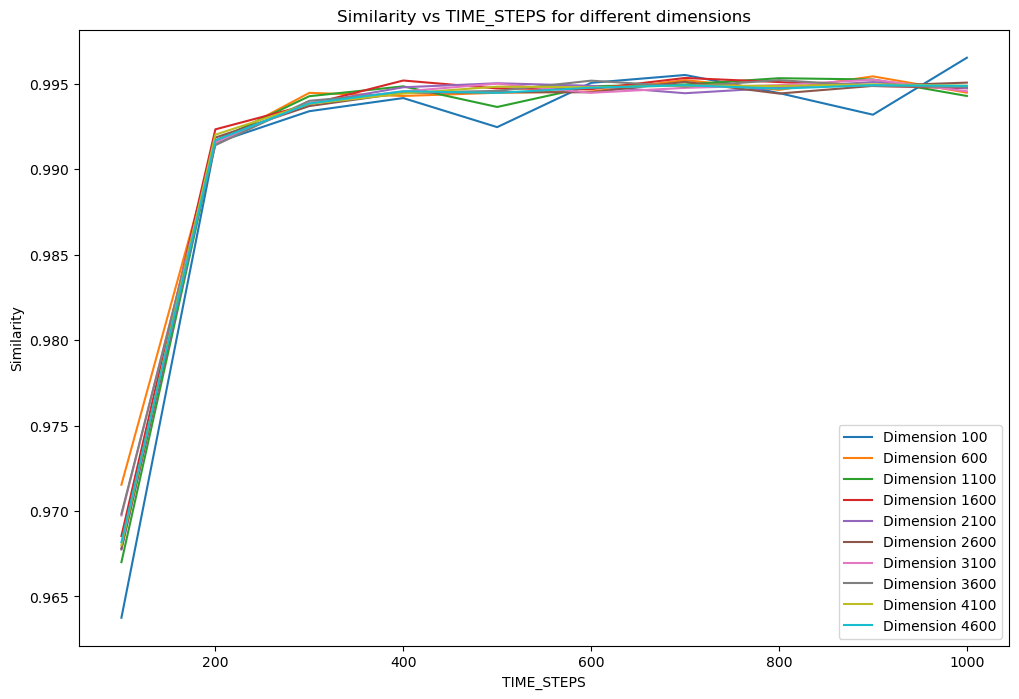

In [36]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for dim, sim_list in similarities.items():
    plt.plot(time_steps_range, sim_list, label=f'Dimension {dim}')
plt.xlabel('TIME_STEPS')
plt.ylabel('Similarity')
plt.title('Similarity vs TIME_STEPS for different dimensions')
plt.legend()

plt.savefig('foo-threah100.png')
plt.show()



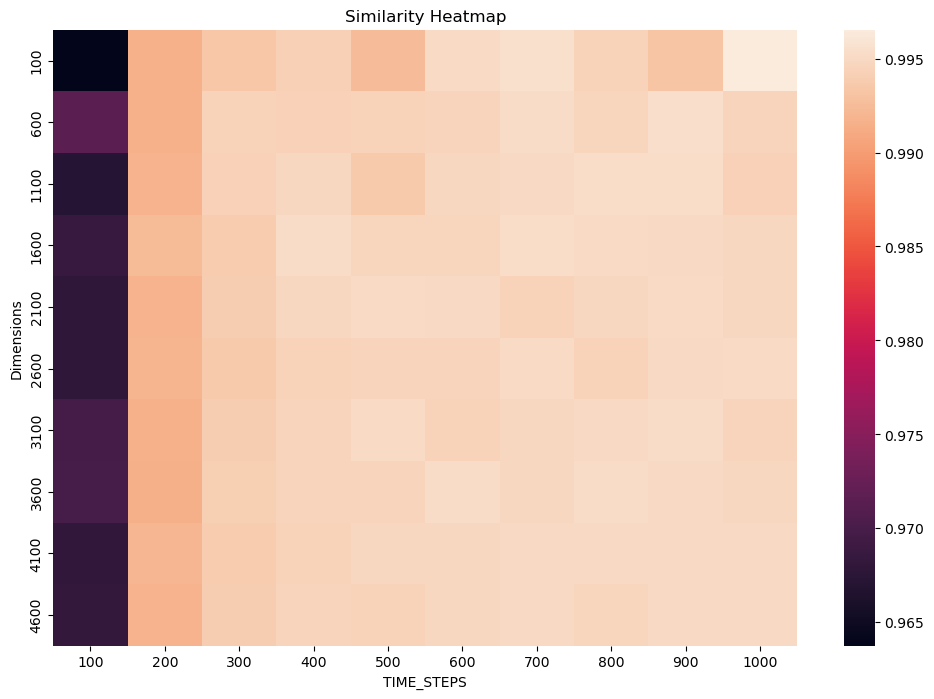

In [40]:
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, xticklabels=time_steps_range, yticklabels=dimensions)
plt.xlabel('TIME_STEPS')
plt.ylabel('Dimensions')
plt.title('Similarity Heatmap')

plt.savefig('foo2-threah100.png')
plt.show()

In [41]:
similarity_matrix

array([[0.96375338, 0.99155435, 0.99340547, 0.99417512, 0.99247259,
        0.99506774, 0.99552554, 0.99446744, 0.99320058, 0.99653641],
       [0.97153922, 0.99155143, 0.99447883, 0.99429778, 0.99448484,
        0.99455702, 0.99522668, 0.99465543, 0.99544507, 0.99449177],
       [0.96700701, 0.99167588, 0.99428334, 0.99485938, 0.99365286,
        0.99486601, 0.9949705 , 0.99533716, 0.9952617 , 0.99429678],
       [0.96853616, 0.99234293, 0.99380011, 0.99520212, 0.99473836,
        0.99469776, 0.99535188, 0.99511162, 0.99488566, 0.99474972],
       [0.96774909, 0.99169634, 0.99384975, 0.99480601, 0.99504152,
        0.99489324, 0.9944581 , 0.99478149, 0.99511027, 0.99475806],
       [0.96780072, 0.9918612 , 0.99370634, 0.99447915, 0.99451865,
        0.99451296, 0.99512659, 0.99443874, 0.99488612, 0.9950786 ],
       [0.96973453, 0.99157981, 0.99390035, 0.99456331, 0.99501727,
        0.99448381, 0.99477049, 0.99493038, 0.99525179, 0.99457327],
       [0.96983309, 0.99141593, 0.9940161

## Vs the Threshold

In [60]:
threshold_lst = [ i for i in range(50,1001,50) ]

print(f'threshold_lst: {len(threshold_lst)}')

threshold_lst: 20


In [61]:
TIME_STEPS = 5000
# lib.GlobalVars.global_threshold = int((TIME_STEPS - 1)/2)
lib.GlobalVars.time_steps = TIME_STEPS

In [62]:
# Initialize a dictionary to store similarities
similarities = {}
rnd_vectors = []
snn_vectors = []

# Initialize a matrix to store similarities
similarity_matrix = np.zeros((len(dimensions), len(threshold_lst)))

In [63]:
# Iterate over dimensions and thresholds with a progress bar
for i, dim in enumerate(tqdm(dimensions, desc='Dimensions')):
    similarities[dim] = []
    for j, threshold in enumerate(tqdm(threshold_lst, desc=f'threshold for Dim {dim}', leave=False)):
        # Generate a random normalized complex vector
        random_normalized_vector = generate_random_normalized_vector(dim)
        rnd_vectors.append(random_normalized_vector)

        lib.GlobalVars.global_threshold = threshold
        
        # Convert to phase representation, encode, decode, and convert back
        encoder = lib.FHRR_Encoder(vec=random_normalized_vector)
        decoder = lib.FHRR_Decoder(dimension=random_normalized_vector.shape[0])
        encoder.spikes_out.connect(decoder.spikes_a_in)
        decoder.run(condition=RunSteps(num_steps=TIME_STEPS), run_cfg=Loihi1SimCfg())
        raw_rslt = decoder.get_decoded_value()
        rect_rslt = util.phase2complex_array(raw_rslt)

        snn_vectors.append(rect_rslt)
        # Compute similarity
        similarity = util.similarity(rect_rslt, random_normalized_vector)
        
        print(similarity)
        print(rect_rslt[:10])
        print(random_normalized_vector[:10])
        similarities[dim].append(similarity)

        similarity_matrix[i, j] = similarity

threshold for Dim 100:   5%|▌         | 1/20 [00:15<04:51, 15.32s/it]

-0.13118355433162582
[(0.9646546452305639+0.26351739114353506j), (0.9273677030509753+0.37415123057121996j), (-0.95981620122199+0.28062939951435684j), (-0.8011436155469337+0.5984721441039565j), (-0.7243947646475003+0.6893853965317895j), (0.4545751960981932+0.8907083647818118j), (0.11527994954575044-0.9933330424549106j), (0.008296231623858378+0.9999655856782489j), (0.11527994954575044-0.9933330424549106j), (0.9207365363804042-0.39018486717736317j)]
[ 0.11173367+0.01499116j -0.14780802-0.03465419j  0.00743584+0.06888883j
  0.01953371+0.06160235j  0.02673376+0.06848016j  0.05506014+0.03382731j
  0.02191888-0.00272383j  0.06879536+0.06930811j  0.06301683-0.04178699j
 -0.04658719+0.00724023j]



threshold for Dim 100:  10%|█         | 2/20 [00:21<03:01, 10.08s/it]

0.9947801401918884
[(0.3578618092831215+0.9337745581544888j), (-0.3801773040989977+0.9249136270203928j), (0.9207365363804042-0.39018486717736317j), (0.9994494182244994-0.03317921654755682j), (-0.34503924378889006+0.9385882591667077j), (0.7467529543114478-0.6651015149788224j), (-0.5672120640663181+0.8235717785218403j), (-0.953340145572774-0.30189827233570254j), (-0.6851321243741246+0.7284188164446324j), (0.2687499769545138+0.9632099718581345j)]
[ 0.06151795+0.16413277j -0.00357317+0.00793264j  0.04512586-0.00528452j
  0.1654092 -0.00146387j -0.03216543+0.08614087j  0.10866585-0.04841159j
 -0.05094207+0.07344422j -0.04973741-0.01701761j -0.07309564+0.07540383j
  0.03179377+0.11996463j]



threshold for Dim 100:  15%|█▌        | 3/20 [00:28<02:27,  8.65s/it]

0.3023532116168692
[(-0.9345461343110483+0.3558419914010657j), (-0.95981620122199+0.28062939951435684j), (0.9990978229507305+0.04246810774111455j), (-0.7618958404911819-0.6476995663440231j), (-0.95981620122199+0.28062939951435684j), (0.7342271975630038+0.6789038388157617j), (-0.34503924378889006+0.9385882591667077j), (0.05561610016580674+0.9984522269003895j), (-0.8378355048012958+0.5459227664188021j), (-0.6456933542311118+0.763596812658209j)]
[-0.04552827-0.07671371j -0.01976037-0.04945986j  0.101434  +0.00647297j
  0.04463844-0.01504769j -0.0267116 -0.07770438j  0.04271551+0.0884212j
 -0.10723332+0.02392339j -0.05328727+0.06206802j -0.02820108-0.02430381j
 -0.11861112-0.03579103j]



threshold for Dim 100:  20%|██        | 4/20 [00:35<02:04,  7.79s/it]

-0.10969081278505731
[(-0.5285259596126687+0.8489171396641181j), (-0.9052239194266833+0.4249348840678928j), (0.008296231623858378+0.9999655856782489j), (-0.9052239194266833+0.4249348840678928j), (-0.993813698804694+0.11106003812412972j), (0.48552756893266696+0.8742213562973249j), (-0.4903898319782835+0.8715031914412654j), (0.12122209490630638+0.9926254095611932j), (-0.7243947646475003+0.6893853965317895j), (-0.2132672753837673+0.9769938941725196j)]
[-0.02204389-0.05102162j  0.02107678-0.0241173j  -0.12631353+0.00186033j
  0.07305037-0.08421888j  0.04813016-0.00960353j -0.02137427+0.03411366j
 -0.06841648-0.1255231j  -0.09886866+0.02019921j  0.00159467-0.01374358j
 -0.06652013-0.03341774j]



threshold for Dim 100:  25%|██▌       | 5/20 [00:41<01:47,  7.18s/it]

-0.17417194199587038
[(0.952162891425673+0.3055909491328271j), (-0.4161468365471424+0.9092974268256817j), (0.999999995+9.999999983333334e-05j), (0.7100338835660797+0.7041675114545337j), (-0.4903898319782835+0.8715031914412654j), (-0.4529041164186286+0.8915592304110037j), (0.6508681227351676+0.7591908105392207j), (0.05561610016580674+0.9984522269003895j), (0.8528115841433538+0.5222187299885972j), (0.819787717235076+0.5726675289122851j)]
[ 0.06964676+0.06852317j  0.0296827 -0.08351325j  0.06276157+0.00016173j
 -0.02564783+0.06311934j  0.04546527-0.06709559j  0.02736359-0.06163349j
 -0.04349968+0.06342574j -0.03066013-0.02484202j  0.01434492+0.07209681j
  0.00490174+0.12573547j]



threshold for Dim 100:  30%|███       | 6/20 [00:46<01:29,  6.43s/it]

-0.29075520282549777
[(0.4436660217022285+0.8961922010299563j), (0.9982310869019413+0.05945331902063189j), (-0.15274137361439757+0.9882661953069056j), (0.6508681227351676+0.7591908105392207j), (0.9994511018097588+0.033128463460583006j), (0.819787717235076+0.5726675289122851j), (0.9538835665937107+0.30017685017746115j), (0.5140231914341965+0.8577762870747847j), (0.7886097020419096+0.6148940866892204j), (0.7939031529039693+0.6080442284975138j)]
[-0.10999642-0.02552388j  0.11517173+0.02077795j  0.00776602-0.01464738j
 -0.117553  +0.06944693j  0.03229639+0.00322217j -0.01649137+0.05971069j
  0.09954466+0.1298444j  -0.06872789+0.00333113j -0.03524786+0.07958447j
 -0.06874002+0.16500493j]



threshold for Dim 100:  35%|███▌      | 7/20 [00:53<01:25,  6.57s/it]

-0.18429034281496953
[(0.82189840263017+0.5696341069089657j), (0.12122209490630638+0.9926254095611932j), (0.7621133212351487+0.6474436543792293j), (0.8039178268116431+0.5947403868365128j), (0.23523757330298942+0.9719379013633127j), (0.985425271015111+0.1701088923154663j), (0.9821185146968964+0.18826370624621747j), (0.3002679382069597+0.9538548973952702j), (0.9599168537508159+0.280284915550471j), (0.9995890515903052+0.02866579740377132j)]
[-0.04365532+0.06968061j  0.03041803-0.07491133j -0.05173035+0.04139294j
 -0.0386237 +0.04958295j -0.00032954-0.03377563j  0.03494469+0.02386456j
  0.1259792 +0.09838642j -0.01023746-0.0382626j   0.04405   +0.06816132j
  0.02400964+0.00241829j]



threshold for Dim 100:  40%|████      | 8/20 [01:01<01:25,  7.17s/it]

-0.16576866543916183
[(0.6393121087462669+0.7689473503500752j), (0.6393121087462669+0.7689473503500752j), (0.3967794573978568+0.9179139731952348j), (0.9930056128843501+0.11806715368880626j), (0.9894247758448921+0.1450469335914586j), (0.817639731537178+0.5757302054016373j), (0.9983394543656726+0.05760498118089342j), (0.5645785415239551+0.8253793494210305j), (0.9978423327958105+0.06565576045264436j), (0.9216804111574521+0.38795002215315055j)]
[-0.16063944-0.06350994j -0.13505916-0.05667134j -0.00558552-0.10796328j
  0.01922425+0.0098507j   0.10999073+0.07250063j -0.06579755+0.05254885j
  0.19030645+0.04467707j -0.03600089-0.03534591j  0.05968283+0.01605707j
 -0.00361688+0.13087118j]



threshold for Dim 100:  45%|████▌     | 9/20 [01:08<01:19,  7.18s/it]

-0.2476273387496109
[(0.4324433208787433+0.9016611193942901j), (0.9601421133918149+0.2795122932743734j), (0.5941567566392187+0.8043492702427001j), (0.9592295245754523+0.2826282349354921j), (0.7714654647199196+0.6362711974814501j), (0.8393485421360546+0.5435936210204088j), (0.38418576039005164+0.9232558158568609j), (0.5317751800910392+0.8468855636029834j), (0.701247277672761+0.7129181268256136j), (0.999999995+9.999999983333334e-05j)]
[ 0.05232892-0.12519182j  0.0229451 +0.07618704j -0.0210762 -0.04087825j
  0.00596714+0.02073429j -0.08340597+0.00268264j -0.04863884+0.02995372j
  0.05555007-0.08080281j -0.00974345-0.06894574j -0.04999964-0.02398306j
  0.12216819+0.00125047j]



threshold for Dim 100:  50%|█████     | 10/20 [01:15<01:09,  6.95s/it]

-0.23856042462893207
[(0.8700641331057718+0.49293854006650945j), (0.34410380265899404+0.9389316125233084j), (0.5645785415239551+0.8253793494210305j), (0.9453187086602498+0.32614803242840157j), (0.7802845450368268+0.6254246787397123j), (0.9897255317958369+0.1429803193150995j), (0.8775825618903728+0.479425538604203j), (0.572259013127408+0.8200729369357612j), (0.819787717235076+0.5726675289122851j), (0.6393121087462669+0.7689473503500752j)]
[-0.06941607+0.04281923j  0.1321192 -0.01786735j  0.01120139-0.07496787j
 -0.01085619+0.11906362j -0.05927092-0.0153172j   0.01585006+0.01383144j
 -0.0591447 +0.04326518j  0.00938093-0.09503545j -0.07965072+0.00618707j
 -0.05312726-0.15733171j]



threshold for Dim 100:  55%|█████▌    | 11/20 [01:21<01:02,  6.90s/it]

-0.2338970054563588
[(0.7056887373020527+0.7085219869877254j), (0.952162891425673+0.3055909491328271j), (0.7912812521891716+0.6114523529547798j), (0.808656949543779+0.5882804925837251j), (0.9390715639271772+0.3437216865770411j), (0.9921585600392355+0.12498556613013657j), (0.9280404064183904+0.3724795350818469j), (0.701247277672761+0.7129181268256136j), (0.9674727072613298+0.25297541521743416j), (0.6920641380719618+0.7218360123980465j)]
[-0.00252428-0.00672372j -0.01126873+0.07930041j -0.02501201-0.01344203j
 -0.02221383-0.00774273j -0.05100263+0.13319087j  0.03361681+0.02774033j
 -0.08498542+0.14550255j -0.08455177-0.23920723j  0.00708514+0.04329053j
 -0.02208222-0.07871011j]



threshold for Dim 100:  60%|██████    | 12/20 [01:28<00:53,  6.74s/it]

-0.26243262115857613
[(0.90775282224005+0.41950543943460855j), (0.6144632264484674+0.7889454628442574j), (0.8154535729533534+0.5788224860504384j), (0.9210609940028851+0.3894183423086505j), (0.9222925993611683+0.38649238176660033j), (0.9823856090908272+0.18686496475060405j), (0.6824608905587893+0.7309221113481956j), (0.9346096415483818+0.35567515786853215j), (0.9987351306508966+0.05028060067000556j), (0.6078619028434016+0.7940427614880694j)]
[-0.11669194+0.06891876j  0.08902959-0.09338161j -0.07544163-0.04805093j
 -0.11940963+0.10862937j -0.03559824+0.03373678j  0.02745181+0.05812854j
  0.0420306 -0.18487416j -0.03979176+0.05662521j  0.08077948+0.02515058j
  0.1221157 -0.11408943j]



threshold for Dim 100:  65%|██████▌   | 13/20 [01:34<00:46,  6.67s/it]

-0.03491305371093844
[(0.7684093529355933+0.6399586442271897j), (0.90775282224005+0.41950543943460855j), (0.9841549347681519+0.17731064370616573j), (0.8428807322297306+0.5381004285780426j), (0.6824608905587893+0.7309221113481956j), (0.9646546452305639+0.26351739114353506j), (0.7100338835660797+0.7041675114545337j), (0.7265039917873152+0.6871622442459252j), (0.7342271975630038+0.6789038388157617j), (0.9500312551485921+0.3121547921156917j)]
[-0.01527991-0.08931215j -0.05269213+0.01743208j  0.09968907+0.22918289j
 -0.08738943-0.05402357j  0.00504434-0.00710592j -0.00896495+0.05326896j
  0.03121574-0.07998785j  0.0103299 -0.04727382j  0.01015233-0.0684701j
 -0.02865485+0.05286042j]



threshold for Dim 100:  70%|███████   | 14/20 [01:42<00:40,  6.82s/it]

-0.10852925101043402
[(0.9877030037693195+0.15634185730335842j), (0.857430644726112+0.5145995428336135j), (0.6724122440830567+0.7401768531960371j), (0.9987638921331132+0.04970601343011677j), (0.7744623790432964+0.6326199676319089j), (0.8751500385908233+0.48385164043793466j), (0.9809128200594511+0.19444803789962714j), (0.6271892555745167+0.7788668934367949j), (0.9589964916870276+0.2834179403848188j), (0.9745157314202713+0.22431916818322467j)]
[ 0.04837331+0.09513054j -0.05507934-0.04280914j  0.07099407-0.03079031j
  0.0516379 +0.01873824j  0.01372034-0.13525017j -0.2205516 -0.09373277j
  0.00288457+0.01425659j  0.0793566 -0.00038289j -0.01807727+0.03820392j
 -0.00131833+0.09164214j]



threshold for Dim 100:  75%|███████▌  | 15/20 [01:48<00:33,  6.66s/it]

-0.12130877363457801
[(0.957058304992043+0.28989549987151825j), (0.8496075628495278+0.5274153857718655j), (0.9533204423322669+0.30196048455288155j), (0.8855629625439143+0.46451936382722075j), (0.9280404064183904+0.3724795350818469j), (0.9894554413322724+0.14483759739086466j), (0.9500312551485921+0.3121547921156917j), (0.837538075077588+0.5463789644517151j), (0.7774015898234545+0.6290045851501922j), (0.7939031529039693+0.6080442284975138j)]
[-0.0649337 +0.08716551j -0.03787927-0.06276477j -0.10001356+0.11099618j
 -0.03853638-0.0206357j  -0.02340402+0.00657716j  0.00289992+0.00558041j
 -0.09324477+0.08797546j -0.03081896-0.0807838j   0.03970644-0.09289672j
  0.02333809-0.115316j  ]



threshold for Dim 100:  80%|████████  | 16/20 [01:55<00:27,  6.85s/it]

-0.12842983190348145
[(0.9364512175340916+0.35079782949573324j), (0.986504667314577+0.16373314070937467j), (0.979744868775503+0.20024982423980361j), (0.9263846115959489+0.3765787452820764j), (0.9891745657915616+0.14674358040839675j), (0.9787316504950672+0.20514472042731602j), (0.9773546859172189+0.2116076981483764j), (0.9719222093846311+0.23530239885070686j), (0.9560374001318926+0.2932447604801343j), (0.9216804111574521+0.38795002215315055j)]
[-0.13022608+0.03581612j  0.01224681+0.04715788j -0.00616244+0.13687537j
 -0.12085536+0.00607711j  0.00858149+0.02073803j -0.01486598+0.17884509j
 -0.00945463+0.06915078j -0.02136567+0.06196844j -0.09071731+0.0861908j
 -0.03044037-0.00143668j]



threshold for Dim 100:  85%|████████▌ | 17/20 [02:03<00:21,  7.30s/it]

-0.15385267809720274
[(0.9825820259218576+0.18582939039693866j), (0.9355402561215705+0.3532200860313386j), (0.819787717235076+0.5726675289122851j), (0.9885435216570246+0.15093609836592292j), (0.8646637019492132+0.5023511546035125j), (0.9951791325189789+0.09807392211374277j), (0.808656949543779+0.5882804925837251j), (0.8993618215711724+0.437205116507324j), (0.9961483787911877+0.08768356420497771j), (0.8993618215711724+0.437205116507324j)]
[-0.00193466+0.10013669j -0.08685044+0.0059944j   0.02808665-0.05137873j
  0.02874992+0.09914689j -0.02443421-0.10537103j  0.04683432+0.05178986j
  0.03521968-0.04582211j -0.04565105-0.0392157j   0.05745122+0.05312289j
 -0.07230542-0.06216353j]



threshold for Dim 100:  90%|█████████ | 18/20 [02:10<00:14,  7.22s/it]

-0.1418886571253677
[(0.9794153174074074+0.20185548302621686j), (0.9493960948521996+0.3140812873754076j), (0.8338250916881907+0.5520287279401139j), (0.9171861562842053+0.39845897495301236j), (0.8660446862275001+0.49996660034157375j), (0.9612404886927073+0.27571130353651685j), (0.7964766088701267+0.604669340650527j), (0.9045263705750485+0.42641768834598087j), (0.9222925993611683+0.38649238176660033j), (0.785887260776948+0.618369803069737j)]
[-0.01651974+0.06194185j -0.07861562+0.02139764j  0.01962505-0.03010591j
 -0.03717561-0.02323481j  0.00167435-0.07004369j -0.09132269+0.06546096j
  0.15321964-0.06640891j -0.02349903-0.02600065j -0.15434453-0.0724078j
  0.17813957-0.04686733j]



threshold for Dim 100:  95%|█████████▌| 19/20 [02:17<00:07,  7.02s/it]

-0.05783118788126747
[(0.8014828279686188+0.5980177894272255j), (0.9932472027277035+0.11601721541905903j), (0.819787717235076+0.5726675289122851j), (0.9974317599979466+0.07162320955806617j), (0.9848627322051335+0.17333608601049966j), (0.9955783621756013+0.09393468351864204j), (0.90025108058565+0.4353710967719027j), (0.90025108058565+0.4353710967719027j), (0.9997259113692527+0.023411581256228994j), (0.8319211983084851+0.5548937914637126j)]
[ 0.12519355-0.02415742j  0.03253065+0.06483387j  0.11174146-0.05621031j
  0.10102673+0.08193325j -0.01102143+0.12975668j  0.11503445+0.14324019j
 -0.0442035 -0.10035734j -0.01722033-0.03729602j  0.14439021+0.0326679j
  0.07091797-0.05906075j]



Dimensions:  10%|█         | 1/10 [02:24<21:37, 144.14s/it]           

-0.03710185948817082
[(0.82189840263017+0.5696341069089657j), (0.999999995+9.999999983333334e-05j), (0.90025108058565+0.4353710967719027j), (0.9573079882121021+0.2890699149086564j), (0.9963806371956848+0.08500368122335099j), (0.985425271015111+0.1701088923154663j), (0.8887476410517441+0.4583968046626855j), (0.82189840263017+0.5696341069089657j), (0.9403215814112726+0.3402871192569642j), (0.8811011251207619+0.4729279092112533j)]
[ 0.06485849-0.01305799j  0.12275721+0.02149797j -0.00535808-0.02690398j
 -0.1253798 +0.02635326j  0.00380823+0.00434657j -0.00432736+0.03049889j
  0.00033172-0.00569476j  0.14541126-0.03206548j -0.09502466-0.03311544j
  0.01799899-0.07893251j]



threshold for Dim 600:   5%|▌         | 1/20 [00:06<02:12,  6.96s/it]

-0.17539060723232083
[(0.9823856090908272+0.18686496475060405j), (-0.8390715290764524-0.5440211108893698j), (-0.46120403916318925+0.8872941080946944j), (0.7184459458036359+0.6955827937480333j), (0.11527994954575044-0.9933330424549106j), (0.5233425926926495-0.8521223683683791j), (0.11527994954575044-0.9933330424549106j), (-0.8390715290764524-0.5440211108893698j), (0.7379688836504575+0.6748347403355116j), (0.1609705435155287+0.986959210970907j)]
[ 0.04573327+0.0043129j   0.00977575-0.01200144j -0.0115509 -0.02041437j
  0.03802361+0.01544912j  0.00416235-0.0022876j  -0.03433742+0.01802841j
  0.03678151-0.00221004j  0.01014661-0.02075565j  0.01619436+0.00630246j
 -0.04759801-0.06392876j]



threshold for Dim 600:  10%|█         | 2/20 [00:13<01:59,  6.64s/it]

0.9954082017980763
[(-0.8461318632533809-0.532973610967149j), (0.7487396392960327+0.6628642037000089j), (-0.8011436155469337+0.5984721441039565j), (0.714285416750154+0.6998545158945956j), (0.7467529543114478-0.6651015149788224j), (-0.6536436208636119-0.7568024953079282j), (-0.993813698804694+0.11106003812412972j), (0.7467529543114478-0.6651015149788224j), (0.4545751960981932+0.8907083647818118j), (-0.9998623450816866+0.016591892229347906j)]
[-0.03775872-0.02803414j  0.02103456+0.01873913j -0.01807321+0.0131243j
  0.00953204+0.00939854j  0.01839048-0.01261828j -0.02262022-0.03121328j
 -0.02542547+0.0004748j   0.0135419 -0.01167265j  0.02552702+0.05135519j
 -0.01512585-0.00101085j]



threshold for Dim 600:  15%|█▌        | 3/20 [00:20<01:58,  6.96s/it]

0.3961813377537457
[(-0.6851321243741246+0.7284188164446324j), (-0.6851321243741246+0.7284188164446324j), (-0.27736991252352794+0.9607632026814362j), (-0.6536436208636119-0.7568024953079282j), (0.8462988009204383+0.5327084939820542j), (-0.7631851459912401+0.6461798766120231j), (0.23523757330298942+0.9719379013633127j), (-0.9090341385007688-0.4167216517534999j), (0.9696713980453007+0.24441231518250478j), (-0.27736991252352794+0.9607632026814362j)]
[-0.02908947-0.01131934j -0.01877024-0.00699837j -0.04865694+0.01849033j
  0.0103627 -0.00150213j  0.04183765+0.04725408j -0.02434519-0.01674794j
 -0.00976829+0.02007965j  0.02861467-0.02859555j  0.02288021+0.00890705j
 -0.02610182+0.00974507j]



threshold for Dim 600:  20%|██        | 4/20 [00:27<01:47,  6.74s/it]

-0.023899176543762307
[(0.16163342880813794+0.9868508675031524j), (-0.4161468365471424+0.9092974268256817j), (-0.9998623450816866+0.016591892229347906j), (-0.9799838101673936+0.19907720062779133j), (-0.993813698804694+0.11106003812412972j), (-0.5672120640663181+0.8235717785218403j), (0.16163342880813794+0.9868508675031524j), (0.9240868949004546+0.38218243114151146j), (0.49528663493703556+0.8687296180358695j), (-0.95981620122199+0.28062939951435684j)]
[-0.05464836+0.01775459j -0.05593081-0.06986658j  0.01775796-0.00016926j
  0.02738023-0.01126572j  0.03073471-0.00679045j -0.00403216-0.01337389j
 -0.02162676+0.00691833j  0.00579547+0.00580068j -0.00148245+0.00245414j
  0.05390417-0.02607858j]



threshold for Dim 600:  25%|██▌       | 5/20 [00:36<01:55,  7.70s/it]

-0.19034179415197805
[(0.10004046639387086+0.9949833692498065j), (0.9530350149312725+0.302860133254526j), (-0.27736991252352794+0.9607632026814362j), (0.9839271541625845+0.17857030912645533j), (-0.7631851459912401+0.6461798766120231j), (-0.34503924378889006+0.9385882591667077j), (0.6564442067160553+0.7543745776926267j), (-0.7631851459912401+0.6461798766120231j), (-0.31076343038793947+0.950487290990006j), (-0.09572354801437566+0.9954079577517649j)]
[-0.01410852-0.00888071j  0.02000671+0.01940527j -0.00542005-0.06548788j
  0.01125954+0.00542593j  0.06519074-0.00918962j  0.00286447-0.02586362j
 -0.00949379+0.01462488j  0.03871144-0.00272689j  0.00103707-0.0627671j
 -0.01814987-0.03134202j]



threshold for Dim 600:  30%|███       | 6/20 [00:41<01:36,  6.92s/it]

-0.2085305814308001
[(0.7452230769754007+0.6668152409350854j), (0.1809058673577943+0.9835004154323089j), (-0.4161468365471424+0.9092974268256817j), (0.10004046639387086+0.9949833692498065j), (0.785887260776948+0.618369803069737j), (0.9790776670632941+0.20348690832065178j), (-0.4529041164186286+0.8915592304110037j), (0.9996704424810002+0.02567112054120572j), (-0.1825600552208028+0.9831947041343222j), (0.40901195037184035+0.9125290266358781j)]
[-0.02410547+0.03293489j -0.02745597-0.04805061j  0.03615591-0.00886822j
 -0.00581775-0.02141461j -0.01260689+0.02724908j  0.03315401+0.02346011j
  0.05099204-0.00584019j  0.03141453+0.00242505j  0.01519341-0.02065926j
 -0.04574922-0.01525643j]



threshold for Dim 600:  35%|███▌      | 7/20 [00:48<01:29,  6.91s/it]

-0.2053865841192027
[(-0.06849426571540826+0.9976515100796004j), (0.8496075628495278+0.5274153857718655j), (0.8356971513047824+0.5491905600982883j), (0.6920641380719618+0.7218360123980465j), (0.9355402561215705+0.3532200860313386j), (0.8559151974656445+0.5171162100991873j), (0.8280150209018973+0.5607059168234544j), (0.5317751800910392+0.8468855636029834j), (0.9587614598971088+0.2842120036451041j), (-0.15274137361439757+0.9882661953069056j)]
[ 0.02064643-0.01072239j -0.01093491+0.02712059j -0.00699231+0.01373171j
 -0.06375308+0.01972529j  0.00565762+0.01807505j -0.01950169+0.05517087j
 -0.00658728+0.0116306j  -0.04006458-0.01729677j  0.01084385+0.01725389j
  0.00810186-0.00158328j]



threshold for Dim 600:  40%|████      | 8/20 [00:55<01:21,  6.82s/it]

-0.22221943173663405
[(0.572259013127408+0.8200729369357612j), (0.7802845450368268+0.6254246787397123j), (0.21768794244665535+0.9760184218104399j), (0.3002679382069597+0.9538548973952702j), (0.38418576039005164+0.9232558158568609j), (0.38418576039005164+0.9232558158568609j), (0.5486070830429639+0.8360803002314374j), (0.8063088546602225+0.5914947429153704j), (0.90775282224005+0.41950543943460855j), (0.7225179918904224+0.6913521182397806j)]
[-0.05090111-0.04439081j -0.03858289+0.01779247j  0.0150509 -0.0164279j
  0.00957753-0.02452795j  0.00056619-0.03295419j  0.00187533-0.05672184j
 -0.01826694-0.02096523j -0.04746521+0.03223475j -0.00304792+0.01811777j
 -0.01431006+0.00098462j]



threshold for Dim 600:  45%|████▌     | 9/20 [01:01<01:11,  6.51s/it]

-0.20909976982235828
[(0.6393121087462669+0.7689473503500752j), (0.6393121087462669+0.7689473503500752j), (0.38418576039005164+0.9232558158568609j), (0.9823193987771442+0.18721271000151107j), (0.8713641278212078+0.49063688889685614j), (0.844603724826933+0.5353919573625201j), (0.9442226030882189+0.3293078739072417j), (0.7588701679614305+0.6512419428892693j), (0.7379688836504575+0.6748347403355116j), (0.6144632264484674+0.7889454628442574j)]
[-0.00886788-0.0097288j  -0.02799349-0.03025568j  0.02074076-0.0299557j
  0.02836592+0.03218276j -0.01705356+0.0185177j  -0.0219482 +0.01488871j
  0.00130431+0.02278069j -0.01751891-0.00095101j -0.00931955-0.00183438j
 -0.00805394-0.01195197j]



threshold for Dim 600:  50%|█████     | 10/20 [01:08<01:08,  6.82s/it]

-0.22686925429068633
[(0.9834566210774341+0.1811437949777911j), (0.9786438067632134+0.20556337096867808j), (0.6078619028434016+0.7940427614880694j), (0.9704029609425596+0.24149139403695763j), (0.9636987715894713+0.26699190556446467j), (0.6144632264484674+0.7889454628442574j), (0.6774938938207989+0.735528397708431j), (0.38418576039005164+0.9232558158568609j), (0.3153223623952687+0.9489846193555862j), (0.4324433208787433+0.9016611193942901j)]
[ 0.02421855+0.03120239j  0.01223012+0.02069601j -0.00434135-0.04157381j
  0.01124543+0.03087761j  0.00908617+0.0412005j  -0.00319013-0.0211578j
 -0.01055393-0.01619873j  0.01322679-0.00539883j  0.03886498-0.0009582j
  0.05842706-0.04152672j]



threshold for Dim 600:  55%|█████▌    | 11/20 [01:15<01:00,  6.69s/it]

-0.09468116351756543
[(0.819787717235076+0.5726675289122851j), (0.7774015898234545+0.6290045851501922j), (0.9061602762589456+0.4229344555960314j), (0.9671392252224772+0.2542473579726377j), (0.9487487830246576+0.316031243248561j), (0.9712464789226725+0.238076200365158j), (0.8660446862275001+0.49996660034157375j), (0.8956839374134153+0.4446912235018822j), (0.4545751960981932+0.8907083647818118j), (0.645158803210985+0.7640485054231633j)]
[-0.04049531-0.00926323j -0.01308209-0.00901303j -0.01888352+0.01718673j
  0.00593876+0.03763682j -0.00866089+0.04261469j  0.01121038+0.04470773j
 -0.01358747+0.00354833j -0.02036103+0.01397359j  0.02735439-0.00502636j
  0.0081197 -0.10327198j]



threshold for Dim 600:  60%|██████    | 12/20 [01:22<00:55,  6.88s/it]

-0.15930055854393957
[(0.9269428099412703+0.3752026480426039j), (0.7886097020419096+0.6148940866892204j), (0.9927158081131835+0.12047955976923659j), (0.7621133212351487+0.6474436543792293j), (0.9717889794219072+0.2358520287683105j), (0.8674048116179512+0.49760314788195076j), (0.6010948708300845+0.7991776750271269j), (0.7588701679614305+0.6512419428892693j), (0.6774938938207989+0.735528397708431j), (0.9684433051526564+0.24923395576244992j)]
[-0.02502429+0.02716501j -0.03298383-0.03623479j  0.03376711+0.02989866j
 -0.01776673-0.03404169j  0.00223287+0.01591816j -0.0361549 +0.00041395j
  0.01292765-0.01139778j -0.01266467-0.02714828j  0.01067873-0.03915702j
  0.00251877+0.04385286j]



threshold for Dim 600:  65%|██████▌   | 13/20 [01:29<00:47,  6.86s/it]

-0.18044085930200557
[(0.8646637019492132+0.5023511546035125j), (0.9011286743453896+0.43355174117113265j), (0.8428807322297306+0.5381004285780426j), (0.9497151748844606+0.3131151331286599j), (0.9846500809747535+0.17454001843821215j), (0.9973718439526769+0.07245277696843165j), (0.7416334898027026+0.6708053121458301j), (0.9011286743453896+0.43355174117113265j), (0.6824608905587893+0.7309221113481956j), (0.7802845450368268+0.6254246787397123j)]
[-0.04643039-0.0141436j  -0.05733845+0.01308034j -0.02441676-0.01509037j
 -0.00844457+0.01526498j  0.00904017+0.01969905j  0.0257254 +0.01311215j
  0.00172516-0.0190202j  -0.01509926+0.00328257j  0.00490116-0.00667943j
 -0.01662525-0.05386717j]



threshold for Dim 600:  70%|███████   | 14/20 [01:36<00:40,  6.82s/it]

-0.15426071807519942
[(0.8496075628495278+0.5274153857718655j), (0.9900136447083682+0.1409715690884264j), (0.9883327583671224+0.15231007431695115j), (0.6873165666204667+0.7263579952399875j), (0.8687444924992417+0.4952605443120167j), (0.6920641380719618+0.7218360123980465j), (0.9862349387088885+0.16535007006310906j), (0.7487396392960327+0.6628642037000089j), (0.90775282224005+0.41950543943460855j), (0.9386461850013424+0.3448816309727522j)]
[-0.0201867 -0.01910757j  0.01327318+0.02027568j  0.03155504+0.05781938j
  0.02688478-0.0167615j  -0.03038928-0.01632559j  0.04038601-0.02734261j
  0.01372809+0.03190862j  0.00660542-0.01742885j -0.03199885+0.00347677j
 -0.0243114 +0.01919854j]



threshold for Dim 600:  75%|███████▌  | 15/20 [01:42<00:34,  6.84s/it]

-0.1075434347978252
[(0.8014828279686188+0.5980177894272255j), (0.8528115841433538+0.5222187299885972j), (0.799002789059171+0.6013273177527076j), (0.999999995+9.999999983333334e-05j), (0.7379688836504575+0.6748347403355116j), (0.7265039917873152+0.6871622442459252j), (0.9100670872842439+0.41446097119267133j), (0.8907979509245075+0.45439961556838787j), (0.7831126483653844+0.6218798758362855j), (0.8462988009204383+0.5327084939820542j)]
[ 0.00445169-0.03820074j -0.02370563-0.03663235j  0.00583313-0.04113169j
  0.08805257+0.00378902j  0.02574525-0.02121199j  0.06975631-0.04505712j
 -0.06103342-0.00435835j -0.03946173-0.01725788j  0.01132607-0.03336198j
 -0.00865145-0.01665863j]



threshold for Dim 600:  80%|████████  | 16/20 [01:49<00:27,  6.91s/it]

-0.0903634897920998
[(0.7342271975630038+0.6789038388157617j), (0.9263846115959489+0.3765787452820764j), (0.8462988009204383+0.5327084939820542j), (0.925820019428764+0.3779646698104506j), (0.9316941040625096+0.3632438526047722j), (0.9390715639271772+0.3437216865770411j), (0.9812797815681225+0.19258761716584474j), (0.7621133212351487+0.6474436543792293j), (0.837538075077588+0.5463789644517151j), (0.8918020542295536+0.4524257906794752j)]
[ 0.01496191-0.00460159j -0.04943096+0.00246515j -0.0033536 -0.01614048j
 -0.02480129+0.0007269j  -0.03411266+0.0056257j  -0.02955232+0.01022517j
  0.00136769+0.06841054j  0.01682175-0.01224066j -0.00356366-0.04834841j
 -0.02505171-0.01788964j]



threshold for Dim 600:  85%|████████▌ | 17/20 [01:57<00:21,  7.10s/it]

-0.13720595508802888
[(0.9983659246767302+0.0571443824393741j), (0.9263846115959489+0.3765787452820764j), (0.9865488510295779+0.16346670771817673j), (0.9930875631178825+0.11737585774164014j), (0.8833638132121737+0.46868792763122014j), (0.7886097020419096+0.6148940866892204j), (0.9592295245754523+0.2826282349354921j), (0.9781051464940506+0.2081113221375807j), (0.8479665542043894+0.5300497362990896j), (0.9980499482327696+0.062420355915085025j)]
[ 0.01415998+0.00748245j -0.00694693-0.00099546j  0.00303864+0.01729004j
  0.02619157+0.04087237j -0.01319021-0.02136919j  0.0341993 -0.02586006j
 -0.04330266+0.03665895j -0.00612753+0.0282932j   0.00051037-0.01405968j
  0.01363035+0.00800322j]



threshold for Dim 600:  90%|█████████ | 18/20 [02:03<00:13,  6.90s/it]

-0.11605888229442361
[(0.9100670872842439+0.41446097119267133j), (0.9906063615762323+0.13674442001302667j), (0.9045263705750485+0.42641768834598087j), (0.82189840263017+0.5696341069089657j), (0.9484204734871478+0.3170151502222165j), (0.858922516031167+0.5121055667093355j), (0.9920993458965234+0.1254547243896797j), (0.9449569463147377+0.3271946967961522j), (0.808656949543779+0.5882804925837251j), (0.8674048116179512+0.49760314788195076j)]
[-0.04056788-0.03496088j  0.01569442+0.04498425j -0.01427696-0.015891j
  0.01229485-0.01335886j -0.04053212+0.0095161j   0.00286389-0.02206095j
  0.00498064+0.0106495j  -0.05652806+0.00748762j  0.03583551-0.0239834j
 -0.00025685-0.02272319j]



threshold for Dim 600:  95%|█████████▌| 19/20 [02:11<00:07,  7.03s/it]

-0.14467805825929694
[(0.9968119109033033+0.07978730651742066j), (0.9914684364384613+0.13034699669065195j), (0.9985916641250294+0.05305363644468052j), (0.999999995+9.999999983333334e-05j), (0.9811342761987634+0.193327525375795j), (0.9888491240010375+0.14892081776024685j), (0.9657527705765323+0.25946403628200915j), (0.990208177117303+0.13959858871073083j), (0.9769649225030449+0.21339995360500758j), (0.9965181970741097+0.08337555337247143j)]
[ 0.03787294+0.03591046j  0.00865358+0.02548203j  0.06453442+0.03561865j
  0.00620159+0.00071916j -0.01174705+0.04113627j  0.0105608 +0.07033555j
 -0.02692661+0.02019126j  0.01149632+0.04692484j -0.01827264+0.03573862j
  0.03150644+0.03199908j]



Dimensions:  20%|██        | 2/10 [04:41<18:42, 140.28s/it]           

-0.11251011018941796
[(0.9890136511203225+0.14782421282607633j), (0.925820019428764+0.3779646698104506j), (0.9985203061888662+0.0543801262272609j), (0.819787717235076+0.5726675289122851j), (0.9624997621151274+0.27128252418525434j), (0.924671261467036+0.38076640899239017j), (0.9474164508276323+0.3200032323292575j), (0.858922516031167+0.5121055667093355j), (0.8559151974656445+0.5171162100991873j), (0.8132283436161958+0.5819447234396568j)]
[ 0.00061388+0.00710564j -0.02271446-0.02106096j  0.04300263+0.0260167j
  0.05061579-0.00859299j -0.01727928+0.00707481j -0.02947448-0.02868983j
 -0.05064528-0.00639593j  0.03251159-0.04068365j  0.02349406-0.02522988j
  0.03726697-0.0019981j ]



threshold for Dim 1100:   5%|▌         | 1/20 [00:06<02:12,  6.99s/it]

-0.1827835727566012
[(0.3153223623952687+0.9489846193555862j), (0.5233425926926495-0.8521223683683791j), (0.1609705435155287+0.986959210970907j), (0.9207365363804042-0.39018486717736317j), (-0.9964561132805041-0.08411429311306796j), (0.8618374466605251+0.507184597098203j), (0.1609705435155287+0.986959210970907j), (0.960586985900082+0.277979572126075j), (0.9994494182244994-0.03317921654755682j), (0.9988456373388949+0.04803532834338607j)]
[ 0.02265066+0.01653679j -0.0150913 +0.00635458j -0.02233203-0.0358562j
 -0.02641972+0.00176242j -0.00166112+0.02617276j  0.02808681+0.00766748j
 -0.01023868-0.00901357j  0.03872946+0.00549138j -0.02921937-0.00299458j
  0.03887489+0.00093427j]



threshold for Dim 1100:  10%|█         | 2/20 [00:13<02:04,  6.92s/it]

0.9947483921767162
[(-0.7243947646475003+0.6893853965317895j), (0.14174589725634046+0.9899030763721239j), (-0.953340145572774-0.30189827233570254j), (-0.993813698804694+0.11106003812412972j), (0.04949555009741456-0.9987743441441387j), (0.28474944705714905+0.9586019780913494j), (-0.9090341385007688-0.4167216517534999j), (-0.35654094875525416-0.9342796968042831j), (0.1809058673577943+0.9835004154323089j), (-0.7243947646475003+0.6893853965317895j)]
[-0.01993367+0.01894141j  0.00190312+0.01530421j -0.04594494-0.02086354j
 -0.02932408+0.0011502j   0.00553495-0.01913451j  0.00383987+0.01336532j
 -0.01703436-0.00899752j -0.00209349-0.00693424j  0.00697834+0.04081319j
 -0.02777876+0.0254634j ]



threshold for Dim 1100:  15%|█▌        | 3/20 [00:20<01:54,  6.73s/it]

0.40562149620191057
[(0.5486070830429639+0.8360803002314374j), (-0.8461318632533809-0.532973610967149j), (-0.9090341385007688-0.4167216517534999j), (0.10004046639387086+0.9949833692498065j), (-0.34503924378889006+0.9385882591667077j), (-0.7618958404911819-0.6476995663440231j), (-0.7618958404911819-0.6476995663440231j), (0.8618374466605251+0.507184597098203j), (-0.042094457589425385+0.9991136354991118j), (-0.6456933542311118+0.763596812658209j)]
[ 8.89694309e-05+0.00115557j  1.46503672e-02-0.01129076j
  1.79013309e-02-0.01688577j -3.23087202e-02+0.04142496j
 -2.36150363e-02+0.00573594j  1.14432234e-02-0.00473941j
  1.40121959e-02-0.00671172j  9.64103688e-03+0.00996454j
 -3.59978223e-02+0.02989158j -5.08895453e-02-0.01677883j]



threshold for Dim 1100:  20%|██        | 4/20 [00:27<01:52,  7.05s/it]

-0.015294468439941911
[(-0.9998623450816866+0.016591892229347906j), (-0.9799838101673936+0.19907720062779133j), (-0.9345461343110483+0.3558419914010657j), (0.9953270579225034+0.09656110897941056j), (-0.8378355048012958+0.5459227664188021j), (-0.8378355048012958+0.5459227664188021j), (-0.24486988668507892+0.9695559491823237j), (-0.8378355048012958+0.5459227664188021j), (0.032329154083361726+0.9994772762780824j), (0.7939031529039693+0.6080442284975138j)]
[ 0.02793496-0.00046952j  0.0131346 -0.0032794j   0.01517237-0.01133448j
  0.01390436+0.00272423j  0.00427466-0.00741182j  0.03072564-0.05366572j
 -0.04955468-0.02704146j  0.01420143-0.02674979j -0.01056782+0.00057991j
  0.00896689+0.03347279j]



threshold for Dim 1100:  25%|██▌       | 5/20 [00:34<01:44,  6.94s/it]

-0.19580189074836926
[(0.9536032825231296+0.3010660717535475j), (0.008296231623858378+0.9999655856782489j), (0.5486070830429639+0.8360803002314374j), (-0.016504511113083493+0.9998637912800513j), (0.9879309653754139+0.15489482771352525j), (0.9331756238250929+0.35942072157660676j), (0.8700641331057718+0.49293854006650945j), (0.1995839531068051+0.9798807303250027j), (0.999999995+9.999999983333334e-05j), (-0.7631851459912401+0.6461798766120231j)]
[ 0.01154501+1.10871304e-02j -0.02119447-2.11067526e-02j
 -0.02043139+1.54978150e-02j -0.02527546-3.08140888e-02j
  0.03999296+1.63986400e-02j  0.0237068 +3.12934728e-02j
  0.00140817+4.90989383e-03j -0.03243966-1.03414707e-02j
  0.02897174+7.49130140e-05j  0.02383059-2.12965827e-03j]



threshold for Dim 1100:  30%|███       | 6/20 [00:42<01:40,  7.17s/it]

-0.19616181890312
[(0.7684093529355933+0.6399586442271897j), (0.16163342880813794+0.9868508675031524j), (-0.4161468365471424+0.9092974268256817j), (-0.24486988668507892+0.9695559491823237j), (0.8338250916881907+0.5520287279401139j), (0.9185087279445053+0.3954007039570955j), (0.8646637019492132+0.5023511546035125j), (0.3967794573978568+0.9179139731952348j), (-0.24486988668507892+0.9695559491823237j), (0.8618374466605251+0.507184597098203j)]
[-0.02181006+0.03775965j -0.00378217-0.00724816j  0.03738076-0.00790048j
  0.01286054-0.01221399j -0.00697646+0.03613306j  0.01144185+0.03159839j
 -0.00044284+0.03472631j -0.0226197 -0.00843887j  0.00221321-0.00202439j
 -0.00155146+0.06096039j]



threshold for Dim 1100:  35%|███▌      | 7/20 [00:49<01:32,  7.09s/it]

-0.1981025449561777
[(0.6774938938207989+0.735528397708431j), (0.23523757330298942+0.9719379013633127j), (0.9770633001470838+0.21294907256358214j), (0.6618910458035318+0.7496000556864354j), (0.999999995+9.999999983333334e-05j), (0.9668005980967245+0.2555320009701638j), (0.6672124879305271+0.7448674351517566j), (0.4324433208787433+0.9016611193942901j), (-0.2132672753837673+0.9769938941725196j), (0.1995839531068051+0.9798807303250027j)]
[-0.00977988+0.00237402j -0.00137888-0.03276567j  0.01414542+0.0132313j
 -0.01196028+0.00194851j  0.01238507+0.0007039j   0.02408364+0.03069422j
 -0.01730614+0.00311954j -0.00721531-0.00736187j  0.04433335-0.00011864j
  0.00224145-0.02612961j]



threshold for Dim 1100:  40%|████      | 8/20 [00:56<01:26,  7.17s/it]

-0.19176153936541115
[(0.8559151974656445+0.5171162100991873j), (0.5566968186998208+0.8307157468409389j), (0.3578618092831215+0.9337745581544888j), (0.032329154083361726+0.9994772762780824j), (0.4324433208787433+0.9016611193942901j), (0.9240868949004546+0.38218243114151146j), (0.8512223899816774+0.5248051474536822j), (0.42089585752825376+0.9071089665059848j), (0.9346096415483818+0.35567515786853215j), (0.9355402561215705+0.3532200860313386j)]
[-1.34146118e-02+0.01926774j -1.04311846e-02-0.01065649j
  1.73135124e-03-0.01532305j  1.85508038e-02-0.0022633j
 -5.26645593e-03-0.02383842j -7.56380650e-05+0.02205053j
 -7.08868153e-03+0.00948259j -3.52679495e-03-0.03052676j
  2.04444208e-03+0.01830423j  6.44799246e-03+0.05076398j]



threshold for Dim 1100:  45%|████▌     | 9/20 [01:03<01:17,  7.01s/it]

-0.16820782471615933
[(0.9346096415483818+0.35567515786853215j), (0.7100338835660797+0.7041675114545337j), (0.9886808755589098+0.1500337505498932j), (0.6672124879305271+0.7448674351517566j), (0.5486070830429639+0.8360803002314374j), (0.996832174157535+0.07953374481540368j), (0.4436660217022285+0.8961922010299563j), (0.9969968772035626+0.07744176422541309j), (0.9887822774166981+0.1493640112833339j), (0.6672124879305271+0.7448674351517566j)]
[-0.00062146+0.00902118j -0.0094762 -0.00383747j  0.01673216+0.013481j
 -0.02839659-0.02167496j -0.0057516 -0.02297575j  0.02426258+0.00908572j
  0.01326711-0.03714956j  0.00574894+0.00209127j  0.01383969+0.01107783j
 -0.0332815 -0.0260808j ]



threshold for Dim 1100:  50%|█████     | 10/20 [01:09<01:09,  6.92s/it]

-0.16351502988086478
[(0.8039178268116431+0.5947403868365128j), (0.9061602762589456+0.4229344555960314j), (0.8799451923395468+0.4750752134962611j), (0.7621133212351487+0.6474436543792293j), (0.925820019428764+0.3779646698104506j), (0.7265039917873152+0.6871622442459252j), (0.3299290592847802+0.9440057287111451j), (0.8687444924992417+0.4952605443120167j), (0.9705460998919149+0.24091547892278162j), (0.9053485816927829+0.4246692190715811j)]
[-0.0368867 -0.00184432j -0.0105879 +0.01480358j -0.01222216+0.00941577j
 -0.03593116-0.01459811j -0.00716436+0.01827192j -0.0033083 -0.00263429j
  0.0470256 -0.00231353j -0.02450494+0.01505161j  0.01044339+0.02845392j
 -0.02047749+0.02829729j]



threshold for Dim 1100:  55%|█████▌    | 11/20 [01:17<01:03,  7.03s/it]

-0.1780625250463027
[(0.8726448614622705+0.4883553478395571j), (0.8543756797391656+0.5196558456038369j), (0.7684093529355933+0.6399586442271897j), (0.6144632264484674+0.7889454628442574j), (0.7521851065731839+0.658951868841335j), (0.714285416750154+0.6998545158945956j), (0.819787717235076+0.5726675289122851j), (0.7379688836504575+0.6748347403355116j), (0.8512223899816774+0.5248051474536822j), (0.8603912933853508+0.5096340081535798j)]
[-0.03792721+0.01308198j -0.08500571+0.01095083j -0.00749828-0.00621724j
  0.01090137-0.03604462j -0.00904198-0.01010345j -0.00803003-0.01745473j
 -0.01177226-0.00269054j -0.00227139-0.00316338j -0.04459222+0.00398286j
 -0.0512342 +0.01018666j]



threshold for Dim 1100:  60%|██████    | 12/20 [01:23<00:54,  6.86s/it]

-0.1523985037947051
[(0.7100338835660797+0.7041675114545337j), (0.999999995+9.999999983333334e-05j), (0.8428807322297306+0.5381004285780426j), (0.9838114192373063+0.17920683965261233j), (0.9893319729391645+0.1456785753647397j), (0.9775458730435762+0.21072272325374033j), (0.6724122440830567+0.7401768531960371j), (0.9216804111574521+0.38795002215315055j), (0.7184459458036359+0.6955827937480333j), (0.9898711238160349+0.14196886361163882j)]
[-0.00044008-0.03043105j  0.02899582+0.00060729j -0.02070707-0.00603645j
  0.0164754 +0.03098661j  0.00629744+0.00758389j  0.0024628 +0.00806186j
  0.00446653-0.01336103j -0.00511696+0.00471614j -0.00169564-0.02133077j
  0.01229907+0.01414438j]



threshold for Dim 1100:  65%|██████▌   | 13/20 [01:31<00:50,  7.25s/it]

-0.19218831529404062
[(0.6508681227351676+0.7591908105392207j), (0.7774015898234545+0.6290045851501922j), (0.8039178268116431+0.5947403868365128j), (0.9976870414695316+0.06797475475331455j), (0.7100338835660797+0.7041675114545337j), (0.6672124879305271+0.7448674351517566j), (0.9990072213559175+0.04454853172360495j), (0.6920641380719618+0.7218360123980465j), (0.8319211983084851+0.5548937914637126j), (0.620904016191261+0.78388660064933j)]
[ 0.03795207-0.02780119j -0.01464039-0.05143566j -0.01067535-0.01661816j
  0.06424379+0.03043345j  0.01515766-0.03707349j  0.0163722 -0.01732438j
  0.02660861+0.00793085j  0.0126773 -0.01988825j -0.01088327-0.00888636j
  0.03841756-0.01710542j]



threshold for Dim 1100:  70%|███████   | 14/20 [01:38<00:42,  7.09s/it]

-0.1286721079827828
[(0.8260112414073277+0.5636536428239645j), (0.9493960948521996+0.3140812873754076j), (0.9460316485237799+0.32407425073797436j), (0.9712464789226725+0.238076200365158j), (0.7342271975630038+0.6789038388157617j), (0.9992694639703252+0.038216990677692096j), (0.8713641278212078+0.49063688889685614j), (0.981494906754326+0.19148824511002446j), (0.9689124217106447+0.24740395925452294j), (0.8260112414073277+0.5636536428239645j)]
[-0.00351289-0.00640158j -0.00841994+0.0106217j  -0.02681468+0.02899597j
 -0.00309181+0.02664761j  0.01426756-0.02328647j  0.03068634+0.00841933j
 -0.0329367 -0.01601918j  0.00585021+0.02591549j -0.00376889+0.02036573j
 -0.00974717-0.01773933j]



threshold for Dim 1100:  75%|███████▌  | 15/20 [01:46<00:36,  7.23s/it]

-0.1089593563802869
[(0.9713835593989961+0.23751627424102337j), (0.9650264718842967+0.2621524529020218j), (0.8132283436161958+0.5819447234396568j), (0.930162969897511+0.3671469044285162j), (0.999999995+9.999999983333334e-05j), (0.9767662614077651+0.21430742071962267j), (0.9865928182758165+0.16320113641326675j), (0.9608066405163003+0.27721940685994706j), (0.9798260214565951+0.19985236470089593j), (0.9892694244269612+0.14610272377320338j)]
[-0.00716181+0.03032636j -0.009751  +0.0217892j  -0.00085344-0.03121876j
 -0.04817724+0.015902j    0.02256767+0.00170623j -0.00027751+0.00528556j
  0.01794837+0.05066315j -0.01799233+0.03019877j  0.0013289 +0.02260668j
  0.00969222+0.01909242j]



threshold for Dim 1100:  80%|████████  | 16/20 [01:53<00:28,  7.24s/it]

-0.12538433689447148
[(0.9929557415576565+0.11848584433460567j), (0.999181885960539+0.04044204208914697j), (0.9940468382632294+0.10895358341457628j), (0.9952167653479947+0.09769129935810267j), (0.9996654799984688+0.025863644357110124j), (0.7714654647199196+0.6362711974814501j), (0.9434735144763807+0.33144792574639326j), (0.7939031529039693+0.6080442284975138j), (0.9960095600285546+0.08924660403469271j), (0.7184459458036359+0.6955827937480333j)]
[ 0.02783015+0.03893952j  0.02341893+0.0078576j   0.01018782+0.01216166j
  0.00396508+0.00394642j  0.02299191+0.00482864j  0.02262135-0.02021707j
 -0.01871688+0.00875378j  0.00787379-0.01305838j  0.02166239+0.0188203j
  0.01703594-0.00178538j]



threshold for Dim 1100:  85%|████████▌ | 17/20 [02:01<00:22,  7.65s/it]

-0.13233221382001975
[(0.9506545652941532+0.31025134566248824j), (0.82397263585726+0.5666295927309474j), (0.9252489358641427+0.3793605233577574j), (0.8632614339564728+0.5047570669573774j), (0.9291135538208759+0.36979454309973586j), (0.8154535729533534+0.5788224860504384j), (0.7521851065731839+0.658951868841335j), (0.8660446862275001+0.49996660034157375j), (0.9648412943745011+0.26283317269655565j), (0.7452230769754007+0.6668152409350854j)]
[-0.0237528 +0.01160756j  0.03140944-0.07210795j -0.020524  -0.00357311j
 -0.00464384-0.02226978j -0.02562292-0.00203339j  0.00660197-0.01043709j
  0.02017774-0.00252697j -0.00278601-0.01043656j -0.00395753+0.00476529j
  0.0298801 -0.00232959j]



threshold for Dim 1100:  90%|█████████ | 18/20 [02:08<00:14,  7.46s/it]

-0.10945818571807603
[(0.9331756238250929+0.35942072157660676j), (0.9930549566717175+0.1176514047078627j), (0.9760503526183428+0.21754472908716632j), (0.9865488510295779+0.16346670771817673j), (0.9274947102221954+0.37383627768027766j), (0.9958328425844043+0.09119731152980959j), (0.999999995+9.999999983333334e-05j), (0.9905025865314216+0.1374940946897854j), (0.9824514485492932+0.18651850107535042j), (0.9061602762589456+0.4229344555960314j)]
[-0.02432264-0.00433102j  0.01080553+0.01934426j -0.02199001+0.05148381j
  0.00390911+0.04240411j -0.0246286 -0.0078975j   0.0083965 +0.00904193j
  0.068109  +0.00211887j  0.01575065+0.04607452j -0.00203927+0.01707602j
 -0.01368036-0.01423656j]



threshold for Dim 1100:  95%|█████████▌| 19/20 [02:17<00:07,  7.64s/it]

-0.10039510471650924
[(0.9646546452305639+0.26351739114353506j), (0.9291135538208759+0.36979454309973586j), (0.9355402561215705+0.3532200860313386j), (0.8632614339564728+0.5047570669573774j), (0.8646637019492132+0.5023511546035125j), (0.9844329209943152+0.17576070113253536j), (0.9978137082827248+0.06608936043780068j), (0.7939031529039693+0.6080442284975138j), (0.9493960948521996+0.3140812873754076j), (0.8014828279686188+0.5980177894272255j)]
[-0.02714564+0.01882037j -0.02776177-0.01369953j -0.01525895-0.00453068j
  0.01422666-0.04153505j  0.00579079-0.01831566j -0.00041616+0.00375086j
  0.02488441+0.01808588j  0.02534203-0.00184333j -0.021062  +0.00216055j
  0.02616209-0.00474201j]



Dimensions:  30%|███       | 3/10 [07:07<16:38, 142.57s/it]            

-0.13574453733889244
[(0.9997663628846328+0.021615264153662946j), (0.8739067095531404+0.48609367718373275j), (0.9965585089079516+0.08289232970040238j), (0.8428807322297306+0.5381004285780426j), (0.9896366656245889+0.1435941156574517j), (0.9562960042047017+0.29240032890221074j), (0.9728289831580504+0.23152487885251904j), (0.8646637019492132+0.5023511546035125j), (0.8319211983084851+0.5548937914637126j), (0.9336588066826588+0.35816369540185605j)]
[ 0.01111631+0.0024421j   0.00809344-0.02122519j  0.00856516+0.00936691j
  0.01660056-0.01117581j  0.00948113+0.07339799j -0.01606862+0.00268829j
 -0.03052732+0.03172312j  0.0195518 -0.03138895j  0.03606458-0.0143788j
 -0.00537739-0.00312903j]



threshold for Dim 1600:   5%|▌         | 1/20 [00:08<02:34,  8.12s/it]

-0.16043891637675395
[(0.11527994954575044-0.9933330424549106j), (0.9908831342770628+0.13472421536332788j), (-0.9447815861050272+0.32770070881349816j), (-0.95981620122199+0.28062939951435684j), (0.11527994954575044-0.9933330424549106j), (-0.9447815861050272+0.32770070881349816j), (0.11527994954575044-0.9933330424549106j), (0.6144632264484674+0.7889454628442574j), (0.7467529543114478-0.6651015149788224j), (0.6526861299196696+0.7576284153927202j)]
[ 0.02574404-0.00505514j  0.02475726+0.00167609j  0.00356794-0.01464584j
  0.0053898 +0.04870976j  0.01463   -0.00318821j -0.00167464-0.01409364j
  0.01243397-0.00686584j  0.0111561 +0.00547643j -0.0159796 +0.00527956j
 -0.01591006-0.00868528j]



threshold for Dim 1600:  10%|█         | 2/20 [00:15<02:15,  7.51s/it]

0.9950989219795626
[(-0.5190356253846217-0.85475260723884j), (-0.993813698804694+0.11106003812412972j), (0.04949555009741456-0.9987743441441387j), (0.5645785415239551+0.8253793494210305j), (0.9490739770873023+0.3150533066255465j), (0.9734500906869364+0.22889936859151697j), (0.5941567566392187+0.8043492702427001j), (-0.15274137361439757+0.9882661953069056j), (-0.27736991252352794+0.9607632026814362j), (0.9207365363804042-0.39018486717736317j)]
[-0.02381171-0.05387358j -0.04417212+0.00132327j  0.00271691-0.01370856j
  0.01307725+0.01922163j  0.03604933+0.01199619j  0.01907206+0.00449303j
  0.0152445 +0.02080895j -0.0039064 +0.02505257j -0.00430438+0.01339743j
  0.01984275-0.00257097j]



threshold for Dim 1600:  15%|█▌        | 3/20 [00:23<02:12,  7.82s/it]

0.3963223123997871
[(-0.981674004711079-0.19056796287548539j), (-0.5285259596126687+0.8489171396641181j), (-0.6536436208636119-0.7568024953079282j), (-0.31076343038793947+0.950487290990006j), (0.6824608905587893+0.7309221113481956j), (-0.9090341385007688-0.4167216517534999j), (0.9191582205561235+0.39388851923367935j), (0.8947331643652437+0.44660112470185037j), (0.7684093529355933+0.6399586442271897j), (0.3002679382069597+0.9538548973952702j)]
[ 0.00604441-0.01888483j -0.01624158-0.00134136j  0.02506861-0.00631994j
 -0.01595334+0.00470197j  0.00111009+0.00318832j  0.00888736-0.01180586j
  0.04347623+0.03031109j  0.01790575+0.01494514j  0.00684004+0.01176327j
 -0.00717839+0.02046857j]



threshold for Dim 1600:  20%|██        | 4/20 [00:31<02:06,  7.89s/it]

-0.02095290269708068
[(-0.5285259596126687+0.8489171396641181j), (-0.27736991252352794+0.9607632026814362j), (0.7621133212351487+0.6474436543792293j), (-0.8011436155469337+0.5984721441039565j), (0.21768794244665535+0.9760184218104399j), (-0.12380048697021406+0.9923071295853607j), (-0.3801773040989977+0.9249136270203928j), (-0.4529041164186286+0.8915592304110037j), (-0.5672120640663181+0.8235717785218403j), (-0.95981620122199+0.28062939951435684j)]
[-0.01291559-0.02660266j -0.01196362-0.0078726j   0.00638411+0.04114156j
  0.00295044-0.00860293j -0.00095657+0.00042962j -0.023875  -0.00734586j
 -0.0338585 -0.03909445j -0.02235626-0.03580408j -0.00305866-0.00913697j
  0.01943783-0.01037777j]



threshold for Dim 1600:  25%|██▌       | 5/20 [00:39<01:59,  7.94s/it]

-0.1626707880728256
[(0.9903970832110882+0.13825200746089994j), (0.5230181084730104+0.8523215697196184j), (-0.06849426571540826+0.9976515100796004j), (0.9912180567070741+0.13223752893128207j), (0.9627036762166513+0.27055800080379266j), (-0.7243947646475003+0.6893853965317895j), (0.999999995+9.999999983333334e-05j), (0.6967067093471654+0.7173560908995228j), (0.9809128200594511+0.19444803789962714j), (0.6271892555745167+0.7788668934367949j)]
[ 0.02318192+0.00838899j -0.02522748+0.01659996j -0.00886425-0.01385072j
  0.0187816 +0.00647016j  0.0036633 +0.00299725j  0.01328746-0.00262647j
  0.0172219 +0.00080564j -0.00110192+0.00235895j  0.01927439+0.01028351j
 -0.0110923 +0.01391233j]



threshold for Dim 1600:  30%|███       | 6/20 [00:44<01:37,  6.94s/it]

-0.2091042786964121
[(0.9575555053593997+0.2882489447611294j), (0.9778281513444791+0.20940894545897162j), (0.9970474206323945+0.0767882869341992j), (0.956552338829012+0.2915606679247853j), (0.10004046639387086+0.9949833692498065j), (-0.15274137361439757+0.9882661953069056j), (-0.016504511113083493+0.9998637912800513j), (0.7714654647199196+0.6362711974814501j), (0.9926271407064639+0.12120791860645952j), (0.8063088546602225+0.5914947429153704j)]
[ 0.0284052 +0.03425303j  0.03423188+0.02511623j  0.008686  +0.00203974j
  0.01447282+0.01782236j -0.01410357-0.05282616j  0.01449206-0.02516953j
  0.00140859-0.02685461j -0.00326336+0.00592578j  0.0149043 +0.00569206j
 -0.00090226+0.00260246j]



threshold for Dim 1600:  35%|███▌      | 7/20 [00:50<01:27,  6.71s/it]

-0.21859145049281214
[(0.8927924609446528+0.4504682249397738j), (0.9982331890022305+0.0594180138883584j), (0.9122957871235229+0.40953192402628613j), (0.5403023058681398+0.8414709848078965j), (0.882240562063381+0.47079888556589594j), (0.6724122440830567+0.7401768531960371j), (0.9927333496549096+0.12033493459067914j), (0.993874372028811+0.11051575735765715j), (0.572259013127408+0.8200729369357612j), (-0.042094457589425385+0.9991136354991118j)]
[-0.00059739+0.00909828j  0.03083766+0.00651475j  0.00227015+0.02531732j
 -0.02202757-0.00890567j -0.00370565+0.02414722j -0.02562234+0.00530793j
  0.01949887+0.00876342j  0.00624054+0.0025485j  -0.00722209-0.00186838j
  0.04938578-0.03236069j]



threshold for Dim 1600:  40%|████      | 8/20 [00:58<01:25,  7.12s/it]

-0.2311479118672411
[(0.620904016191261+0.78388660064933j), (0.14174589725634046+0.9899030763721239j), (0.3299290592847802+0.9440057287111451j), (0.9983677911497599+0.057111764066164854j), (0.9720544992694544+0.23475529908824272j), (0.9702587777926822+0.24207003969151267j), (0.9497151748844606+0.3131151331286599j), (0.9779210635311101+0.20897462406278547j), (0.5645785415239551+0.8253793494210305j), (0.6144632264484674+0.7889454628442574j)]
[-0.02170738-0.01105179j  0.00238577-0.00142787j  0.00464263-0.01781509j
  0.0092464 +0.00215186j  0.01490516+0.02076374j  0.01230617+0.01835798j
  0.00966455+0.03176367j  0.00476661+0.0053446j  -0.02310256-0.02137682j
 -0.02500811-0.0138154j ]



threshold for Dim 1600:  45%|████▌     | 9/20 [01:05<01:16,  6.98s/it]

-0.18526044508620088
[(0.4545751960981932+0.8907083647818118j), (0.2687499769545138+0.9632099718581345j), (0.40901195037184035+0.9125290266358781j), (0.3153223623952687+0.9489846193555862j), (0.7304063011371159+0.6830129100238126j), (0.9900136447083682+0.1409715690884264j), (0.9390715639271772+0.3437216865770411j), (0.956552338829012+0.2915606679247853j), (0.3002679382069597+0.9538548973952702j), (0.38418576039005164+0.9232558158568609j)]
[ 0.00809248-0.03159647j  0.01857189-0.00756191j  0.00964959-0.01748389j
  0.01552952-0.01193511j -0.02831834-0.00707417j  0.01721803+0.01273665j
 -0.00032777+0.02994221j  0.00503745+0.0208264j   0.01733599-0.01087556j
  0.00974263-0.01410092j]



threshold for Dim 1600:  50%|█████     | 10/20 [01:13<01:12,  7.28s/it]

-0.21008547147289025
[(0.5140231914341965+0.8577762870747847j), (0.8833638132121737+0.46868792763122014j), (0.5047822144359468+0.863246729498086j), (0.6078619028434016+0.7940427614880694j), (0.8966219668409317+0.4427968479769241j), (0.9899284958396782+0.14156826312628137j), (0.3299290592847802+0.9440057287111451j), (0.3578618092831215+0.9337745581544888j), (0.9946132460573107+0.10365563548278256j), (0.9100670872842439+0.41446097119267133j)]
[ 0.00297584-0.00625678j -0.0230484 +0.01914591j  0.00738659-0.01272746j
 -0.00350153-0.03212409j -0.01682324+0.01899477j  0.03073269+0.02646453j
  0.0311038 -0.0022034j   0.03626197-0.00770598j  0.02314962+0.0132306j
 -0.00789808+0.01238305j]



threshold for Dim 1600:  55%|█████▌    | 11/20 [01:20<01:05,  7.33s/it]

-0.13103913666927583
[(0.8618374466605251+0.507184597098203j), (0.9269428099412703+0.3752026480426039j), (0.8543756797391656+0.5196558456038369j), (0.9947877290579255+0.10196751500245343j), (0.9986579823614502+0.05179029123066747j), (0.9997463787109627+0.022520618426594995j), (0.8726448614622705+0.4883553478395571j), (0.6564442067160553+0.7543745776926267j), (0.8154535729533534+0.5788224860504384j), (0.8907979509245075+0.45439961556838787j)]
[-2.41580578e-02+0.00501908j -1.91104097e-02+0.03132486j
 -1.46655207e-02+0.00177125j  2.80301278e-02+0.01765893j
  2.90937669e-02+0.00852335j  4.78361060e-02+0.00595763j
 -3.83973026e-02+0.01305515j  6.45545043e-05-0.03510107j
 -1.87113131e-02-0.00505255j -1.84334809e-02+0.01117233j]



threshold for Dim 1600:  60%|██████    | 12/20 [01:28<00:59,  7.48s/it]

-0.17481749913897754
[(0.8763752063018132+0.4816290042963093j), (0.9973526898356699+0.07271596851829688j), (0.633323744894435+0.7738869647131218j), (0.6967067093471654+0.7173560908995228j), (0.9974095338626114+0.07193206350417115j), (0.7304063011371159+0.6830129100238126j), (0.9434735144763807+0.33144792574639326j), (0.7416334898027026+0.6708053121458301j), (0.5870419787426026+0.8095564928984077j), (0.9664567197043341+0.25682953283907645j)]
[-2.20169510e-02+0.0027263j   4.87125938e-02+0.02274557j
  1.02915337e-02-0.01464788j  1.41464482e-03-0.01224702j
  7.57334906e-03+0.00349194j -7.96372344e-04-0.00434934j
 -1.35073749e-02+0.0274867j  -4.74821986e-03-0.01674817j
  5.06450628e-03-0.00336021j  9.08302617e-05+0.01084371j]



threshold for Dim 1600:  65%|██████▌   | 13/20 [01:36<00:52,  7.51s/it]

-0.15828350982565287
[(0.9989865565546943+0.045009552574921105j), (0.7100338835660797+0.7041675114545337j), (0.9158312873615967+0.40156326162835226j), (0.8877009131426548+0.46042055645431046j), (0.979162853357896+0.20307660279811543j), (0.817639731537178+0.5757302054016373j), (0.7265039917873152+0.6871622442459252j), (0.7831126483653844+0.6218798758362855j), (0.9234957328818723+0.3836086956117831j), (0.9100670872842439+0.41446097119267133j)]
[ 0.0123887 +0.00373445j  0.00499666-0.01202289j -0.00948001+0.00463816j
 -0.0239632 +0.00057328j  0.00116954+0.00477585j -0.02102822-0.02470899j
  0.0101177 -0.04312521j -0.00770369-0.02266902j -0.01546636+0.01002763j
 -0.01117562+0.00424148j]



threshold for Dim 1600:  70%|███████   | 14/20 [01:42<00:42,  7.07s/it]

-0.12201269620094074
[(0.9269428099412703+0.3752026480426039j), (0.9204342341913384+0.3908974552598219j), (0.998709296850427+0.05079114474517799j), (0.930162969897511+0.3671469044285162j), (0.857430644726112+0.5145995428336135j), (0.9952354167747622+0.09750110356896174j), (0.8660446862275001+0.49996660034157375j), (0.7621133212351487+0.6474436543792293j), (0.837538075077588+0.5463789644517151j), (0.9939945554725998+0.10942953756106519j)]
[-0.02658997+0.01281094j -0.04472842+0.0152129j   0.03216517+0.01194979j
 -0.00497313+0.00273314j -0.00983718-0.0074754j   0.00250177+0.00203911j
 -0.00733971-0.00424773j  0.01326771-0.05645834j -0.02215828-0.02958732j
  0.00403578+0.00389975j]



threshold for Dim 1600:  75%|███████▌  | 15/20 [01:48<00:33,  6.76s/it]

-0.10297626356690345
[(0.9981550833178339+0.06071597521878488j), (0.8674048116179512+0.49760314788195076j), (0.9723162939405334+0.2336686212090666j), (0.7621133212351487+0.6474436543792293j), (0.9940598023158086+0.10883523978866212j), (0.9972537047777688+0.07406111197527926j), (0.6824608905587893+0.7309221113481956j), (0.974050172710071+0.22633219179666156j), (0.9995129767051986+0.03120591927684754j), (0.9897549001079642+0.14277688087457943j)]
[ 0.01745389+0.00855389j -0.03098902-0.02987952j -0.00205782+0.01007009j
  0.01759337-0.02726896j  0.01865714+0.01991731j  0.01793117+0.01114821j
  0.02460843-0.00215777j -0.00449963+0.03085149j  0.00559865+0.00133573j
  0.01887366+0.03490199j]



threshold for Dim 1600:  80%|████████  | 16/20 [01:56<00:28,  7.09s/it]

-0.14350061790165178
[(0.9438499264033406+0.33037450935023477j), (0.7521851065731839+0.658951868841335j), (0.7555613467006966+0.6550778971785186j), (0.9909807543358293+0.13400427058862932j), (0.9920594965576661+0.1257694529277677j), (0.9996971312702522+0.024609870581298824j), (0.8462988009204383+0.5327084939820542j), (0.9629059351097504+0.2698372845446255j), (0.8462988009204383+0.5327084939820542j), (0.8787724462787385+0.47724101632328464j)]
[-0.02298932+0.01082028j  0.0265555 -0.01458087j  0.03205365-0.01911406j
  0.01794607+0.03331609j  0.0070417 +0.01118585j  0.04378708+0.00873752j
 -0.00069989-0.00355139j -0.00835634+0.01172362j -0.00694195-0.03205826j
 -0.01408878-0.01592616j]



threshold for Dim 1600:  85%|████████▌ | 17/20 [02:04<00:22,  7.45s/it]

-0.1220584022010517
[(0.7714654647199196+0.6362711974814501j), (0.9742845300458455+0.22532122517274333j), (0.9951121982245036+0.09875076174286543j), (0.9316941040625096+0.3632438526047722j), (0.999676615219155+0.025429608411722367j), (0.9745157314202713+0.22431916818322467j), (0.8787724462787385+0.47724101632328464j), (0.9285799907709918+0.3711323224131046j), (0.7555613467006966+0.6550778971785186j), (0.9191582205561235+0.39388851923367935j)]
[ 0.01945621-0.00867196j -0.00487821+0.01287499j  0.00366284+0.0040926j
 -0.01301342-0.00034759j  0.00892507+0.00196062j -0.0096334 +0.02617094j
 -0.00162927-0.00324488j -0.00811324-0.00080636j  0.00992461-0.00198799j
 -0.03416941-0.01088714j]



threshold for Dim 1600:  90%|█████████ | 18/20 [02:11<00:14,  7.21s/it]

-0.08698631835987204
[(0.9985378554154044+0.05405692649795047j), (0.925820019428764+0.3779646698104506j), (0.9972083844415462+0.07466885561920192j), (0.7744623790432964+0.6326199676319089j), (0.9709693513556219+0.2392039270748766j), (0.9778281513444791+0.20940894545897162j), (0.8751500385908233+0.48385164043793466j), (0.8811011251207619+0.4729279092112533j), (0.976154632309792+0.21707633178247387j), (0.9988150955215588+0.04866626098499245j)]
[ 0.01827818+0.00967382j -0.02529727-0.00916195j  0.02396044+0.0190916j
  0.02383165-0.00261475j -0.01706261+0.02456786j -0.00970293+0.02845565j
 -0.00695709-0.04538094j -0.00359542-0.01341732j -0.00970295+0.02295304j
  0.00566366+0.00265461j]



threshold for Dim 1600:  95%|█████████▌| 19/20 [02:17<00:06,  7.00s/it]

-0.07269332570981621
[(0.9573079882121021+0.2890699149086564j), (0.9019948047451595+0.431746884427371j), (0.9811342761987634+0.193327525375795j), (0.9045263705750485+0.42641768834598087j), (0.9419295034776478+0.3358106765401478j), (0.9069616318265578+0.4212132457491188j), (0.9552477012438836+0.2958070811665539j), (0.8763752063018132+0.4816290042963093j), (0.9191582205561235+0.39388851923367935j), (0.8260112414073277+0.5636536428239645j)]
[-0.01559686+0.00567376j -0.00952965-0.01905601j -0.00529083+0.01837014j
 -0.01430456-0.02561411j -0.04247224-0.0048664j  -0.01251314-0.01913882j
 -0.04222177+0.01218621j  0.00049062-0.0074969j  -0.02892276-0.02467466j
  0.01754516-0.0113251j ]



Dimensions:  40%|████      | 4/10 [09:31<14:20, 143.34s/it]            

-0.1095867606093218
[(0.9493960948521996+0.3140812873754076j), (0.9878556871404104+0.15537419793629742j), (0.9589964916870276+0.2834179403848188j), (0.8687444924992417+0.4952605443120167j), (0.9687572165182585+0.2480109986347299j), (0.9952998450920055+0.09684120176778968j), (0.9610244680599445+0.27646332811080176j), (0.8775825618903728+0.479425538604203j), (0.9982540055166971+0.0590672537864273j), (0.999999995+9.999999983333334e-05j)]
[-3.31307378e-02-0.00208328j  8.57101194e-05+0.00831172j
 -1.27667293e-02+0.00341005j  1.34827858e-02-0.02583291j
 -1.55424865e-02+0.0114515j   1.79668199e-02+0.0262469j
 -4.55161257e-02+0.0160753j   1.84059802e-03-0.00581233j
  2.36799317e-02+0.01589775j  1.20093016e-02+0.00159981j]



threshold for Dim 2100:   5%|▌         | 1/20 [00:08<02:34,  8.15s/it]

-0.14559557799905395
[(-0.46120403916318925+0.8872941080946944j), (-0.15274137361439757+0.9882661953069056j), (-0.8390715290764524-0.5440211108893698j), (-0.46120403916318925+0.8872941080946944j), (0.28366218546322625-0.9589242746631385j), (-0.5190356253846217-0.85475260723884j), (-0.4529041164186286+0.8915592304110037j), (0.6526861299196696+0.7576284153927202j), (0.11527994954575044-0.9933330424549106j), (0.3002679382069597+0.9538548973952702j)]
[-0.00633406-0.01920684j  0.0078377 +0.00926996j  0.00293764-0.00440997j
 -0.00591964-0.01379535j -0.0051968 +0.00297819j -0.00564523+0.00934161j
  0.00509898+0.0083762j  -0.00808099-0.00656492j  0.01864347-0.00466348j
  0.02619904+0.01940697j]



threshold for Dim 2100:  10%|█         | 2/20 [00:15<02:20,  7.83s/it]

0.9953598346788294
[(0.04949555009741456-0.9987743441441387j), (0.952162891425673+0.3055909491328271j), (-0.16616018460355178-0.9860987744909298j), (0.9207365363804042-0.39018486717736317j), (0.9165128239048704+0.4000053044872279j), (-0.7618958404911819-0.6476995663440231j), (0.04949555009741456-0.9987743441441387j), (-0.9799838101673936+0.19907720062779133j), (0.8674048116179512+0.49760314788195076j), (0.3002679382069597+0.9538548973952702j)]
[ 0.00600986-0.02188606j  0.0052141 +0.00167404j -0.00030747-0.02296465j
  0.03150702-0.00888259j  0.00789243+0.00345457j -0.01225575-0.01198265j
  0.0011886 -0.00598083j -0.01760163+0.00326903j  0.00998964+0.00573954j
  0.00214033+0.00715727j]



threshold for Dim 2100:  15%|█▌        | 3/20 [00:24<02:18,  8.16s/it]

0.38738664317887883
[(0.16163342880813794+0.9868508675031524j), (-0.95981620122199+0.28062939951435684j), (-0.95981620122199+0.28062939951435684j), (0.6774938938207989+0.735528397708431j), (0.620904016191261+0.78388660064933j), (0.9860506056047755+0.1664457965418634j), (0.25225204013212676+0.9676615670001469j), (-0.4161468365471424+0.9092974268256817j), (0.9965065493023053+0.083514652592298j), (-0.6536436208636119-0.7568024953079282j)]
[-0.01117198+0.01812815j -0.00439587-0.0104742j  -0.0096599 -0.02751838j
  0.0096278 +0.0288031j   0.00137155+0.00616283j  0.01616066+0.004145j
 -0.00948359+0.02206302j -0.01186676+0.00117623j  0.0031544 +0.00039779j
  0.02010032-0.00225225j]



threshold for Dim 2100:  20%|██        | 4/20 [00:31<02:01,  7.62s/it]

-0.02880296823566457
[(-0.8011436155469337+0.5984721441039565j), (-0.9052239194266833+0.4249348840678928j), (-0.1825600552208028+0.9831947041343222j), (-0.5672120640663181+0.8235717785218403j), (-0.6456933542311118+0.763596812658209j), (0.9910768156025225+0.13329195615326433j), (-0.06849426571540826+0.9976515100796004j), (-0.2132672753837673+0.9769938941725196j), (-0.8727378164983598+0.4881892088664755j), (-0.016504511113083493+0.9998637912800513j)]
[ 0.00758959-0.02494477j  0.02747005-0.0307042j  -0.02171419-0.00940096j
 -0.01136592-0.0326744j  -0.00386245-0.04001879j  0.02150995+0.00589308j
 -0.04351222-0.00637452j -0.00265444-0.00139002j  0.0165258 -0.02681124j
 -0.01560556-0.00104019j]



threshold for Dim 2100:  25%|██▌       | 5/20 [00:39<01:55,  7.72s/it]

-0.13724164889222326
[(0.7886097020419096+0.6148940866892204j), (0.979986872137193+0.19906212708288032j), (0.633323744894435+0.7738869647131218j), (0.14174589725634046+0.9899030763721239j), (0.5486070830429639+0.8360803002314374j), (0.21768794244665535+0.9760184218104399j), (-0.4529041164186286+0.8915592304110037j), (0.12122209490630638+0.9926254095611932j), (-0.4161468365471424+0.9092974268256817j), (0.645158803210985+0.7640485054231633j)]
[-0.00350146+0.03660307j  0.01187874+0.00650843j -0.01025844+0.0136417j
 -0.01967271-0.0093249j  -0.01573281+0.01213363j -0.0149122 -0.00429901j
  0.01126988-0.02327181j -0.01841162-0.01041678j  0.00802336-0.02338922j
 -0.00366772+0.00514336j]



threshold for Dim 2100:  30%|███       | 6/20 [00:44<01:39,  7.10s/it]

-0.21593204400248397
[(0.9875080690859315+0.15756844065413322j), (0.9640857109280189+0.26559130630428496j), (-0.27736991252352794+0.9607632026814362j), (0.9631065566219987+0.26912034592671874j), (0.23523757330298942+0.9719379013633127j), (0.34410380265899404+0.9389316125233084j), (0.12122209490630638+0.9926254095611932j), (0.23523757330298942+0.9719379013633127j), (0.032329154083361726+0.9994772762780824j), (0.8918020542295536+0.4524257906794752j)]
[ 0.04354312+0.02240565j  0.02099986+0.02198708j  0.0109746 -0.00832003j
  0.00674081+0.0072087j  -0.02064771-0.02644718j -0.00302012-0.00180274j
 -0.00630334-0.01668886j -0.01177433-0.01472323j -0.00050491-0.01792702j
  0.00501072+0.03157976j]



threshold for Dim 2100:  35%|███▌      | 7/20 [00:54<01:40,  7.76s/it]

-0.21624743783592948
[(0.9364512175340916+0.35079782949573324j), (0.8700641331057718+0.49293854006650945j), (0.05561610016580674+0.9984522269003895j), (0.9158312873615967+0.40156326162835226j), (0.12122209490630638+0.9926254095611932j), (-0.12380048697021406+0.9923071295853607j), (0.8660446862275001+0.49996660034157375j), (0.46518165050530635+0.8852152461594632j), (0.28474944705714905+0.9586019780913494j), (-0.06849426571540826+0.9976515100796004j)]
[ 0.00746488+0.02287717j -0.00710983+0.02965092j  0.01240509-0.01820494j
  0.00195275+0.01570538j  0.00495748-0.01225009j  0.02073372-0.00759017j
 -0.00624152+0.02329959j -0.01552409-0.01218746j -0.00465666-0.02624829j
  0.01006777-0.00577094j]



threshold for Dim 2100:  40%|████      | 8/20 [01:02<01:36,  8.04s/it]

-0.21236974696911895
[(0.9538835665937107+0.30017685017746115j), (0.9997070197085979+0.024204849624672814j), (0.930162969897511+0.3671469044285162j), (0.1809058673577943+0.9835004154323089j), (0.3002679382069597+0.9538548973952702j), (0.992255781979323+0.12421136473206593j), (0.8927924609446528+0.4504682249397738j), (0.6920641380719618+0.7218360123980465j), (0.48552756893266696+0.8742213562973249j), (0.7802845450368268+0.6254246787397123j)]
[ 0.00280217+0.00770645j  0.00992782+0.00096476j  0.00051922+0.00798353j
  0.01908259-0.01523779j  0.00272223-0.00626897j  0.00497511+0.00270597j
 -0.01291753+0.04099844j -0.00317903-0.00032358j -0.00695422-0.01424286j
 -0.00897664+0.00416336j]



threshold for Dim 2100:  45%|████▌     | 9/20 [01:12<01:34,  8.57s/it]

-0.21101567155869388
[(0.9920394587854002+0.12592740850494033j), (0.7452230769754007+0.6668152409350854j), (0.3002679382069597+0.9538548973952702j), (0.8559151974656445+0.5171162100991873j), (0.9664567197043341+0.25682953283907645j), (0.9336588066826588+0.35816369540185605j), (0.3002679382069597+0.9538548973952702j), (0.2687499769545138+0.9632099718581345j), (0.6271892555745167+0.7788668934367949j), (0.808656949543779+0.5882804925837251j)]
[ 0.00369708+0.00236082j -0.03243319-0.00470409j  0.00793565-0.00475611j
 -0.0187687 +0.01553153j  0.00118056+0.00278216j -0.00163914+0.02021728j
  0.01971726-0.01243804j  0.01828849-0.00739733j -0.02094279-0.02517833j
 -0.01110379+0.00337825j]



threshold for Dim 2100:  50%|█████     | 10/20 [01:18<01:18,  7.87s/it]

-0.190861516632685
[(0.6393121087462669+0.7689473503500752j), (0.6618910458035318+0.7496000556864354j), (0.3299290592847802+0.9440057287111451j), (0.9712464789226725+0.238076200365158j), (0.38418576039005164+0.9232558158568609j), (0.7621133212351487+0.6474436543792293j), (0.7184459458036359+0.6955827937480333j), (0.6508681227351676+0.7591908105392207j), (0.620904016191261+0.78388660064933j), (0.3299290592847802+0.9440057287111451j)]
[-0.01261532-0.03856736j -0.01055406-0.02128342j  0.01478642-0.00143846j
  0.01499611+0.03896131j  0.01136442-0.00404003j -0.01433487-0.00611155j
 -0.01585038-0.01374795j -0.0106077 -0.0267226j  -0.00106628-0.00582314j
  0.01512495-0.00149264j]



threshold for Dim 2100:  55%|█████▌    | 11/20 [01:26<01:09,  7.71s/it]

-0.17612646189988196
[(0.4436660217022285+0.8961922010299563j), (0.9925368451076974+0.12194511512831865j), (0.981494906754326+0.19148824511002446j), (0.7802845450368268+0.6254246787397123j), (0.9877797028884707+0.1558565319823477j), (0.7056887373020527+0.7085219869877254j), (0.572259013127408+0.8200729369357612j), (0.8299847538385061+0.5577860776280046j), (0.8687444924992417+0.4952605443120167j), (0.5403023058681398+0.8414709848078965j)]
[ 0.00995519-0.00172292j  0.0053397 +0.00425142j  0.01044561+0.01865215j
 -0.00562582-0.00375632j  0.00648893+0.00755352j -0.00419649-0.01130462j
  0.01563942-0.02244305j -0.01796697-0.00203753j -0.01579782+0.00467517j
  0.0003482 -0.00032899j]



threshold for Dim 2100:  60%|██████    | 12/20 [01:33<01:01,  7.63s/it]

-0.17893346448641845
[(0.9925185870982919+0.12209362909017968j), (0.8039178268116431+0.5947403868365128j), (0.9938060387056485+0.11112856262989704j), (0.9817063487169153+0.1904012733384477j), (0.8543756797391656+0.5196558456038369j), (0.5870419787426026+0.8095564928984077j), (0.799002789059171+0.6013273177527076j), (0.9917719178308145+0.1280174324152302j), (0.9965698980468046+0.08275529171588637j), (0.9892379438064528+0.1463157220997842j)]
[ 0.01615872+0.01459798j -0.02957418-0.02424435j  0.00885587+0.00699531j
  0.00779988+0.01749397j -0.00379551-0.00052769j  0.01333629-0.00924352j
 -0.01066614-0.00968078j  0.01448386+0.01407662j  0.0192151 +0.01043239j
  0.00637168+0.00773075j]



threshold for Dim 2100:  65%|██████▌   | 13/20 [01:41<00:53,  7.62s/it]

-0.16360289644316875
[(0.9907839215343877+0.1354519133454391j), (0.999008988359814+0.04450888873361169j), (0.7379688836504575+0.6748347403355116j), (0.9100670872842439+0.41446097119267133j), (0.9946906438682347+0.10291026674242358j), (0.5797447389500795+0.8147981576192377j), (0.9997454623231667+0.022561262469942913j), (0.9331756238250929+0.35942072157660676j), (0.7621133212351487+0.6474436543792293j), (0.9981483418780221+0.060826701424251145j)]
[ 0.016028  +0.01952646j  0.01198019+0.00356784j  0.00221896-0.01712397j
 -0.02473379+0.00936135j  0.01550805+0.0122943j   0.02521002-0.00232647j
  0.00895173+0.00132275j -0.0184859 +0.0170123j  -0.00010696-0.00090523j
  0.01122336+0.00469045j]



threshold for Dim 2100:  70%|███████   | 14/20 [01:48<00:45,  7.57s/it]

-0.12708096105015068
[(0.9943706233199914+0.10595783821035566j), (0.999999995+9.999999983333334e-05j), (0.7379688836504575+0.6748347403355116j), (0.9252489358641427+0.3793605233577574j), (0.8660446862275001+0.49996660034157375j), (0.8687444924992417+0.4952605443120167j), (0.6724122440830567+0.7401768531960371j), (0.8014828279686188+0.5980177894272255j), (0.9994208054142445+0.03403018814439228j), (0.9806874458465021+0.19558152663036424j)]
[ 0.0147036 +1.35198387e-02j  0.01081416+4.96303553e-05j
  0.00601874-1.08061247e-02j -0.01340354+5.81148540e-03j
 -0.02763761-1.60256559e-02j -0.00493414-2.62609124e-03j
  0.05236536-2.51378547e-02j -0.00197186-9.12938053e-03j
  0.01260803+3.06334509e-03j  0.00201196+1.04341512e-02j]



threshold for Dim 2100:  75%|███████▌  | 15/20 [01:56<00:38,  7.66s/it]

-0.1255836077552636
[(0.9453187086602498+0.32614803242840157j), (0.9552477012438836+0.2958070811665539j), (0.799002789059171+0.6013273177527076j), (0.9560374001318926+0.2932447604801343j), (0.8512223899816774+0.5248051474536822j), (0.9926982030033095+0.12062453214002597j), (0.9527469687575378+0.3037650630393879j), (0.9833357622983442+0.18179873097778879j), (0.9171861562842053+0.39845897495301236j), (0.6824608905587893+0.7309221113481956j)]
[-0.01706807+0.01279001j -0.01240043+0.01526579j  0.00492494-0.03778857j
 -0.02628967+0.03365075j -0.00874741-0.01428213j  0.01156385+0.01480142j
 -0.01652965+0.01781245j  0.0070034 +0.03489784j -0.01898132+0.00115707j
  0.02686211-0.00295618j]



threshold for Dim 2100:  80%|████████  | 16/20 [02:05<00:32,  8.16s/it]

-0.12652929836289878
[(0.9306789958356549+0.3658368580533364j), (0.8528115841433538+0.5222187299885972j), (0.9518667946999654+0.3065119983746378j), (0.9490739770873023+0.3150533066255465j), (0.9728289831580504+0.23152487885251904j), (0.9994698826765632+0.03255692894756583j), (0.7521851065731839+0.658951868841335j), (0.9876255807936651+0.15683020168952047j), (0.976154632309792+0.21707633178247387j), (0.9996259492295148+0.027348887125283418j)]
[-0.01893152+0.00276974j -0.00780029-0.02471027j -0.00274488+0.00205589j
 -0.01631507+0.01051502j -0.00624605+0.02012305j  0.01768594+0.00471732j
  0.03025939-0.01665495j  0.00521182+0.01628625j -0.00470115+0.02569096j
  0.01484158+0.0033021j ]



threshold for Dim 2100:  85%|████████▌ | 17/20 [02:17<00:27,  9.20s/it]

-0.10826014728049396
[(0.7452230769754007+0.6668152409350854j), (0.972574432686145+0.23259185902611293j), (0.7744623790432964+0.6326199676319089j), (0.8338250916881907+0.5520287279401139j), (0.9763611615243778+0.21614551178955316j), (0.9653924733975953+0.26080140395955165j), (0.9185087279445053+0.3954007039570955j), (0.8063088546602225+0.5914947429153704j), (0.9819826858888582+0.18897090943979727j), (0.9204342341913384+0.3908974552598219j)]
[ 0.02559805-0.00188082j -0.01145326+0.02508869j  0.01980984-0.0097418j
  0.00417677-0.01503498j -0.00867145+0.0299435j  -0.00828889+0.01040203j
 -0.02523214-0.00823098j  0.01258509-0.01591065j -0.00024688+0.00537495j
 -0.03626029-0.0104143j ]



threshold for Dim 2100:  90%|█████████ | 18/20 [02:25<00:17,  8.96s/it]

-0.12244577969438326
[(0.857430644726112+0.5145995428336135j), (0.7886097020419096+0.6148940866892204j), (0.9269428099412703+0.3752026480426039j), (0.910819284517954+0.41280531846162355j), (0.986504667314577+0.16373314070937467j), (0.9995263731698889+0.03077384177914617j), (0.8713641278212078+0.49063688889685614j), (0.9368995001334712+0.34959880813534205j), (0.8109631195052179+0.5850972729404622j), (0.9852243928227415+0.17126849035085293j)]
[ 0.00581067-0.03571356j  0.0184769 -0.00547951j -0.03580658-0.01235161j
 -0.03846676-0.03180327j  0.001231  +0.0138561j   0.02637532+0.0075038j
 -0.00143117-0.01794433j -0.01195301-0.00098443j  0.01742071-0.01253149j
  0.00071211+0.03438782j]



threshold for Dim 2100:  95%|█████████▌| 19/20 [02:33<00:08,  8.68s/it]

-0.11401776569572078
[(0.9198000157838555+0.3923874755442879j), (0.988116128994345+0.15370919172655584j), (0.9865928182758165+0.16320113641326675j), (0.997344969524397+0.07282178083773787j), (0.9500312551485921+0.3121547921156917j), (0.8739067095531404+0.48609367718373275j), (0.8618374466605251+0.507184597098203j), (0.7964766088701267+0.604669340650527j), (0.9557764998112703+0.2940940026734933j), (0.9512663174107442+0.3083705455451302j)]
[-0.01673094-0.01405333j  0.00094699+0.00908106j  0.00022809+0.01833642j
  0.01363174+0.01130785j -0.02555549+0.00304278j  0.00534131-0.04022563j
  0.00921683-0.024426j    0.03049169-0.00283207j -0.01358976+0.0042287j
 -0.03062669+0.00486024j]



Dimensions:  50%|█████     | 5/10 [12:12<12:28, 149.69s/it]            

-0.07270992478075314
[(0.817639731537178+0.5757302054016373j), (0.9158312873615967+0.40156326162835226j), (0.8646637019492132+0.5023511546035125j), (0.9728289831580504+0.23152487885251904j), (0.9061602762589456+0.4229344555960314j), (0.90025108058565+0.4353710967719027j), (0.9269428099412703+0.3752026480426039j), (0.8632614339564728+0.5047570669573774j), (0.8496075628495278+0.5274153857718655j), (0.9240868949004546+0.38218243114151146j)]
[ 0.02142004-0.00316428j -0.00067428-0.0010608j   0.01257647-0.02012243j
 -0.02303466+0.02393586j -0.00519974-0.01504679j -0.00281492-0.01347343j
 -0.01867142-0.01616333j  0.00229577-0.00342784j  0.01105122-0.00943138j
 -0.00679531-0.00689926j]



threshold for Dim 2600:   5%|▌         | 1/20 [00:08<02:35,  8.17s/it]

-0.13386936832251875
[(-0.8390715290764524-0.5440211108893698j), (-0.8390715290764524-0.5440211108893698j), (0.9207365363804042-0.39018486717736317j), (-0.5285259596126687+0.8489171396641181j), (0.11527994954575044-0.9933330424549106j), (0.8109631195052179+0.5850972729404622j), (-0.8378355048012958+0.5459227664188021j), (-0.7618958404911819-0.6476995663440231j), (-0.8390715290764524-0.5440211108893698j), (0.7467529543114478-0.6651015149788224j)]
[ 0.01075607-0.01622333j  0.00805262-0.01430698j -0.02287947+0.00327457j
  0.00688204+0.01252813j  0.02186229-0.00102864j  0.02181909+0.00708427j
  0.00558148+0.02121989j -0.00542033+0.01393462j  0.00356964-0.00611546j
 -0.01718193+0.00425989j]



threshold for Dim 2600:  10%|█         | 2/20 [00:16<02:24,  8.02s/it]

0.9951383097588656
[(0.04949555009741456-0.9987743441441387j), (0.07817915528244454+0.9969393259769239j), (0.5230181084730104+0.8523215697196184j), (-0.35654094875525416-0.9342796968042831j), (0.12122209490630638+0.9926254095611932j), (-0.5190356253846217-0.85475260723884j), (0.5566968186998208+0.8307157468409389j), (-0.16616018460355178-0.9860987744909298j), (0.28366218546322625-0.9589242746631385j), (-0.16616018460355178-0.9860987744909298j)]
[ 0.00261274-0.00942277j  0.00205736+0.02881697j  0.0158636 +0.02611457j
 -0.001422  -0.00675912j  0.00121594+0.01123099j -0.01312248-0.02407507j
  0.00667195+0.00996763j -0.00137583-0.01324951j  0.00445839-0.01307771j
  0.00017423-0.01704825j]



threshold for Dim 2600:  15%|█▌        | 3/20 [00:24<02:16,  8.04s/it]

0.36658425305621695
[(-0.9998623450816866+0.016591892229347906j), (-0.8461318632533809-0.532973610967149j), (0.07817915528244454+0.9969393259769239j), (-0.95981620122199+0.28062939951435684j), (0.6078619028434016+0.7940427614880694j), (-0.27736991252352794+0.9607632026814362j), (-0.5672120640663181+0.8235717785218403j), (-0.8727378164983598+0.4881892088664755j), (-0.5672120640663181+0.8235717785218403j), (-0.9090341385007688-0.4167216517534999j)]
[ 0.0005071 -0.01866038j  0.00281287-0.00180282j -0.01675516+0.02096107j
 -0.00644872-0.01803713j  0.00152023+0.00822423j -0.00334657+0.00125886j
 -0.01971189-0.00355587j -0.00670172-0.00742081j -0.0223364 -0.0041503j
  0.01092061-0.01045777j]



threshold for Dim 2600:  20%|██        | 4/20 [00:31<02:02,  7.68s/it]

-0.010291683658339419
[(0.714285416750154+0.6998545158945956j), (-0.7243947646475003+0.6893853965317895j), (0.2687499769545138+0.9632099718581345j), (0.9768659114042292+0.21385273235660257j), (0.9484204734871478+0.3170151502222165j), (-0.9345461343110483+0.3558419914010657j), (0.9036934615494446+0.4281800176944068j), (0.4436660217022285+0.8961922010299563j), (-0.9799838101673936+0.19907720062779133j), (-0.8011436155469337+0.5984721441039565j)]
[ 0.00015187+0.00782222j  0.00030329-0.00592159j -0.0217353 +0.01259828j
  0.01476456+0.00680299j  0.00737701+0.00556368j  0.01660201-0.01194j
  0.00211176+0.00258622j -0.00483997+0.00612049j  0.02076287-0.00734615j
  0.00604796-0.02041734j]



threshold for Dim 2600:  25%|██▌       | 5/20 [00:39<01:56,  7.76s/it]

-0.1472431499100819
[(0.032329154083361726+0.9994772762780824j), (0.9655733276010717+0.2601310228046501j), (0.9994038854306281+0.034523525112075196j), (0.1995839531068051+0.9798807303250027j), (0.8496075628495278+0.5274153857718655j), (-0.5672120640663181+0.8235717785218403j), (0.6873165666204667+0.7263579952399875j), (0.7184459458036359+0.6955827937480333j), (-0.6063209223738354+0.7952200570230491j), (0.5797447389500795+0.8147981576192377j)]
[-0.00386356-0.00342108j  0.01946021+0.01507232j  0.02314977+0.00200414j
 -0.01458183-0.00449138j  0.0013297 +0.00731124j  0.00298783-0.00289046j
 -0.00518763+0.01033161j -0.00421533+0.01108896j  0.00635581-0.00443532j
 -0.00426681+0.00403958j]



threshold for Dim 2600:  30%|███       | 6/20 [00:47<01:49,  7.81s/it]

-0.1895364467725754
[(-0.34503924378889006+0.9385882591667077j), (0.25225204013212676+0.9676615670001469j), (0.9978280912641809+0.0658718474318233j), (0.48552756893266696+0.8742213562973249j), (0.8462988009204383+0.5327084939820542j), (-0.4903898319782835+0.8715031914412654j), (0.6873165666204667+0.7263579952399875j), (0.6010948708300845+0.7991776750271269j), (0.645158803210985+0.7640485054231633j), (0.9922941653279138+0.12390435608233803j)]
[ 0.02057042-0.00967401j -0.02435035-0.02781307j  0.0115629 +0.00231755j
 -0.03841318-0.00219833j -0.00455329+0.03671722j  0.00836823-0.00023657j
 -0.0041702 +0.00347465j -0.02636574+0.00957482j -0.03866607+0.02260898j
  0.02445762+0.00956715j]



threshold for Dim 2600:  35%|███▌      | 7/20 [00:55<01:43,  7.96s/it]

-0.19170734607548748
[(0.48552756893266696+0.8742213562973249j), (0.8014828279686188+0.5980177894272255j), (0.6508681227351676+0.7591908105392207j), (0.8319211983084851+0.5548937914637126j), (0.34410380265899404+0.9389316125233084j), (-0.016504511113083493+0.9998637912800513j), (0.9995310034121064+0.030623083090828132j), (0.38418576039005164+0.9232558158568609j), (0.998186061797608+0.06020453498684129j), (-0.15274137361439757+0.9882661953069056j)]
[-0.02181539-0.01501776j -0.00635532+0.00790237j -0.02208612+0.00236198j
 -0.00524916+0.00974938j -0.00289123-0.00657468j  0.0088427 -0.00742962j
  0.01478144+0.00159148j -0.01147771-0.01841354j  0.00810581+0.00173528j
  0.02410533-0.00589572j]



threshold for Dim 2600:  40%|████      | 8/20 [01:02<01:31,  7.64s/it]

-0.20163413788424395
[(0.9093053849886205+0.41612944720446876j), (0.9463829172668882+0.32304701500774496j), (0.572259013127408+0.8200729369357612j), (0.5870419787426026+0.8095564928984077j), (0.16163342880813794+0.9868508675031524j), (0.032329154083361726+0.9994772762780824j), (0.5870419787426026+0.8095564928984077j), (0.42089585752825376+0.9071089665059848j), (0.8811011251207619+0.4729279092112533j), (0.9178514149905888+0.39692414892492234j)]
[-0.00172618+0.0114347j   0.0023496 +0.00914727j -0.01641881-0.0147344j
 -0.00552075-0.00411624j  0.01077032-0.00736873j  0.00387112-0.00047334j
 -0.01406566-0.010618j   -0.00237883-0.01629981j -0.00698128+0.01633618j
 -0.00144658+0.02224698j]



threshold for Dim 2600:  45%|████▌     | 9/20 [01:09<01:23,  7.60s/it]

-0.20158345999111912
[(0.3002679382069597+0.9538548973952702j), (0.8674048116179512+0.49760314788195076j), (0.8496075628495278+0.5274153857718655j), (0.6010948708300845+0.7991776750271269j), (0.9036934615494446+0.4281800176944068j), (0.7379688836504575+0.6748347403355116j), (0.28474944705714905+0.9586019780913494j), (0.8975474779130385+0.44091782101877425j), (0.9967341662376221+0.0807527204160468j), (0.88447118141971+0.46659482341537223j)]
[ 0.00229382-0.0013926j  -0.00627955+0.00628431j -0.00499256+0.0037182j
 -0.01198294-0.02056907j -0.00555016+0.01238316j -0.01625034-0.00355862j
  0.00936462-0.00462903j -0.01195068+0.02260915j  0.03209533+0.0122207j
 -0.00358579+0.00508428j]



threshold for Dim 2600:  50%|█████     | 10/20 [01:18<01:18,  7.86s/it]

-0.20548259293599663
[(0.9204342341913384+0.3908974552598219j), (0.645158803210985+0.7640485054231633j), (0.8713641278212078+0.49063688889685614j), (0.5140231914341965+0.8577762870747847j), (0.714285416750154+0.6998545158945956j), (0.6967067093471654+0.7173560908995228j), (0.9490739770873023+0.3150533066255465j), (0.9969875481832502+0.07756177388089688j), (0.37121774967833887+0.9285458428767802j), (0.49528663493703556+0.8687296180358695j)]
[-0.01019228+0.02140925j -0.00542234-0.01530853j -0.00901336+0.00571792j
  0.00237627-0.0048827j  -0.01570032-0.01489476j -0.00633892-0.00776583j
 -0.00047942+0.0148005j   0.01519215+0.0062163j   0.00360048-0.00115126j
  0.00778897-0.01202929j]



threshold for Dim 2600:  55%|█████▌    | 11/20 [01:26<01:12,  8.01s/it]

-0.19286457422933484
[(0.9939282280617224+0.11003034791404047j), (0.6873165666204667+0.7263579952399875j), (0.7304063011371159+0.6830129100238126j), (0.7802845450368268+0.6254246787397123j), (0.8751500385908233+0.48385164043793466j), (0.979498454325328+0.20145167652390827j), (0.46518165050530635+0.8852152461594632j), (0.46518165050530635+0.8852152461594632j), (0.572259013127408+0.8200729369357612j), (0.7744623790432964+0.6326199676319089j)]
[ 0.01638841+0.0113749j  -0.00364173-0.01711126j -0.00667238-0.01059342j
 -0.01045349-0.0069553j  -0.00913415+0.00339967j  0.00284779+0.00582702j
  0.01833288-0.00541561j  0.01239105-0.0035464j   0.00554091-0.00819412j
 -0.02346957-0.0169924j ]



threshold for Dim 2600:  60%|██████    | 12/20 [01:33<01:01,  7.71s/it]

-0.1647393231396162
[(0.9729549335061146+0.2309950158901962j), (0.7100338835660797+0.7041675114545337j), (0.9419295034776478+0.3358106765401478j), (0.5797447389500795+0.8147981576192377j), (0.9493960948521996+0.3140812873754076j), (0.9777346521753935+0.2098450617371359j), (0.7744623790432964+0.6326199676319089j), (0.5566968186998208+0.8307157468409389j), (0.858922516031167+0.5121055667093355j), (0.8356971513047824+0.5491905600982883j)]
[ 0.00196364+0.01138296j -0.00016095-0.01609479j -0.00433989+0.00818043j
  0.00988501-0.00559993j -0.00107861+0.00296316j  0.00415185+0.01337558j
 -0.00330987-0.00492312j  0.01228594-0.00440198j -0.03795214-0.00339758j
 -0.01422842-0.00528214j]



threshold for Dim 2600:  65%|██████▌   | 13/20 [01:42<00:55,  7.99s/it]

-0.14808099209239337
[(0.9648412943745011+0.26283317269655565j), (0.9222925993611683+0.38649238176660033j), (0.8763752063018132+0.4816290042963093j), (0.9689124217106447+0.24740395925452294j), (0.9993840570093373+0.03509282826387321j), (0.90775282224005+0.41950543943460855j), (0.6967067093471654+0.7173560908995228j), (0.9493960948521996+0.3140812873754076j), (0.8280150209018973+0.5607059168234544j), (0.9980523812041737+0.062381442534448044j)]
[-0.00215519+0.01328591j -0.01107149+0.00683098j -0.01874558-0.00266066j
 -0.0011297 +0.02040315j  0.00627791+0.00145861j -0.00643232+0.00210193j
  0.0021351 -0.00399943j -0.00840763+0.01510449j -0.00482494-0.00448856j
  0.01527867+0.00656592j]



threshold for Dim 2600:  70%|███████   | 14/20 [01:51<00:49,  8.28s/it]

-0.154037359865289
[(0.9943225547872327+0.10640797451972547j), (0.7744623790432964+0.6326199676319089j), (0.6774938938207989+0.735528397708431j), (0.7056887373020527+0.7085219869877254j), (0.8713641278212078+0.49063688889685614j), (0.7521851065731839+0.658951868841335j), (0.8775825618903728+0.479425538604203j), (0.7684093529355933+0.6399586442271897j), (0.9603654837682717+0.2787438565897615j), (0.8014828279686188+0.5980177894272255j)]
[ 0.00737516+0.00682458j  0.00048307-0.00549112j  0.0138461 -0.00708559j
  0.00676636-0.00635219j -0.01135456-0.00548427j  0.00435541-0.01236659j
 -0.01916862-0.00749013j  0.00297095-0.01951178j -0.00341735+0.007883j
 -0.00378123-0.01666818j]



threshold for Dim 2600:  75%|███████▌  | 15/20 [01:59<00:41,  8.40s/it]

-0.1627049273705634
[(0.8603912933853508+0.5096340081535798j), (0.9839271541625845+0.17857030912645533j), (0.9966093180651456+0.08227920238872811j), (0.999999995+9.999999983333334e-05j), (0.8877009131426548+0.46042055645431046j), (0.8014828279686188+0.5980177894272255j), (0.983576171007246+0.18049353403023788j), (0.7416334898027026+0.6708053121458301j), (0.701247277672761+0.7129181268256136j), (0.8674048116179512+0.49760314788195076j)]
[-0.01144988-0.0141163j   0.00265979+0.01168472j  0.00760178+0.00540322j
  0.01339688+0.00200107j -0.03378003-0.01661312j  0.00333433-0.03421734j
  0.00217226+0.01025497j  0.00538484-0.00493145j  0.01217771-0.00363961j
 -0.00581101-0.00563493j]



threshold for Dim 2600:  80%|████████  | 16/20 [02:06<00:31,  7.75s/it]

-0.13126234526597272
[(0.8338250916881907+0.5520287279401139j), (0.7379688836504575+0.6748347403355116j), (0.88447118141971+0.46659482341537223j), (0.8299847538385061+0.5577860776280046j), (0.9833357622983442+0.18179873097778879j), (0.7684093529355933+0.6399586442271897j), (0.9885087927890424+0.1511633771081811j), (0.9937644886296797+0.11149951183117845j), (0.844603724826933+0.5353919573625201j), (0.9449569463147377+0.3271946967961522j)]
[-0.00011282-0.01211563j  0.00910053-0.00311765j -0.00864327-0.00793208j
  0.00133076-0.0270844j   0.00543357+0.05104466j  0.02102338-0.01817663j
  0.01116191+0.0300621j   0.00974651+0.01214969j -0.00116872-0.00626497j
 -0.00952332+0.00485047j]



threshold for Dim 2600:  85%|████████▌ | 17/20 [02:14<00:23,  7.94s/it]

-0.1195230338466011
[(0.8132283436161958+0.5819447234396568j), (0.7802845450368268+0.6254246787397123j), (0.9557764998112703+0.2940940026734933j), (0.9198000157838555+0.3923874755442879j), (0.9216804111574521+0.38795002215315055j), (0.9702587777926822+0.24207003969151267j), (0.9610244680599445+0.27646332811080176j), (0.8787724462787385+0.47724101632328464j), (0.9940727240811855+0.10871715245448212j), (0.8855629625439143+0.46451936382722075j)]
[ 0.01745998-0.02614118j  0.02644443-0.01578816j -0.02550952+0.01736115j
 -0.00727206-0.00218842j -0.01924348-0.00489321j -0.00809548+0.01441714j
 -0.00671375+0.00633522j -0.00198412-0.00381996j  0.0097986 +0.01304919j
 -0.00856334-0.01236604j]



threshold for Dim 2600:  90%|█████████ | 18/20 [02:24<00:16,  8.46s/it]

-0.1041657136884731
[(0.9198000157838555+0.3923874755442879j), (0.9884739058694338+0.15139133864004758j), (0.82397263585726+0.5666295927309474j), (0.9969968772035626+0.07744176422541309j), (0.9925368451076974+0.12194511512831865j), (0.8411292134152362+0.5408342133588315j), (0.9966260046575374+0.08207683498012236j), (0.9291135538208759+0.36979454309973586j), (0.999365036581547+0.03563037550129382j), (0.7774015898234545+0.6290045851501922j)]
[-0.01148378-0.00622148j  0.00091766+0.00449278j  0.02435139-0.02788558j
  0.02128823+0.01786505j  0.00760391+0.01499779j  0.00876966-0.01865579j
  0.00442415+0.0040392j  -0.01633014-0.00448025j  0.01110875+0.00369191j
  0.02844351-0.00388486j]



threshold for Dim 2600:  95%|█████████▌| 19/20 [02:32<00:08,  8.50s/it]

-0.1292013139296683
[(0.90025108058565+0.4353710967719027j), (0.8299847538385061+0.5577860776280046j), (0.8512223899816774+0.5248051474536822j), (0.9886808755589098+0.1500337505498932j), (0.8632614339564728+0.5047570669573774j), (0.9484204734871478+0.3170151502222165j), (0.961454722299579+0.2749633011291497j), (0.8603912933853508+0.5096340081535798j), (0.819787717235076+0.5726675289122851j), (0.9445915936270892+0.32824795696094733j)]
[-0.00658256-0.01441097j  0.02228822-0.0163526j   0.01585193-0.02610831j
  0.00343298+0.02459673j  0.01291327-0.03742633j -0.01637085+0.0012409j
 -0.02267067+0.01212068j  0.00501424-0.01240789j  0.01104673-0.00557299j
 -0.02955186-0.0010707j ]



Dimensions:  60%|██████    | 6/10 [14:52<10:12, 153.19s/it]            

-0.11779189527152824
[(0.90775282224005+0.41950543943460855j), (0.8338250916881907+0.5520287279401139j), (0.9463829172668882+0.32304701500774496j), (0.9562960042047017+0.29240032890221074j), (0.817639731537178+0.5757302054016373j), (0.9477543481488563+0.31900109022531037j), (0.8966219668409317+0.4427968479769241j), (0.9053485816927829+0.4246692190715811j), (0.8109631195052179+0.5850972729404622j), (0.9216804111574521+0.38795002215315055j)]
[-0.00704817-0.01812554j  0.02285053-0.01037947j -0.01341844-0.00201724j
 -0.01090053+0.00182411j  0.00932209-0.00106271j -0.03020607-0.00341855j
 -0.0030319 -0.02876596j -0.00834522-0.02629187j  0.0194132 -0.00026233j
 -0.02082103-0.02404259j]



threshold for Dim 3100:   5%|▌         | 1/20 [00:09<02:54,  9.20s/it]

-0.16505627757037641
[(-0.8011436155469337+0.5984721441039565j), (0.11527994954575044-0.9933330424549106j), (0.8603912933853508+0.5096340081535798j), (0.7467529543114478-0.6651015149788224j), (0.9994494182244994-0.03317921654755682j), (0.9273677030509753+0.37415123057121996j), (-0.46120403916318925+0.8872941080946944j), (-0.5190356253846217-0.85475260723884j), (0.9994993207472364+0.03164028801722851j), (0.5233425926926495-0.8521223683683791j)]
[ 0.00166834+0.00530866j  0.01820375-0.0140417j   0.01269431+0.00349137j
 -0.00713042+0.00207014j -0.00438589-0.00074886j -0.00964854-0.00432808j
 -0.00433493-0.00929192j -0.01314319+0.02204193j  0.01914312+0.00030307j
 -0.02003315+0.00811006j]



threshold for Dim 3100:  10%|█         | 2/20 [00:16<02:21,  7.85s/it]

0.994797519025827
[(-0.95981620122199+0.28062939951435684j), (0.3967794573978568+0.9179139731952348j), (0.7467529543114478-0.6651015149788224j), (0.9207365363804042-0.39018486717736317j), (0.8039178268116431+0.5947403868365128j), (0.21768794244665535+0.9760184218104399j), (0.04949555009741456-0.9987743441441387j), (0.9994494182244994-0.03317921654755682j), (-0.993813698804694+0.11106003812412972j), (-0.8378355048012958+0.5459227664188021j)]
[-0.02411846+0.00636102j  0.00637855+0.01528287j  0.02186995-0.00987454j
  0.0135437 -0.00404842j  0.00676678+0.00500927j  0.00202078+0.00960971j
  0.00260374-0.01001021j  0.01460282-0.00016135j -0.01355402+0.00053546j
 -0.01283954+0.00828556j]



threshold for Dim 3100:  15%|█▌        | 3/20 [00:26<02:32,  8.96s/it]

0.39119255487324917
[(0.7831126483653844+0.6218798758362855j), (-0.8727378164983598+0.4881892088664755j), (0.9684433051526564+0.24923395576244992j), (0.9377820023762+0.34722459017080687j), (-0.5672120640663181+0.8235717785218403j), (-0.6536436208636119-0.7568024953079282j), (0.6078619028434016+0.7940427614880694j), (0.645158803210985+0.7640485054231633j), (-0.981674004711079-0.19056796287548539j), (-0.8378355048012958+0.5459227664188021j)]
[ 0.00885571+0.01403313j -0.00668421-0.00803278j  0.03531249+0.01403012j
  0.00871298+0.00513599j -0.02062175-0.00295123j  0.00549719-0.00065769j
  0.00893416+0.04647247j  0.00193695+0.00731571j  0.00184261-0.0055726j
 -0.01595189-0.01550013j]



threshold for Dim 3100:  20%|██        | 4/20 [00:35<02:22,  8.91s/it]

0.0042575829437833754
[(-0.09572354801437566+0.9954079577517649j), (-0.9052239194266833+0.4249348840678928j), (0.07817915528244454+0.9969393259769239j), (0.008296231623858378+0.9999655856782489j), (0.10004046639387086+0.9949833692498065j), (0.8833638132121737+0.46868792763122014j), (0.3299290592847802+0.9440057287111451j), (0.21768794244665535+0.9760184218104399j), (-0.8378355048012958+0.5459227664188021j), (-0.9052239194266833+0.4249348840678928j)]
[-0.02645137-0.00591211j  0.01429229-0.01626133j -0.01102975+0.0017402j
 -0.01594625-0.00036425j -0.0169809 +0.00273231j  0.01092515+0.01625648j
 -0.00323012+0.00242711j -0.01454572+0.00676077j  0.00962519-0.02179571j
  0.0097122 -0.00976579j]



threshold for Dim 3100:  25%|██▌       | 5/20 [00:46<02:27,  9.86s/it]

-0.14869888645220808
[(0.10004046639387086+0.9949833692498065j), (0.799002789059171+0.6013273177527076j), (0.12122209490630638+0.9926254095611932j), (0.6873165666204667+0.7263579952399875j), (-0.042094457589425385+0.9991136354991118j), (0.999999995+9.999999983333334e-05j), (-0.6456933542311118+0.763596812658209j), (0.572259013127408+0.8200729369357612j), (-0.7243947646475003+0.6893853965317895j), (0.7379688836504575+0.6748347403355116j)]
[-0.00947502-0.00567413j -0.00015364+0.0030959j  -0.00993118-0.00530737j
 -0.00366194+0.00729364j -0.0070764 -0.00947471j  0.01407019+0.00044486j
  0.01138885-0.00577813j -0.02013935+0.01776531j  0.01021239-0.0030291j
 -0.00236861+0.00788204j]



threshold for Dim 3100:  30%|███       | 6/20 [00:58<02:27, 10.52s/it]

-0.20727432657200076
[(-0.2132672753837673+0.9769938941725196j), (0.9977304599069704+0.06733445903714742j), (-0.4161468365471424+0.9092974268256817j), (0.5403023058681398+0.8414709848078965j), (-0.15274137361439757+0.9882661953069056j), (0.9346096415483818+0.35567515786853215j), (0.6508681227351676+0.7591908105392207j), (-0.042094457589425385+0.9991136354991118j), (0.14174589725634046+0.9899030763721239j), (-0.016504511113083493+0.9998637912800513j)]
[ 0.0061221 -0.00758282j  0.01349008+0.00276614j  0.01301801-0.00221068j
 -0.01807953+0.00231914j  0.01232486-0.02302989j  0.01040096+0.02000795j
 -0.01818123+0.01107142j  0.00376397-0.02778451j -0.00444457-0.01142708j
  0.00105121-0.02071454j]



threshold for Dim 3100:  35%|███▌      | 7/20 [01:14<02:39, 12.25s/it]

-0.2405266349045929
[(0.42089585752825376+0.9071089665059848j), (-0.06849426571540826+0.9976515100796004j), (0.9813519044653328+0.19221976902042187j), (0.3002679382069597+0.9538548973952702j), (0.42089585752825376+0.9071089665059848j), (0.3967794573978568+0.9179139731952348j), (0.46518165050530635+0.8852152461594632j), (0.9783769893537537+0.20682955954864105j), (0.10004046639387086+0.9949833692498065j), (0.9019948047451595+0.431746884427371j)]
[-0.00924965-0.01058634j  0.01061737-0.00637498j  0.00577772+0.00464655j
 -0.00061624-0.0026648j  -0.01401493-0.01674527j -0.01523669-0.02230347j
 -0.00413337-0.00349944j  0.01000108+0.008946j    0.00736055-0.01569244j
  0.00010356+0.02259058j]



threshold for Dim 3100:  40%|████      | 8/20 [01:32<02:50, 14.21s/it]

-0.2065936298534097
[(0.3153223623952687+0.9489846193555862j), (0.9415336497167407+0.33691896125192156j), (0.9950240722868424+0.09963481103363735j), (0.5047822144359468+0.863246729498086j), (0.989784142753043+0.14257401851187232j), (0.10004046639387086+0.9949833692498065j), (0.07817915528244454+0.9969393259769239j), (0.8039178268116431+0.5947403868365128j), (0.8039178268116431+0.5947403868365128j), (0.5645785415239551+0.8253793494210305j)]
[ 0.00943218-0.02819662j  0.0036031 +0.01841263j  0.00578895+0.00244214j
 -0.01798143-0.03054497j  0.01113724+0.00717425j  0.0046771 -0.00162633j
  0.01059673-0.00258776j -0.0136399 +0.00897389j -0.0068428 +0.00458885j
 -0.00863757-0.00823808j]



threshold for Dim 3100:  45%|████▌     | 9/20 [01:42<02:21, 12.83s/it]

-0.20609666179602035
[(0.4324433208787433+0.9016611193942901j), (0.42089585752825376+0.9071089665059848j), (0.9364512175340916+0.35079782949573324j), (0.3002679382069597+0.9538548973952702j), (0.2687499769545138+0.9632099718581345j), (0.4324433208787433+0.9016611193942901j), (0.88447118141971+0.46659482341537223j), (0.7744623790432964+0.6326199676319089j), (0.9596896835296398+0.28106175714027665j), (0.9917295636650172+0.12834513061583097j)]
[ 0.00774413-1.89788289e-02j  0.01442694-3.29880699e-02j
 -0.00059938+1.34663118e-02j  0.00208628-1.26853520e-03j
  0.01380818-6.42668748e-03j  0.00204503-5.55279259e-03j
 -0.00774412+1.07831538e-02j -0.00121575+6.48574404e-05j
  0.00442417+1.49167582e-02j  0.01155345+7.55858949e-03j]



threshold for Dim 3100:  50%|█████     | 10/20 [01:57<02:15, 13.55s/it]

-0.1933194442612441
[(0.645158803210985+0.7640485054231633j), (0.9474164508276323+0.3200032323292575j), (0.49528663493703556+0.8687296180358695j), (0.9827111526827627+0.18514532236304548j), (0.9701135402785029+0.24265143512518014j), (0.8603912933853508+0.5096340081535798j), (0.8947331643652437+0.44660112470185037j), (0.9612404886927073+0.27571130353651685j), (0.8877009131426548+0.46042055645431046j), (0.4324433208787433+0.9016611193942901j)]
[-0.00566039-0.01504155j -0.00087012+0.01420651j  0.01412766-0.02054004j
  0.01435688+0.01935312j  0.0070167 +0.01951272j -0.00954701+0.00479044j
 -0.01715975+0.01828199j  0.00231238+0.01317082j -0.00137444+0.00126121j
  0.00504714-0.00364382j]



threshold for Dim 3100:  55%|█████▌    | 11/20 [02:07<01:52, 12.54s/it]

-0.169079180421319
[(0.4436660217022285+0.8961922010299563j), (0.5047822144359468+0.863246729498086j), (0.572259013127408+0.8200729369357612j), (0.9587614598971088+0.2842120036451041j), (0.8966219668409317+0.4427968479769241j), (0.7487396392960327+0.6628642037000089j), (0.9957635364910968+0.09195096190222303j), (0.9045263705750485+0.42641768834598087j), (0.5403023058681398+0.8414709848078965j), (0.6618910458035318+0.7496000556864354j)]
[ 0.00898699-0.00112232j  0.00681347-0.00399196j  0.00662034-0.00959312j
 -0.0003848 +0.02227754j -0.01242824+0.00873312j -0.01211525-0.01427451j
  0.01880474+0.01043667j -0.00569814+0.00490405j  0.01254375-0.01187778j
 -0.00012001-0.00422803j]



threshold for Dim 3100:  60%|██████    | 12/20 [02:16<01:29, 11.19s/it]

-0.16480042859071706
[(0.8907979509245075+0.45439961556838787j), (0.9011286743453896+0.43355174117113265j), (0.90775282224005+0.41950543943460855j), (0.9171861562842053+0.39845897495301236j), (0.7100338835660797+0.7041675114545337j), (0.9011286743453896+0.43355174117113265j), (0.9860039442337148+0.166721990017986j), (0.6618910458035318+0.7496000556864354j), (0.9897255317958369+0.1429803193150995j), (0.714285416750154+0.6998545158945956j)]
[-1.14688335e-02+0.00368992j -1.40728596e-02+0.00679651j
 -5.54248763e-03+0.00333472j -1.17536807e-02+0.00939923j
  3.57143736e-05-0.00844453j -6.19786675e-03+0.00293448j
  3.26615442e-03+0.00515766j  1.06926709e-02-0.02482599j
  1.78379249e-02+0.02075729j -4.04284724e-04-0.01474034j]



threshold for Dim 3100:  65%|██████▌   | 13/20 [02:24<01:13, 10.49s/it]

-0.1532558382406545
[(0.9403215814112726+0.3402871192569642j), (0.8462988009204383+0.5327084939820542j), (0.8646637019492132+0.5023511546035125j), (0.7304063011371159+0.6830129100238126j), (0.9533204423322669+0.30196048455288155j), (0.9589964916870276+0.2834179403848188j), (0.8687444924992417+0.4952605443120167j), (0.979498454325328+0.20145167652390827j), (0.572259013127408+0.8200729369357612j), (0.6078619028434016+0.7940427614880694j)]
[-0.00412792+0.00498425j -0.00951527-0.0053971j  -0.00529064-0.00155879j
  0.00053227-0.00275173j -0.00477462+0.01048419j -0.00858323+0.02755262j
 -0.02206284-0.00510403j  0.00053955+0.00210618j  0.02671103-0.00030357j
  0.01214837-0.00339666j]



threshold for Dim 3100:  70%|███████   | 14/20 [02:31<00:55,  9.22s/it]

-0.15809976612276166
[(0.966629322051437+0.25617914386299906j), (0.9947233047359523+0.10259408859766656j), (0.9430933173940295+0.3325281863041455j), (0.9341367878890652+0.35691520213112193j), (0.817639731537178+0.5757302054016373j), (0.837538075077588+0.5463789644517151j), (0.8966219668409317+0.4427968479769241j), (0.817639731537178+0.5757302054016373j), (0.7184459458036359+0.6955827937480333j), (0.7452230769754007+0.6668152409350854j)]
[-0.00104188+0.00415377j  0.01821743+0.0159728j  -0.00626487+0.00604531j
 -0.01828792+0.01202664j -0.00590788-0.01375043j -0.01712354-0.02270334j
 -0.01603081-0.00130131j -0.00973538-0.02341091j  0.00282423-0.00343634j
  0.002059  -0.00457227j]



threshold for Dim 3100:  75%|███████▌  | 15/20 [02:39<00:45,  9.02s/it]

-0.1547822665613575
[(0.8713641278212078+0.49063688889685614j), (0.9487487830246576+0.316031243248561j), (0.9036934615494446+0.4281800176944068j), (0.9122957871235229+0.40953192402628613j), (0.7964766088701267+0.604669340650527j), (0.9198000157838555+0.3923874755442879j), (0.9996452227308604+0.02663510224062355j), (0.9866365704639803+0.1629364226410877j), (0.9171861562842053+0.39845897495301236j), (0.6824608905587893+0.7309221113481956j)]
[-0.01202013-0.01059576j -0.02615125+0.02306967j -0.03596571-0.00666064j
 -0.00612612-0.00021383j  0.00383525-0.02019132j -0.02027614+0.00232734j
  0.02455282+0.00497341j  0.00857587+0.02406437j -0.01638051+0.00092562j
  0.00394658-0.00036008j]



threshold for Dim 3100:  80%|████████  | 16/20 [02:48<00:35,  8.88s/it]

-0.11274089274620568
[(0.9093053849886205+0.41612944720446876j), (0.9921585600392355+0.12498556613013657j), (0.9995857329533779+0.028781286907609897j), (0.9911242720341794+0.13293862262231407j), (0.9704029609425596+0.24149139403695763j), (0.8618374466605251+0.507184597098203j), (0.8966219668409317+0.4427968479769241j), (0.8918020542295536+0.4524257906794752j), (0.7802845450368268+0.6254246787397123j), (0.7714654647199196+0.6362711974814501j)]
[-0.02141966-0.00668203j  0.01150465+0.01805894j  0.0034835 +0.00081703j
  0.0060758 +0.01103474j -0.00854001+0.02117139j -0.00774339-0.01605664j
 -0.01307685-0.00789707j -0.02080207-0.01485462j  0.01104479-0.01281473j
  0.01088693-0.00991295j]



threshold for Dim 3100:  85%|████████▌ | 17/20 [02:56<00:26,  8.68s/it]

-0.1295309689224341
[(0.9983432750478837+0.0575387275377694j), (0.9771610497214555+0.21250007742884047j), (0.9573079882121021+0.2890699149086564j), (0.9852243928227415+0.17126849035085293j), (0.8687444924992417+0.4952605443120167j), (0.8132283436161958+0.5819447234396568j), (0.999999995+9.999999983333334e-05j), (0.9781051464940506+0.2081113221375807j), (0.8887476410517441+0.4583968046626855j), (0.9982663193393396+0.05885877736317253j)]
[ 0.01099745+0.00585762j -0.00447983+0.0175445j  -0.01178503+0.00890854j
  0.00249652+0.02359533j -0.0086767 -0.02767933j  0.00764314-0.01177987j
  0.01261296+0.00141856j -0.00315024+0.01468175j -0.00622358-0.00822383j
  0.00981304+0.00536877j]



threshold for Dim 3100:  90%|█████████ | 18/20 [03:04<00:16,  8.38s/it]

-0.10509837166834483
[(0.9894247758448921+0.1450469335914586j), (0.9689124217106447+0.24740395925452294j), (0.9852243928227415+0.17126849035085293j), (0.8356971513047824+0.5491905600982883j), (0.8319211983084851+0.5548937914637126j), (0.9460316485237799+0.32407425073797436j), (0.7714654647199196+0.6362711974814501j), (0.90025108058565+0.4353710967719027j), (0.9144430665938302+0.40471456356112473j), (0.9538835665937107+0.30017685017746115j)]
[ 0.00403863+0.01524266j -0.0070007 +0.00863533j  0.00024364+0.01222652j
  0.01286291-0.02210919j  0.0080292 -0.01164809j -0.03097576+0.00527825j
  0.01347923-0.00092013j -0.0171647 -0.02281374j -0.02205003-0.01565794j
 -0.02151257+0.00899163j]



threshold for Dim 3100:  95%|█████████▌| 19/20 [03:12<00:08,  8.32s/it]

-0.09365822332651928
[(0.8700641331057718+0.49293854006650945j), (0.8479665542043894+0.5300497362990896j), (0.9919176245354003+0.12688351404358492j), (0.9263846115959489+0.3765787452820764j), (0.9399092025731213+0.34142450251608947j), (0.9723162939405334+0.2336686212090666j), (0.9474164508276323+0.3200032323292575j), (0.8787724462787385+0.47724101632328464j), (0.808656949543779+0.5882804925837251j), (0.999999995+9.999999983333334e-05j)]
[ 0.00498557-0.02622383j  0.01456611-0.02055996j  0.00363453+0.0096209j
 -0.00222299-0.00129593j -0.01597923-0.0028881j  -0.00100139+0.00126273j
 -0.02206345+0.00095538j  0.00093008-0.0272608j   0.00775142-0.00224171j
  0.01210779+0.00082556j]



Dimensions:  70%|███████   | 7/10 [18:11<08:25, 168.34s/it]            

-0.09617421525185478
[(0.817639731537178+0.5757302054016373j), (0.9992208102748225+0.039468624421523046j), (0.9997688677246375+0.021499095994861078j), (0.9805349739143597+0.19634450573103884j), (0.9657527705765323+0.25946403628200915j), (0.8479665542043894+0.5300497362990896j), (0.9321933500219945+0.36196071357921045j), (0.9947124513364287+0.10269926560727188j), (0.8947331643652437+0.44660112470185037j), (0.9920193451035997+0.12608576025953602j)]
[ 0.02208889-0.00320634j  0.012135  +0.00505935j  0.02055283+0.00448955j
 -0.01156854+0.02688779j -0.01106759+0.00625428j  0.00852796-0.00703375j
 -0.02993022-0.01900556j  0.00850156+0.01411962j -0.00112066-0.01427613j
  0.00184069+0.00583847j]



threshold for Dim 3600:   5%|▌         | 1/20 [00:08<02:34,  8.14s/it]

-0.13810415239564597
[(-0.35654094875525416-0.9342796968042831j), (-0.9447815861050272+0.32770070881349816j), (0.6078619028434016+0.7940427614880694j), (-0.9447815861050272+0.32770070881349816j), (-0.46120403916318925+0.8872941080946944j), (-0.8390715290764524-0.5440211108893698j), (0.8927924609446528+0.4504682249397738j), (-0.993813698804694+0.11106003812412972j), (0.9994494182244994-0.03317921654755682j), (-0.9447815861050272+0.32770070881349816j)]
[-0.00403602+0.00540289j  0.00024081-0.02903018j  0.01085685+0.0053783j
  0.00139011-0.02674563j -0.0018391 -0.00545723j  0.00159982-0.00346975j
  0.0103525 +0.00247078j  0.00081295+0.02085766j -0.02468233-0.00033144j
  0.00146149-0.01094925j]



threshold for Dim 3600:  10%|█         | 2/20 [00:17<02:35,  8.62s/it]

0.9948001571743907
[(-0.016504511113083493+0.9998637912800513j), (-0.9052239194266833+0.4249348840678928j), (-0.6536436208636119-0.7568024953079282j), (0.9028496693588987+0.42995636352835553j), (-0.9799838101673936+0.19907720062779133j), (0.5233425926926495-0.8521223683683791j), (-0.5190356253846217-0.85475260723884j), (-0.35654094875525416-0.9342796968042831j), (0.8393485421360546+0.5435936210204088j), (-0.9090341385007688-0.4167216517534999j)]
[-0.00057831+0.01786245j -0.00255081+0.00098847j -0.01720963-0.02181067j
  0.0185973 +0.00886072j -0.01331314+0.00177073j  0.00513698-0.00527057j
 -0.01346596-0.02630496j -0.00507587-0.02304627j  0.01248755+0.00809992j
 -0.00712131-0.00407578j]



threshold for Dim 3600:  15%|█▌        | 3/20 [00:26<02:32,  8.98s/it]

0.38452039192554605
[(0.996016677900684+0.08916713152100918j), (-0.6536436208636119-0.7568024953079282j), (-0.9345461343110483+0.3558419914010657j), (-0.9799838101673936+0.19907720062779133j), (0.9085340177272306+0.4178108885996345j), (-0.6063209223738354+0.7952200570230491j), (0.9819826858888582+0.18897090943979727j), (0.28474944705714905+0.9586019780913494j), (-0.27736991252352794+0.9607632026814362j), (-0.5672120640663181+0.8235717785218403j)]
[ 0.00975514+0.00131553j  0.0233342 -0.00419396j -0.0107842 -0.02123879j
 -0.00258924-0.01420416j  0.00456816+0.00346457j -0.01613331-0.00315094j
  0.0009797 +0.00028757j -0.00301421+0.008176j   -0.01329329+0.00502442j
 -0.01697057-0.0023565j ]



threshold for Dim 3600:  20%|██        | 4/20 [00:36<02:30,  9.41s/it]

-0.00047435281580783203
[(0.9997441941584138+0.02261738814593762j), (0.8063088546602225+0.5914947429153704j), (-0.4161468365471424+0.9092974268256817j), (0.9711084127274295+0.2386387452406093j), (-0.9998623450816866+0.016591892229347906j), (0.7555613467006966+0.6550778971785186j), (0.14174589725634046+0.9899030763721239j), (-0.24486988668507892+0.9695559491823237j), (-0.6063209223738354+0.7952200570230491j), (-0.8011436155469337+0.5984721441039565j)]
[ 0.02371613+1.07403665e-03j  0.00236556+7.64673307e-03j
 -0.00778564-1.05896751e-02j  0.01240085+6.49874816e-03j
  0.00448448-6.32095802e-05j  0.00068567+5.00468669e-03j
 -0.03108894+7.76720334e-03j -0.00266896-1.65558532e-03j
 -0.00112179-4.36417458e-03j  0.00495005-1.43639757e-02j]



threshold for Dim 3600:  25%|██▌       | 5/20 [00:45<02:17,  9.15s/it]

-0.1435307346465174
[(0.9991054383030393+0.04228857000764662j), (-0.06849426571540826+0.9976515100796004j), (-0.7631851459912401+0.6461798766120231j), (0.3578618092831215+0.9337745581544888j), (-0.5672120640663181+0.8235717785218403j), (0.6774938938207989+0.735528397708431j), (0.7304063011371159+0.6830129100238126j), (-0.7243947646475003+0.6893853965317895j), (0.8109631195052179+0.5850972729404622j), (0.9744005216778323+0.22481909027920244j)]
[ 6.28371808e-03+0.00066729j -1.13500610e-02-0.01823524j
  2.17168014e-02-0.00157027j -8.58749229e-03+0.00104117j
  1.64586805e-02-0.01613779j -3.95633890e-03+0.0072051j
 -2.95167875e-03+0.00909865j  1.49895553e-02-0.00511045j
  1.07888263e-05+0.00203563j  6.29097990e-04+0.00040062j]



threshold for Dim 3600:  30%|███       | 6/20 [00:52<02:01,  8.66s/it]

-0.20977405630905424
[(0.9885780934260442+0.1507094993626061j), (0.7379688836504575+0.6748347403355116j), (-0.042094457589425385+0.9991136354991118j), (0.9311893463638327+0.3645358709626504j), (0.37121774967833887+0.9285458428767802j), (0.3299290592847802+0.9440057287111451j), (0.973571758375677+0.22838132868799127j), (0.6393121087462669+0.7689473503500752j), (0.7342271975630038+0.6789038388157617j), (0.9509618682007651+0.3093081396085634j)]
[ 0.02653173+0.01296271j -0.00616579+0.00792491j  0.00086593-0.00491099j
  0.00612805+0.01273107j -0.00809266-0.00378987j -0.01923118-0.01332658j
  0.02331281+0.01930341j -0.01542494+0.00817348j -0.01410361+0.01779921j
  0.00663654+0.00918022j]



threshold for Dim 3600:  35%|███▌      | 7/20 [00:58<01:41,  7.78s/it]

-0.21621461266008438
[(0.8479665542043894+0.5300497362990896j), (0.8462988009204383+0.5327084939820542j), (0.3153223623952687+0.9489846193555862j), (0.8775825618903728+0.479425538604203j), (0.5486070830429639+0.8360803002314374j), (0.8428807322297306+0.5381004285780426j), (0.6010948708300845+0.7991776750271269j), (0.9346096415483818+0.35567515786853215j), (0.6508681227351676+0.7591908105392207j), (0.9809128200594511+0.19444803789962714j)]
[-0.00538277+0.01311224j -0.00574271+0.01363336j -0.00841442-0.0240324j
 -0.00399578+0.02173439j -0.01212665-0.00419767j -0.00344295+0.00771623j
 -0.02765893-0.00307553j  0.0039362 +0.01293997j -0.00584097+0.00062703j
  0.00521717+0.00426494j]



threshold for Dim 3600:  40%|████      | 8/20 [01:07<01:36,  8.07s/it]

-0.18634344958848706
[(0.8674048116179512+0.49760314788195076j), (0.620904016191261+0.78388660064933j), (0.9011286743453896+0.43355174117113265j), (0.7886097020419096+0.6148940866892204j), (0.4324433208787433+0.9016611193942901j), (0.999999995+9.999999983333334e-05j), (0.8154535729533534+0.5788224860504384j), (0.82189840263017+0.5696341069089657j), (0.6271892555745167+0.7788668934367949j), (0.7452230769754007+0.6668152409350854j)]
[-0.00328285+0.00574376j -0.00424249-0.00214053j -0.00124305+0.00544741j
 -0.00694621+0.00368051j -0.0043248 -0.02106434j  0.0089634 +0.00040911j
 -0.01908186+0.01494611j -0.0101191 +0.00860554j -0.02045886-0.01009236j
 -0.01065541+0.00216803j]



threshold for Dim 3600:  45%|████▌     | 9/20 [01:15<01:28,  8.01s/it]

-0.2091181302204206
[(0.8512223899816774+0.5248051474536822j), (0.9974681730931815+0.0711143000116775j), (0.8927924609446528+0.4504682249397738j), (0.9411337483907162+0.3380344178335103j), (0.5486070830429639+0.8360803002314374j), (0.7831126483653844+0.6218798758362855j), (0.8907979509245075+0.45439961556838787j), (0.5317751800910392+0.8468855636029834j), (0.5870419787426026+0.8095564928984077j), (0.28474944705714905+0.9586019780913494j)]
[-0.00091901+0.00070046j  0.01676809+0.00556242j -0.01014882+0.01706975j
  0.00020281+0.01263816j -0.00311884-0.01332071j -0.0209657 +0.00217441j
 -0.01242861+0.0199824j  -0.00277839-0.01841316j -0.0071213 -0.01481229j
  0.02056106-0.01107896j]



threshold for Dim 3600:  50%|█████     | 10/20 [01:24<01:21,  8.18s/it]

-0.18326790626155204
[(0.9191582205561235+0.39388851923367935j), (0.6873165666204667+0.7263579952399875j), (0.6873165666204667+0.7263579952399875j), (0.5566968186998208+0.8307157468409389j), (0.42089585752825376+0.9071089665059848j), (0.8646637019492132+0.5023511546035125j), (0.9122957871235229+0.40953192402628613j), (0.6618910458035318+0.7496000556864354j), (0.8674048116179512+0.49760314788195076j), (0.8660446862275001+0.49996660034157375j)]
[-0.01117696+0.02252884j -0.00691655-0.00965795j -0.01215752-0.01684247j
  0.00106406-0.00535017j  0.01039781-0.00627953j -0.00392202+0.00216136j
 -0.00327019+0.00536061j -0.00289996-0.00601098j -0.00584054+0.00344429j
 -0.00690398+0.00391925j]



threshold for Dim 3600:  55%|█████▌    | 11/20 [01:30<01:09,  7.71s/it]

-0.1758256067436465
[(0.9753008851356261+0.2208804732285411j), (0.7487396392960327+0.6628642037000089j), (0.572259013127408+0.8200729369357612j), (0.82189840263017+0.5696341069089657j), (0.9842670151597513+0.17668741570500632j), (0.572259013127408+0.8200729369357612j), (0.572259013127408+0.8200729369357612j), (0.993833508538892+0.11088262850995298j), (0.9943346294582468+0.10629508295368635j), (0.5566968186998208+0.8307157468409389j)]
[ 0.00523939+0.014619j   -0.00656428-0.00765392j  0.01050717-0.01582394j
 -0.01881115-0.0039736j   0.02308348+0.03429736j  0.00688376-0.00960047j
  0.01333159-0.01903716j  0.00847788+0.00594118j  0.01106571+0.00734734j
  0.0061319 -0.00702931j]



threshold for Dim 3600:  60%|██████    | 12/20 [01:39<01:03,  7.93s/it]

-0.1698135204478445
[(0.9739317926030805+0.2268410530678919j), (0.5140231914341965+0.8577762870747847j), (0.5403023058681398+0.8414709848078965j), (0.8603912933853508+0.5096340081535798j), (0.5486070830429639+0.8360803002314374j), (0.8039178268116431+0.5947403868365128j), (0.7265039917873152+0.6871622442459252j), (0.8775825618903728+0.479425538604203j), (0.7555613467006966+0.6550778971785186j), (0.930162969897511+0.3671469044285162j)]
[ 0.00388199+0.01940683j  0.02759939-0.00235129j  0.02181856-0.00568445j
 -0.00730023-0.00052978j  0.02515116-0.00820948j -0.00668405-0.00552667j
 -0.00481931-0.03043075j -0.03323435+0.00428234j -0.00850185-0.02028272j
 -0.0079237 +0.00966674j]



threshold for Dim 3600:  65%|██████▌   | 13/20 [01:47<00:56,  8.13s/it]

-0.14622650516324415
[(0.8154535729533534+0.5788224860504384j), (0.6564442067160553+0.7543745776926267j), (0.8603912933853508+0.5096340081535798j), (0.8975474779130385+0.44091782101877425j), (0.9879309653754139+0.15489482771352525j), (0.979498454325328+0.20145167652390827j), (0.7487396392960327+0.6628642037000089j), (0.9399092025731213+0.34142450251608947j), (0.882240562063381+0.47079888556589594j), (0.7100338835660797+0.7041675114545337j)]
[-0.01578562-0.01947966j  0.01016917-0.00839227j -0.01945746-0.0069267j
 -0.01436379+0.00251764j  0.00634801+0.0101371j   0.00522501+0.02028322j
  0.00030982-0.01585179j -0.00632209+0.00757674j -0.04633694-0.0026336j
  0.00944761-0.02309275j]



threshold for Dim 3600:  70%|███████   | 14/20 [01:56<00:50,  8.38s/it]

-0.15341436360726587
[(0.9845962186082639+0.17484360526570017j), (0.6564442067160553+0.7543745776926267j), (0.9842111240099702+0.1769984841037654j), (0.9993577337465165+0.035834620146259426j), (0.7416334898027026+0.6708053121458301j), (0.8700641331057718+0.49293854006650945j), (0.9806114344528414+0.19596227856488296j), (0.7774015898234545+0.6290045851501922j), (0.7588701679614305+0.6512419428892693j), (0.6824608905587893+0.7309221113481956j)]
[ 0.00293353+0.0083183j   0.02269861-0.00597255j  0.00256583+0.00763206j
  0.00729048+0.00186978j  0.0027449 -0.00585426j -0.00917951-0.00476521j
  0.00146882+0.00773653j  0.00053598-0.00820257j  0.00196041-0.00732055j
  0.01843086-0.01049679j]



threshold for Dim 3600:  75%|███████▌  | 15/20 [02:06<00:43,  8.74s/it]

-0.12241162993867505
[(0.9997336986612114+0.02307664969561621j), (0.9427092844094235+0.3336153549947495j), (0.6724122440830567+0.7401768531960371j), (0.9847569623418587+0.17393597994444707j), (0.9992777691681113+0.03799921112869173j), (0.8603912933853508+0.5096340081535798j), (0.9720544992694544+0.23475529908824272j), (0.9903167983780693+0.13882593003546026j), (0.9557764998112703+0.2940940026734933j), (0.991333212856241+0.13137146222876117j)]
[ 0.00556012+0.00097238j -0.00941755+0.00627207j  0.01376955-0.00042704j
  0.00135767+0.00515134j  0.00948813+0.00278177j -0.01216268-0.01492496j
 -0.0013561 +0.00641723j  0.01357474+0.02339761j -0.01682624+0.02105415j
  0.01168266+0.01775289j]



threshold for Dim 3600:  80%|████████  | 16/20 [02:13<00:33,  8.41s/it]

-0.13411592704019018
[(0.785887260776948+0.618369803069737j), (0.9968271264905894+0.07959698419233281j), (0.9530350149312725+0.302860133254526j), (0.9994500090317916+0.03316141502336259j), (0.8462988009204383+0.5327084939820542j), (0.9185087279445053+0.3954007039570955j), (0.7744623790432964+0.6326199676319089j), (0.9341367878890652+0.35691520213112193j), (0.9966204561703961+0.08214418021206088j), (0.8726448614622705+0.4883553478395571j)]
[ 0.01249786-0.01622913j  0.02368682+0.01755236j -0.01584931+0.01280627j
  0.00694669+0.00188897j -0.00241514-0.01150376j -0.02413826-0.0028621j
  0.0144649 -0.01396034j -0.01145442+0.00247185j  0.02720148+0.02104126j
 -0.01067739-0.01494174j]



threshold for Dim 3600:  85%|████████▌ | 17/20 [02:22<00:25,  8.47s/it]

-0.1177436395716257
[(0.9470752749660317+0.32101156295064415j), (0.7684093529355933+0.6399586442271897j), (0.9933861986414463+0.11482099263069047j), (0.9906830812903161+0.1361874900463505j), (0.9028496693588987+0.42995636352835553j), (0.8411292134152362+0.5408342133588315j), (0.9920594965576661+0.1257694529277677j), (0.9503443730196498+0.3112002131584886j), (0.9893939764712409+0.14525687358065198j), (0.8927924609446528+0.4504682249397738j)]
[-0.03223191+0.01219408j  0.00931443-0.0036151j   0.00920489+0.01367191j
  0.00223424+0.00516852j -0.01469026-0.01092218j  0.00282294-0.01882155j
  0.00742233+0.01362879j -0.00481451+0.00228571j  0.00056122+0.00163678j
 -0.00952101-0.01045j   ]



threshold for Dim 3600:  90%|█████████ | 18/20 [02:34<00:18,  9.38s/it]

-0.10474970798511359
[(0.9946132460573107+0.10365563548278256j), (0.9487487830246576+0.316031243248561j), (0.8674048116179512+0.49760314788195076j), (0.8751500385908233+0.48385164043793466j), (0.9916005212579049+0.1293383401820643j), (0.7774015898234545+0.6290045851501922j), (0.999999995+9.999999983333334e-05j), (0.9917295636650172+0.12834513061583097j), (0.9061602762589456+0.4229344555960314j), (0.9493960948521996+0.3140812873754076j)]
[ 0.00571703+0.00775218j -0.01482397+0.00366055j -0.00038774-0.01674264j
 -0.00081865-0.00563322j  0.0092456 +0.02173552j  0.0168042 -0.0024323j
  0.01966087+0.00243425j  0.00541389+0.01237371j -0.00384191-0.00397694j
 -0.01265519+0.00334769j]



threshold for Dim 3600:  95%|█████████▌| 19/20 [02:41<00:08,  8.79s/it]

-0.09334640153625677
[(0.9975997110437782+0.0692446136921145j), (0.9222925993611683+0.38649238176660033j), (0.9868521541114597+0.16162557324127852j), (0.8937694173780223+0.4485267311540646j), (0.9269428099412703+0.3752026480426039j), (0.9967811495916572+0.08017069176908946j), (0.9191582205561235+0.39388851923367935j), (0.9463829172668882+0.32304701500774496j), (0.9185087279445053+0.3954007039570955j), (0.9759453883151872+0.2180151348560888j)]
[ 0.02422985+0.01875004j -0.01205083-0.00882187j  0.00043679+0.01591517j
 -0.00241453-0.00832681j -0.00957862-0.00538896j  0.00456997+0.00436724j
 -0.02455964-0.02148937j -0.02259684+0.00032453j -0.0158826 -0.01410856j
 -0.00811091+0.01420515j]



Dimensions:  80%|████████  | 8/10 [21:02<05:37, 168.91s/it]            

-0.10763140877411716
[(0.999999995+9.999999983333334e-05j), (0.844603724826933+0.5353919573625201j), (0.9222925993611683+0.38649238176660033j), (0.9100670872842439+0.41446097119267133j), (0.8559151974656445+0.5171162100991873j), (0.999999995+9.999999983333334e-05j), (0.999999995+9.999999983333334e-05j), (0.857430644726112+0.5145995428336135j), (0.8713641278212078+0.49063688889685614j), (0.8356971513047824+0.5491905600982883j)]
[ 0.01828058+0.00367415j  0.020589  -0.01440738j -0.00331947-0.00370033j
 -0.00229884-0.00506542j  0.01225659-0.01338844j  0.01802885+0.00316622j
  0.00678956+0.0005398j   0.01284919-0.01546022j  0.00845012-0.01831311j
  0.01938412-0.00963454j]



threshold for Dim 4100:   5%|▌         | 1/20 [00:11<03:44, 11.83s/it]

-0.14459774668277797
[(0.11527994954575044-0.9933330424549106j), (0.1995839531068051+0.9798807303250027j), (0.1609705435155287+0.986959210970907j), (0.9996621676944284+0.025991353956200548j), (0.6526861299196696+0.7576284153927202j), (0.11527994954575044-0.9933330424549106j), (0.1609705435155287+0.986959210970907j), (0.9207365363804042-0.39018486717736317j), (0.11527994954575044-0.9933330424549106j), (0.11527994954575044-0.9933330424549106j)]
[ 0.01454477-0.00134808j  0.01004408+0.00830996j -0.00565301-0.00887733j
  0.02069487+0.00026912j -0.00347374-0.00292584j  0.00954282-0.00544943j
 -0.01509528-0.01533264j -0.0050005 +0.00060501j  0.02215797-0.00521298j
  0.0014684 -0.00092559j]



threshold for Dim 4100:  10%|█         | 2/20 [00:22<03:22, 11.26s/it]

0.9949082510754957
[(-0.993813698804694+0.11106003812412972j), (0.9575555053593997+0.2882489447611294j), (-0.3801773040989977+0.9249136270203928j), (0.9207365363804042-0.39018486717736317j), (-0.6851321243741246+0.7284188164446324j), (0.997157652891984+0.07534331608676134j), (-0.31076343038793947+0.950487290990006j), (0.5486070830429639+0.8360803002314374j), (0.8543756797391656+0.5196558456038369j), (0.7467529543114478-0.6651015149788224j)]
[-0.00710933+0.00011922j  0.02436418+0.00734775j -0.00264674+0.00639312j
  0.0190121 -0.00153286j -0.00355628+0.00353542j  0.00704157+0.00053214j
 -0.00451955+0.01267886j  0.00809528+0.01251725j  0.0029726 +0.00181189j
  0.0194733 -0.01595363j]



threshold for Dim 4100:  15%|█▌        | 3/20 [00:36<03:27, 12.23s/it]

0.38574392568921306
[(0.9914684364384613+0.13034699669065195j), (-0.7243947646475003+0.6893853965317895j), (-0.9964561132805041-0.08411429311306796j), (-0.9345461343110483+0.3558419914010657j), (0.6618910458035318+0.7496000556864354j), (0.8775825618903728+0.479425538604203j), (-0.34503924378889006+0.9385882591667077j), (0.1995839531068051+0.9798807303250027j), (0.6967067093471654+0.7173560908995228j), (0.8956839374134153+0.4446912235018822j)]
[ 0.01284719+0.00255485j -0.00940806-0.00509162j  0.00184684-0.00790659j
 -0.00038746-0.00084408j  0.00543553+0.01816522j  0.00858518+0.00804077j
 -0.02410721+0.00566809j -0.00585998+0.01087646j  0.00127368+0.00336258j
  0.00582515+0.00483566j]



threshold for Dim 4100:  20%|██        | 4/20 [00:44<02:49, 10.58s/it]

-0.013449836949425224
[(0.9185087279445053+0.3954007039570955j), (0.2687499769545138+0.9632099718581345j), (-0.9799838101673936+0.19907720062779133j), (-0.6851321243741246+0.7284188164446324j), (0.7184459458036359+0.6955827937480333j), (0.9549797473918649+0.29667099971411093j), (-0.9345461343110483+0.3558419914010657j), (-0.3801773040989977+0.9249136270203928j), (-0.9345461343110483+0.3558419914010657j), (0.21768794244665535+0.9760184218104399j)]
[ 0.01746166+0.01855217j -0.03361893+0.02001181j  0.01186411-0.00353625j
  0.00033375-0.01652635j  0.00013059+0.00588724j  0.00771908+0.00532287j
  0.01008881-0.00766081j -0.00878581-0.00925048j  0.01319711-0.01098919j
 -0.01093159+0.00471647j]



threshold for Dim 4100:  25%|██▌       | 5/20 [00:52<02:24,  9.63s/it]

-0.1564292549299474
[(-0.4161468365471424+0.9092974268256817j), (-0.5672120640663181+0.8235717785218403j), (0.49528663493703556+0.8687296180358695j), (0.9836354610461835+0.18017014117900323j), (0.9982077140949466+0.05984446107486877j), (0.701247277672761+0.7129181268256136j), (0.25225204013212676+0.9676615670001469j), (-0.4161468365471424+0.9092974268256817j), (0.1809058673577943+0.9835004154323089j), (0.999999995+9.999999983333334e-05j)]
[ 0.00361079-1.12722732e-02j  0.01265381-1.15802994e-02j
 -0.0202029 +1.07388458e-02j  0.03902589+1.90059101e-02j
  0.00429848+6.48465150e-04j -0.00880095+1.98036057e-02j
 -0.00346787-5.98569694e-04j  0.00392507-1.08581950e-02j
 -0.0117165 -4.03964406e-03j  0.00977602+5.42735761e-05j]



threshold for Dim 4100:  30%|███       | 6/20 [00:59<02:05,  8.93s/it]

-0.17670580312362447
[(0.8855629625439143+0.46451936382722075j), (0.9652101931591048+0.2614752053670933j), (0.7831126483653844+0.6218798758362855j), (0.5486070830429639+0.8360803002314374j), (0.9855732556257357+0.16924939525826455j), (-0.24486988668507892+0.9695559491823237j), (0.817639731537178+0.5757302054016373j), (0.9931840169772292+0.11655688920426274j), (0.6010948708300845+0.7991776750271269j), (0.49528663493703556+0.8687296180358695j)]
[ 0.00108064+0.00893315j  0.01026264+0.01047723j -0.00456138+0.00957006j
 -0.01665424+0.00253316j  0.00228265+0.00127978j  0.00655583-0.00671132j
 -0.0039444 +0.01389175j  0.00267498+0.00097882j -0.01243977+0.0043915j
 -0.01062762-0.00041194j]



threshold for Dim 4100:  35%|███▌      | 7/20 [01:07<01:51,  8.54s/it]

-0.22209923272414156
[(0.9811342761987634+0.193327525375795j), (0.07817915528244454+0.9969393259769239j), (-0.09572354801437566+0.9954079577517649j), (-0.12380048697021406+0.9923071295853607j), (0.645158803210985+0.7640485054231633j), (-0.06849426571540826+0.9976515100796004j), (0.9618779066192132+0.27347923642909366j), (-0.042094457589425385+0.9991136354991118j), (0.7588701679614305+0.6512419428892693j), (0.25225204013212676+0.9676615670001469j)]
[ 0.01187088+0.00963499j  0.00787753-0.01334295j  0.01982095-0.00807433j
  0.01099645-0.00366727j -0.01525419+0.00145206j  0.00494181-0.00275704j
  0.00716857+0.01048833j  0.00756402-0.00484639j -0.01235543+0.00935322j
 -0.00034626-0.00573249j]



threshold for Dim 4100:  40%|████      | 8/20 [01:14<01:35,  7.95s/it]

-0.2005625791647742
[(0.7939031529039693+0.6080442284975138j), (0.4436660217022285+0.8961922010299563j), (0.5047822144359468+0.863246729498086j), (0.5870419787426026+0.8095564928984077j), (0.5486070830429639+0.8360803002314374j), (0.8393485421360546+0.5435936210204088j), (0.3967794573978568+0.9179139731952348j), (0.3153223623952687+0.9489846193555862j), (0.9891745657915616+0.14674358040839675j), (0.8393485421360546+0.5435936210204088j)]
[-0.01816932+0.01019564j -0.0021325 -0.00952764j -0.00760764-0.01313809j
 -0.00322119-0.00253071j -0.01240167-0.01328008j -0.01282275+0.01408095j
 -0.00078941-0.01386388j  0.00177342-0.00503204j  0.00224544+0.00150237j
 -0.01203128+0.01336123j]



threshold for Dim 4100:  45%|████▌     | 9/20 [01:21<01:26,  7.88s/it]

-0.18658971874870683
[(0.8356971513047824+0.5491905600982883j), (0.9669705613682796+0.2548880802374134j), (0.6271892555745167+0.7788668934367949j), (0.49528663493703556+0.8687296180358695j), (0.3578618092831215+0.9337745581544888j), (0.8338250916881907+0.5520287279401139j), (0.620904016191261+0.78388660064933j), (0.3153223623952687+0.9489846193555862j), (0.1809058673577943+0.9835004154323089j), (0.799002789059171+0.6013273177527076j)]
[-0.00749728+0.0043346j   0.00406269+0.0093591j  -0.00301806-0.00372265j
  0.00038387-0.0087335j   0.00952195-0.01079151j -0.02024241+0.01126159j
 -0.0035049 -0.00470455j  0.02031335-0.0152937j   0.01075628-0.00029329j
 -0.01296641+0.00291117j]



threshold for Dim 4100:  50%|█████     | 10/20 [01:30<01:20,  8.03s/it]

-0.19216627865194208
[(0.9541613251695489+0.29929277564066j), (0.9989883789869525+0.0449690854812622j), (0.46518165050530635+0.8852152461594632j), (0.5047822144359468+0.863246729498086j), (0.8603912933853508+0.5096340081535798j), (0.8063088546602225+0.5914947429153704j), (0.4545751960981932+0.8907083647818118j), (0.8700641331057718+0.49293854006650945j), (0.9768659114042292+0.21385273235660257j), (0.8775825618903728+0.479425538604203j)]
[ 0.00083881+0.01698275j  0.02331229+0.00533562j  0.00471223-0.00495083j
  0.01171285-0.01923519j -0.0142112 +0.00713439j -0.02214572-0.00094717j
  0.01312094-0.01272333j -0.01225769+0.00756623j  0.00163726+0.00305369j
 -0.00337008+0.00248741j]



threshold for Dim 4100:  55%|█████▌    | 11/20 [01:38<01:12,  8.08s/it]

-0.16707254296139848
[(0.9702587777926822+0.24207003969151267j), (0.9503443730196498+0.3112002131584886j), (0.8799451923395468+0.4750752134962611j), (0.48552756893266696+0.8742213562973249j), (0.7774015898234545+0.6290045851501922j), (0.5403023058681398+0.8414709848078965j), (0.9642768694221213+0.2648964308885137j), (0.9990491914879603+0.0435971671929814j), (0.8687444924992417+0.4952605443120167j), (0.8833638132121737+0.46868792763122014j)]
[ 0.00535207+0.02329652j -0.00064552+0.0037492j  -0.00586   +0.00253796j
  0.01853086-0.0073842j  -0.01035636-0.00746213j  0.01614227-0.01562766j
  0.00153265+0.0165536j   0.01262151+0.00308725j -0.00877596+0.00256215j
 -0.01804386+0.00863526j]



threshold for Dim 4100:  60%|██████    | 12/20 [01:46<01:05,  8.15s/it]

-0.14214572253717223
[(0.6724122440830567+0.7401768531960371j), (0.999602384084875+0.028197051828764644j), (0.8479665542043894+0.5300497362990896j), (0.8660446862275001+0.49996660034157375j), (0.9976552610281281+0.0684396094589796j), (0.6967067093471654+0.7173560908995228j), (0.5486070830429639+0.8360803002314374j), (0.857430644726112+0.5145995428336135j), (0.988116128994345+0.15370919172655584j), (0.8496075628495278+0.5274153857718655j)]
[ 0.0039437 -0.0131305j   0.01685858+0.00288124j -0.01517652-0.0032954j
 -0.01801659-0.00020753j  0.0138296 +0.00602886j  0.00162067-0.01405431j
  0.01110292-0.0035787j  -0.02236709-0.00242939j  0.01155219+0.01537091j
 -0.01995144-0.003948j  ]



threshold for Dim 4100:  65%|██████▌   | 13/20 [01:55<00:57,  8.21s/it]

-0.14368346411953414
[(0.9240868949004546+0.38218243114151146j), (0.8512223899816774+0.5248051474536822j), (0.979498454325328+0.20145167652390827j), (0.9792475210564969+0.20266793654820095j), (0.8512223899816774+0.5248051474536822j), (0.8751500385908233+0.48385164043793466j), (0.8866394456393782+0.46246134263989674j), (0.9973603765270286+0.0726104629778921j), (0.9633055583421193+0.26840715576746044j), (0.979498454325328+0.20145167652390827j)]
[-0.00275591+1.84266238e-03j -0.0161549 -7.84826235e-03j
  0.00424352+1.65386449e-02j  0.0039691 +1.60872718e-02j
 -0.02861766-1.39746024e-02j -0.00614259-9.14121381e-04j
 -0.00264084+3.06962005e-05j  0.0082073 +4.19448812e-03j
 -0.00575375+2.86804550e-02j  0.00023972+9.33827860e-04j]



threshold for Dim 4100:  70%|███████   | 14/20 [02:04<00:51,  8.58s/it]

-0.1486152596306606
[(0.9983696544270214+0.057079182888947685j), (0.9871864001006351+0.15957133657505287j), (0.9151414135310261+0.40313297215737093j), (0.7964766088701267+0.604669340650527j), (0.9899853820617289+0.14116990934364365j), (0.925820019428764+0.3779646698104506j), (0.8763752063018132+0.4816290042963093j), (0.9995344316810364+0.030510979729724108j), (0.785887260776948+0.618369803069737j), (0.9684433051526564+0.24923395576244992j)]
[ 0.01818411+0.00768741j  0.00613869+0.01279582j -0.01213551+0.00287019j
 -0.00239469-0.01492312j  0.00672756+0.01029186j -0.00257052+0.00114815j
 -0.01298858-0.00519435j  0.01875876+0.00407069j -0.00018048-0.01230522j
 -0.00334515+0.01683368j]



threshold for Dim 4100:  75%|███████▌  | 15/20 [02:13<00:43,  8.74s/it]

-0.1380910620390029
[(0.7774015898234545+0.6290045851501922j), (0.9669705613682796+0.2548880802374134j), (0.8132283436161958+0.5819447234396568j), (0.9938879029926082+0.11039400475096343j), (0.7744623790432964+0.6326199676319089j), (0.9901255079188959+0.14018373146819996j), (0.9515679480481722+0.30743851458038085j), (0.7184459458036359+0.6955827937480333j), (0.808656949543779+0.5882804925837251j), (0.9908584817495188+0.1349054081385856j)]
[ 0.01274523-0.02983721j -0.00140155+0.00367563j -0.00050054-0.01546118j
  0.01888151+0.02064638j  0.00485136-0.01038039j  0.00943393+0.01664318j
 -0.0135544 +0.01380533j  0.00772841-0.00394793j  0.00075425-0.02226542j
  0.00480185+0.00774837j]



threshold for Dim 4100:  80%|████████  | 16/20 [02:20<00:33,  8.27s/it]

-0.12421214141266748
[(0.9506545652941532+0.31025134566248824j), (0.999999995+9.999999983333334e-05j), (0.924671261467036+0.38076640899239017j), (0.8039178268116431+0.5947403868365128j), (0.9776405610753302+0.21028298395332332j), (0.8687444924992417+0.4952605443120167j), (0.9438499264033406+0.33037450935023477j), (0.7487396392960327+0.6628642037000089j), (0.9552477012438836+0.2958070811665539j), (0.9653924733975953+0.26080140395955165j)]
[-0.01328874+0.00941883j  0.01091686+0.00034366j -0.0170597 +0.00022593j
  0.00518108-0.01191933j -0.00336333+0.02676414j -0.00670756-0.01061748j
 -0.0109947 +0.00527004j  0.00942612-0.00495424j -0.01187051+0.01073566j
 -0.00176727+0.00292314j]



threshold for Dim 4100:  85%|████████▌ | 17/20 [02:30<00:25,  8.59s/it]

-0.12224735569747756
[(0.8660446862275001+0.49996660034157375j), (0.9252489358641427+0.3793605233577574j), (0.8646637019492132+0.5023511546035125j), (0.8907979509245075+0.45439961556838787j), (0.785887260776948+0.618369803069737j), (0.8833638132121737+0.46868792763122014j), (0.8993618215711724+0.437205116507324j), (0.7774015898234545+0.6290045851501922j), (0.7487396392960327+0.6628642037000089j), (0.9701135402785029+0.24265143512518014j)]
[-0.00498601-0.01970453j -0.0162877 -0.00289796j -0.00401335-0.01721574j
 -0.01487256-0.0180155j   0.01640983-0.01107107j -0.00063675-0.00102391j
 -0.00259057-0.0022169j   0.01570732-0.00786056j  0.00821831-0.00086735j
 -0.01090134+0.01930935j]



threshold for Dim 4100:  90%|█████████ | 18/20 [02:39<00:17,  8.90s/it]

-0.12557522342503755
[(0.8739067095531404+0.48609367718373275j), (0.9784664807229093+0.20640578020424824j), (0.9500312551485921+0.3121547921156917j), (0.8966219668409317+0.4427968479769241j), (0.7964766088701267+0.604669340650527j), (0.8966219668409317+0.4427968479769241j), (0.989206324532967+0.14652934007897006j), (0.8646637019492132+0.5023511546035125j), (0.9673066028465865+0.2536098107120388j), (0.9717889794219072+0.2358520287683105j)]
[-0.00122482-0.00919893j -0.00873624+0.0278641j  -0.01051822+0.00305486j
 -0.00869971-0.01333363j  0.01626773-0.00725267j -0.00432537-0.00667402j
  0.00154824+0.00615832j  0.00024594-0.00907718j -0.00945165+0.01032064j
 -0.00041557+0.00064456j]



threshold for Dim 4100:  95%|█████████▌| 19/20 [02:48<00:08,  8.91s/it]

-0.13557096277274355
[(0.8687444924992417+0.4952605443120167j), (0.8739067095531404+0.48609367718373275j), (0.8966219668409317+0.4427968479769241j), (0.9977243324852766+0.06742519089190076j), (0.9555132760478339+0.29494809593610893j), (0.9582853078005438+0.2858133461782654j), (0.9456769274022471+0.32510790359363023j), (0.9527469687575378+0.3037650630393879j), (0.8132283436161958+0.5819447234396568j), (0.799002789059171+0.6013273177527076j)]
[ 0.00128012-0.00569626j  0.00149049-0.01291252j -0.00490451-0.01405518j
  0.01374309+0.0102593j  -0.00758796+0.0023075j  -0.00849827+0.0034619j
 -0.02713467-0.0002991j  -0.00987228+0.00208165j  0.01864575-0.00704396j
  0.02093506-0.00301871j]



Dimensions:  90%|█████████ | 9/10 [23:57<02:51, 171.07s/it]            

-0.10312212471801334
[(0.9804580606894145+0.19672821665727663j), (0.962086895758818+0.2727431117538283j), (0.9915568357115171+0.12967282503964958j), (0.9842111240099702+0.1769984841037654j), (0.9852749996109565+0.17097711876631225j), (0.997873175326994+0.06518532014819112j), (0.9341367878890652+0.35691520213112193j), (0.9995735465598306+0.029201455747998737j), (0.9893007672034939+0.14589034241709917j), (0.9596896835296398+0.28106175714027665j)]
[-0.00287259+0.00659685j -0.00256865+0.00100951j  0.0009913 +0.00358564j
 -0.00335814+0.01577151j -0.00164161+0.0109608j   0.00267866+0.00204631j
 -0.00323786-0.00183144j  0.01651288+0.00496751j  0.00100561+0.00951955j
 -0.01449491+0.00426444j]



threshold for Dim 4600:   5%|▌         | 1/20 [00:08<02:44,  8.64s/it]

-0.15554995240497152
[(0.4545751960981932+0.8907083647818118j), (-0.6851321243741246+0.7284188164446324j), (0.9994494182244994-0.03317921654755682j), (0.1609705435155287+0.986959210970907j), (0.11527994954575044-0.9933330424549106j), (0.9493960948521996+0.3140812873754076j), (0.9364512175340916+0.35079782949573324j), (-0.9345461343110483+0.3558419914010657j), (0.11527994954575044-0.9933330424549106j), (-0.5190356253846217-0.85475260723884j)]
[ 0.00787854+0.00485346j  0.00336254+0.00816252j -0.0098606 -0.0006729j
 -0.00365894-0.00517157j  0.00291046-0.00033766j  0.01344418+0.00217278j
  0.00589072+0.00106813j  0.00238113+0.01604293j  0.01040107-0.00553869j
 -0.00990908+0.01531373j]



threshold for Dim 4600:  10%|█         | 2/20 [00:11<01:36,  5.36s/it]

0.9949518409677384
[(-0.6456933542311118+0.763596812658209j), (0.701247277672761+0.7129181268256136j), (0.9751909568759237+0.22136530357628378j), (0.9207365363804042-0.39018486717736317j), (-0.953340145572774-0.30189827233570254j), (0.9642768694221213+0.2648964308885137j), (0.7342271975630038+0.6789038388157617j), (0.5233425926926495-0.8521223683683791j), (0.04949555009741456-0.9987743441441387j), (-0.35654094875525416-0.9342796968042831j)]
[-0.00514852+0.00566615j  0.0107996 +0.01108035j  0.02845924+0.00647303j
  0.00653891-0.0010979j  -0.01780355-0.00719575j  0.00890698+0.00245364j
  0.00031004+0.00028784j  0.0091426 -0.01050919j  0.00416901-0.01998656j
 -0.00496586-0.01497137j]



threshold for Dim 4600:  15%|█▌        | 3/20 [00:14<01:12,  4.26s/it]

0.3946453446760893
[(-0.993813698804694+0.11106003812412972j), (0.5140231914341965+0.8577762870747847j), (0.8763752063018132+0.4816290042963093j), (-0.9998623450816866+0.016591892229347906j), (-0.9964561132805041-0.08411429311306796j), (-0.6536436208636119-0.7568024953079282j), (-0.6063209223738354+0.7952200570230491j), (-0.9090341385007688-0.4167216517534999j), (-0.8461318632533809-0.532973610967149j), (-0.6851321243741246+0.7284188164446324j)]
[-0.00165636-0.01992797j  0.00055961+0.03305428j  0.01046082+0.009868j
  0.00131022-0.01727671j  0.00196547-0.01125784j  0.01719772-0.00157861j
 -0.02187754-0.00530276j  0.01591527-0.01924088j  0.01862985-0.01465526j
 -0.01542857-0.00583934j]



threshold for Dim 4600:  20%|██        | 4/20 [00:17<00:59,  3.73s/it]

-0.009844414950973168
[(-0.8378355048012958+0.5459227664188021j), (-0.27736991252352794+0.9607632026814362j), (-0.5672120640663181+0.8235717785218403j), (-0.7243947646475003+0.6893853965317895j), (-0.15274137361439757+0.9882661953069056j), (0.6010948708300845+0.7991776750271269j), (0.572259013127408+0.8200729369357612j), (0.7652925021148411+0.6436826750867277j), (-0.7631851459912401+0.6461798766120231j), (0.9768659114042292+0.21385273235660257j)]
[ 0.00993713-0.01680091j -0.01854697-0.01213921j -0.00826293-0.02535438j
  0.00119726-0.01330656j -0.01827532-0.00626174j -0.0009087 +0.00308913j
 -0.00887549+0.02400619j  0.00263978+0.01526421j  0.00077539-0.00417069j
  0.00965751+0.00444281j]



threshold for Dim 4600:  25%|██▌       | 5/20 [00:20<00:51,  3.41s/it]

-0.17053293471890943
[(0.008296231623858378+0.9999655856782489j), (0.882240562063381+0.47079888556589594j), (-0.2132672753837673+0.9769938941725196j), (-0.31076343038793947+0.950487290990006j), (0.5870419787426026+0.8095564928984077j), (-0.7243947646475003+0.6893853965317895j), (0.9839271541625845+0.17857030912645533j), (-0.09572354801437566+0.9954079577517649j), (0.999999995+9.999999983333334e-05j), (0.032329154083361726+0.9994772762780824j)]
[-0.00519202-0.00508527j  0.00284241+0.00795132j -0.00332812-0.01321124j
  0.00068408-0.01763262j -0.00899713+0.00866639j  0.00731725-0.00227024j
  0.01394071+0.00672617j -0.00206863-0.00375665j  0.03135499+0.00148824j
 -0.005725  -0.00494947j]



threshold for Dim 4600:  30%|███       | 6/20 [00:23<00:45,  3.22s/it]

-0.21800413543884797
[(0.8947331643652437+0.44660112470185037j), (0.5566968186998208+0.8307157468409389j), (-0.3801773040989977+0.9249136270203928j), (-0.4161468365471424+0.9092974268256817j), (-0.4529041164186286+0.8915592304110037j), (0.9995742928157999+0.029175900016854404j), (0.5870419787426026+0.8095564928984077j), (0.1809058673577943+0.9835004154323089j), (0.999999995+9.999999983333334e-05j), (0.008296231623858378+0.9999655856782489j)]
[ 0.00277785+0.01562585j -0.01221972+0.00242383j  0.01290337-0.0045117j
  0.00111588-0.00029154j  0.01152282-0.00180049j  0.02288096+0.00200911j
 -0.00198479+0.00062733j -0.01116576-0.02097395j  0.00671913+0.00036526j
 -0.00020026-0.01119188j]



threshold for Dim 4600:  35%|███▌      | 7/20 [00:26<00:40,  3.14s/it]

-0.22026368808597435
[(0.008296231623858378+0.9999655856782489j), (0.645158803210985+0.7640485054231633j), (0.7714654647199196+0.6362711974814501j), (0.9252489358641427+0.3793605233577574j), (0.5870419787426026+0.8095564928984077j), (0.8393485421360546+0.5435936210204088j), (0.49528663493703556+0.8687296180358695j), (-0.09572354801437566+0.9954079577517649j), (0.3967794573978568+0.9179139731952348j), (0.032329154083361726+0.9994772762780824j)]
[ 0.00975006-0.00977575j -0.02154907+0.00209229j -0.0140557 +0.0123665j
  0.00144947+0.00699871j -0.00869113-0.00143363j -0.00783453+0.01616146j
 -0.01088106-0.0066549j   0.00549764-0.00252527j -0.001664  -0.002429j
  0.00571303-0.00659092j]



threshold for Dim 4600:  40%|████      | 8/20 [00:29<00:36,  3.03s/it]

-0.20155560183408486
[(0.9547093860670628+0.29753989338482345j), (0.05561610016580674+0.9984522269003895j), (0.999999995+9.999999983333334e-05j), (0.5486070830429639+0.8360803002314374j), (0.1995839531068051+0.9798807303250027j), (0.7225179918904224+0.6913521182397806j), (0.785887260776948+0.618369803069737j), (0.9909321412523494+0.13436328156544033j), (0.37121774967833887+0.9285458428767802j), (0.9993641305579483+0.035655778692326875j)]
[ 0.0055132 +0.0146792j   0.00631894-0.00106458j  0.01824576+0.00029143j
 -0.00490544-0.00544405j  0.00905553-0.00931847j -0.01185883+0.00096371j
 -0.01589748+0.00793374j  0.00336464+0.00201439j  0.00013775-0.00166625j
  0.00833798+0.0011983j ]



threshold for Dim 4600:  45%|████▌     | 9/20 [00:31<00:32,  2.97s/it]

-0.20349249432317942
[(0.42089585752825376+0.9071089665059848j), (0.8559151974656445+0.5171162100991873j), (0.6618910458035318+0.7496000556864354j), (0.5797447389500795+0.8147981576192377j), (0.9653924733975953+0.26080140395955165j), (0.633323744894435+0.7738869647131218j), (0.6724122440830567+0.7401768531960371j), (0.3153223623952687+0.9489846193555862j), (0.8299847538385061+0.5577860776280046j), (0.9662827773529732+0.25748319205537357j)]
[ 0.0062922 -0.01352882j -0.00523285+0.00436173j -0.01582475-0.01300517j
 -0.0001439 -0.00032744j  0.00725164+0.01798832j -0.00340755-0.00400852j
 -0.01823855-0.01279399j  0.00732653-0.00558558j -0.00918228+0.00467455j
  0.00169015+0.0040432j ]



threshold for Dim 4600:  50%|█████     | 10/20 [00:34<00:29,  2.96s/it]

-0.20158739287827226
[(0.7886097020419096+0.6148940866892204j), (0.9364512175340916+0.35079782949573324j), (0.8479665542043894+0.5300497362990896j), (0.82397263585726+0.5666295927309474j), (0.9100670872842439+0.41446097119267133j), (0.572259013127408+0.8200729369357612j), (0.5317751800910392+0.8468855636029834j), (0.8496075628495278+0.5274153857718655j), (0.8299847538385061+0.5577860776280046j), (0.7831126483653844+0.6218798758362855j)]
[-0.00910951-0.00173084j -0.00257746+0.01143024j -0.01127286+0.0040066j
 -0.018621  +0.00209567j -0.00328036+0.0050917j   0.00279214-0.02032821j
  0.00813933-0.02210267j -0.01292365+0.00481651j -0.02075976+0.00348369j
 -0.00151408-0.00034825j]



threshold for Dim 4600:  55%|█████▌    | 11/20 [00:37<00:26,  2.97s/it]

-0.1604927240378205
[(0.8393485421360546+0.5435936210204088j), (0.9552477012438836+0.2958070811665539j), (0.8918020542295536+0.4524257906794752j), (0.9946466223647505+0.10333487609898864j), (0.5870419787426026+0.8095564928984077j), (0.9708292852360975+0.23977176424251478j), (0.47549577709062063+0.8797180036630982j), (0.5403023058681398+0.8414709848078965j), (0.572259013127408+0.8200729369357612j), (0.5140231914341965+0.8577762870747847j)]
[-0.00183582-5.99015077e-05j -0.00123842+1.45599613e-02j
 -0.01056718+6.60005278e-03j  0.01540216+9.86748528e-03j
  0.00508731-9.42333647e-03j  0.00154469+6.41597468e-03j
  0.00719858-2.55139516e-03j  0.0063058 -6.25350093e-03j
  0.00442176-6.55954706e-03j  0.00909631-6.12849646e-03j]



threshold for Dim 4600:  60%|██████    | 12/20 [00:40<00:23,  2.91s/it]

-0.16895137572684255
[(0.6920641380719618+0.7218360123980465j), (0.5797447389500795+0.8147981576192377j), (0.9165128239048704+0.4000053044872279j), (0.999999995+9.999999983333334e-05j), (0.837538075077588+0.5463789644517151j), (0.6393121087462669+0.7689473503500752j), (0.9477543481488563+0.31900109022531037j), (0.8428807322297306+0.5381004285780426j), (0.7521851065731839+0.658951868841335j), (0.5140231914341965+0.8577762870747847j)]
[ 0.00334375-0.02212261j  0.01091893-0.00668678j -0.0076528 +0.00603555j
  0.02158706+0.0001668j  -0.01421748-0.00490054j  0.00922478-0.01381212j
 -0.00424186+0.0106518j  -0.01994038-0.0057629j  -0.00328802-0.00823804j
  0.01706649-0.00123945j]



threshold for Dim 4600:  65%|██████▌   | 13/20 [00:43<00:20,  2.92s/it]

-0.15639254137981715
[(0.9709693513556219+0.2392039270748766j), (0.9222925993611683+0.38649238176660033j), (0.8356971513047824+0.5491905600982883j), (0.987308465525892+0.15881433783165938j), (0.9137361079693227+0.40630816505833883j), (0.8877009131426548+0.46042055645431046j), (0.5941567566392187+0.8043492702427001j), (0.9191582205561235+0.39388851923367935j), (0.9359981588051293+0.35200489586567973j), (0.8411292134152362+0.5408342133588315j)]
[-4.10431314e-05+0.01469887j -1.46112576e-02+0.00906893j
 -1.94179830e-02-0.01479778j  4.84409899e-03+0.00820642j
 -1.05512998e-02+0.00460061j -1.83909376e-02+0.00035672j
  2.81107362e-02-0.00558714j -7.79736756e-03+0.00434743j
 -1.47191431e-02+0.0151989j  -1.02271776e-02-0.00684457j]



threshold for Dim 4600:  70%|███████   | 14/20 [00:46<00:17,  2.89s/it]

-0.1358627993556916
[(0.9274947102221954+0.37383627768027766j), (0.8496075628495278+0.5274153857718655j), (0.9093053849886205+0.41612944720446876j), (0.994777073860746+0.10207141284929891j), (0.837538075077588+0.5463789644517151j), (0.7886097020419096+0.6148940866892204j), (0.6393121087462669+0.7689473503500752j), (0.9779210635311101+0.20897462406278547j), (0.7684093529355933+0.6399586442271897j), (0.9490739770873023+0.3150533066255465j)]
[-0.00605165+0.00295273j -0.00719836-0.00694563j -0.00712227+0.00098091j
  0.01048049+0.00912074j -0.0101242 -0.01303402j -0.00022489-0.00439791j
  0.00479105-0.00059343j  0.00089132+0.0092497j   0.00266905-0.01723155j
 -0.00926126+0.01161292j]



threshold for Dim 4600:  75%|███████▌  | 15/20 [00:49<00:14,  2.87s/it]

-0.13012437280552228
[(0.9493960948521996+0.3140812873754076j), (0.7939031529039693+0.6080442284975138j), (0.6873165666204667+0.7263579952399875j), (0.6873165666204667+0.7263579952399875j), (0.9968017063026194+0.0799146939691727j), (0.8260112414073277+0.5636536428239645j), (0.785887260776948+0.618369803069737j), (0.9438499264033406+0.33037450935023477j), (0.9427092844094235+0.3336153549947495j), (0.99941444567546+0.03421645474348636j)]
[-0.01374581+0.01259761j  0.00270615-0.01290525j  0.01185032-0.00171694j
  0.01419657-0.00227232j  0.01074772+0.00735653j -0.00354255-0.01799622j
  0.00674747-0.02214318j -0.0030522 +0.0021475j  -0.02117465+0.01415679j
  0.02105612+0.00552879j]



threshold for Dim 4600:  80%|████████  | 16/20 [00:52<00:11,  2.90s/it]

-0.12907834422067999
[(0.979162853357896+0.20307660279811543j), (0.960586985900082+0.277979572126075j), (0.8479665542043894+0.5300497362990896j), (0.8543756797391656+0.5196558456038369j), (0.9777346521753935+0.2098450617371359j), (0.8154535729533534+0.5788224860504384j), (0.8660446862275001+0.49996660034157375j), (0.9085340177272306+0.4178108885996345j), (0.8039178268116431+0.5947403868365128j), (0.9878556871404104+0.15537419793629742j)]
[-0.00105373+0.01569094j -0.01770755+0.02153944j -0.003047  -0.01323598j
 -0.00649382-0.01903998j -0.00028189+0.0022916j   0.0071683 -0.02928423j
 -0.00843728-0.01496276j -0.00427509-0.00136019j  0.00215403-0.00508053j
  0.00765489+0.02298773j]



threshold for Dim 4600:  85%|████████▌ | 17/20 [00:54<00:08,  2.87s/it]

-0.11588183383434042
[(0.9191582205561235+0.39388851923367935j), (0.9407297443265147+0.3391571142396548j), (0.9820507928221837+0.18861664909896086j), (0.9964233536934167+0.08450148054539708j), (0.90775282224005+0.41950543943460855j), (0.9746301662747585+0.22382144443112809j), (0.8907979509245075+0.45439961556838787j), (0.9841549347681519+0.17731064370616573j), (0.9549797473918649+0.29667099971411093j), (0.9997755757605751+0.021184855737306826j)]
[-0.00384264-0.00123351j -0.02370044+0.00458867j -0.000392  +0.00868912j
  0.00788304+0.00690468j -0.00640541-0.00385987j -0.00229018+0.00627167j
 -0.00520294-0.00614799j  0.00079298+0.01489551j -0.01633508+0.01059251j
  0.02364812+0.00430636j]



threshold for Dim 4600:  90%|█████████ | 18/20 [00:57<00:05,  2.89s/it]

-0.11603444646743706
[(0.8877009131426548+0.46042055645431046j), (0.9889810381183058+0.14804224478991798j), (0.9442226030882189+0.3293078739072417j), (0.8109631195052179+0.5850972729404622j), (0.999999995+9.999999983333334e-05j), (0.9963682919129532+0.08514826404844797j), (0.837538075077588+0.5463789644517151j), (0.9744005216778323+0.22481909027920244j), (0.9896664152825951+0.14338893423726248j), (0.9827751787826424+0.18480516218099857j)]
[-0.00773025-0.01881123j  0.00255791+0.01079212j -0.01240037+0.00144807j
  0.01097526-0.00828372j  0.01526794+0.00152513j  0.0010237 +0.00098845j
  0.00443448-0.00788286j -0.00414546+0.00809967j  0.0012851 +0.00456758j
 -0.00249891+0.02421573j]



threshold for Dim 4600:  95%|█████████▌| 19/20 [01:02<00:03,  3.44s/it]

-0.1145752544601698
[(0.8763752063018132+0.4816290042963093j), (0.808656949543779+0.5882804925837251j), (0.9891106266152093+0.14717393898672435j), (0.8063088546602225+0.5914947429153704j), (0.9635029576238054+0.26769768517897063j), (0.9776405610753302+0.21028298395332332j), (0.9263846115959489+0.3765787452820764j), (0.8338250916881907+0.5520287279401139j), (0.9994362587575121+0.03357327331058565j), (0.8603912933853508+0.5096340081535798j)]
[ 0.00103512-0.0122745j   0.02511459-0.00733542j  0.00286281+0.01713805j
  0.02540408-0.0064172j  -0.01546992+0.00971827j -0.00343958+0.00726686j
 -0.00814784-0.00485785j  0.00298926-0.00258787j  0.01771107+0.00585194j
  0.00425573-0.01088055j]



Dimensions: 100%|██████████| 10/10 [25:04<00:00, 150.41s/it]           

-0.10570230815942318
[(0.8543756797391656+0.5196558456038369j), (0.9809128200594511+0.19444803789962714j), (0.9515679480481722+0.30743851458038085j), (0.9165128239048704+0.4000053044872279j), (0.8319211983084851+0.5548937914637126j), (0.9868094564507253+0.16188606073230666j), (0.9640857109280189+0.26559130630428496j), (0.8338250916881907+0.5520287279401139j), (0.8956839374134153+0.4446912235018822j), (0.8887476410517441+0.4583968046626855j)]
[ 0.01191416-0.01218302j -0.00915456+0.02235311j -0.02566111+0.00028053j
 -0.01032582-0.01556137j  0.0096961 -0.00386992j -0.00141332+0.02497284j
 -0.00460897+0.00222145j  0.02330056-0.01065758j -0.00112006-0.01315143j
  0.00036861-0.00635257j]


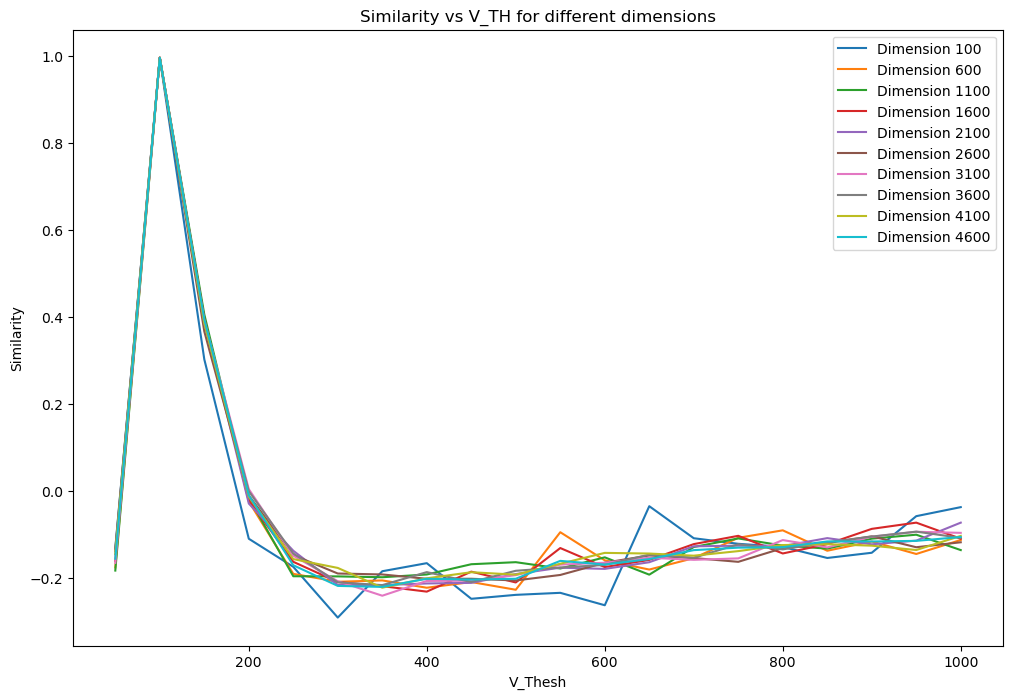

In [66]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for dim, sim_list in similarities.items():
    plt.plot(threshold_lst, sim_list, label=f'Dimension {dim}')
plt.xlabel('V_Thesh')
plt.ylabel('Similarity')
plt.title('Similarity vs V_TH for different dimensions')
plt.legend()

plt.savefig('foo-TIME_STEPS-1000-2.png')
plt.show()



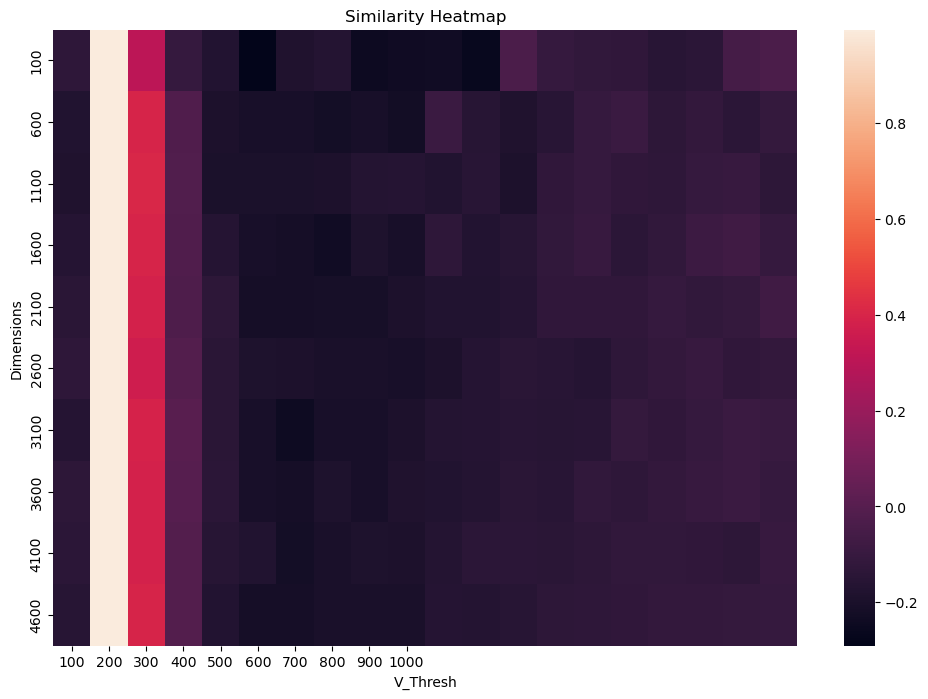

In [65]:
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, xticklabels=time_steps_range, yticklabels=dimensions)
plt.xlabel('V_Thresh')
plt.ylabel('Dimensions')
plt.title('Similarity Heatmap')

plt.savefig('foo2-TIME_STEPS-1000-2.png')
plt.show()

## Threshold vs Timesteps

In [32]:
threshold_lst = [ i for i in range(50,200,15) ]
time_steps_range = range(200, 1001, 100)

print(f'time_steps_range: {len(time_steps_range)}')

print(f'threshold_lst: {len(threshold_lst)}')

time_steps_range: 9
threshold_lst: 10


In [33]:
# Initialize a dictionary to store similarities
similarities = {}
rnd_vectors = []
snn_vectors = []

# Initialize a matrix to store similarities
similarity_matrix = np.zeros((len(time_steps_range), len(threshold_lst)))

In [34]:
# Iterate over dimensions and thresholds with a progress bar
dim = 1000
for i, ts in enumerate(tqdm(time_steps_range)):
    similarities[ts] = []
    for j, threshold in enumerate(tqdm(threshold_lst, leave=False)):
        # Generate a random normalized complex vector
        random_normalized_vector = generate_random_normalized_vector(dim)
        rnd_vectors.append(random_normalized_vector)

        lib.GlobalVars.global_threshold = threshold
        lib.GlobalVars.time_steps = ts
        
        # Convert to phase representation, encode, decode, and convert back
        encoder = lib.FHRR_Encoder(vec=random_normalized_vector)
        decoder = lib.FHRR_Decoder(dimension=random_normalized_vector.shape[0])
        encoder.spikes_out.connect(decoder.spikes_a_in)
        decoder.run(condition=RunSteps(num_steps=ts), run_cfg=Loihi1SimCfg())
        raw_rslt = decoder.get_decoded_value()
        rect_rslt = util.phase2complex_array(raw_rslt)

        snn_vectors.append(rect_rslt)
        # Compute similarity
        similarity = util.similarity(rect_rslt, random_normalized_vector)
        
        print(similarity)
        # print(rect_rslt[:10])
        # print(random_normalized_vector[:10])
        similarities[ts].append(similarity)

        similarity_matrix[i, j] = similarity

 10%|█         | 1/10 [00:03<00:33,  3.68s/it]

-0.12804483734855693



 20%|██        | 2/10 [00:05<00:19,  2.39s/it]

0.037531438740052984



 30%|███       | 3/10 [00:06<00:13,  1.95s/it]

0.7245450030328884



 40%|████      | 4/10 [00:08<00:10,  1.79s/it]

0.9905704538607303



 50%|█████     | 5/10 [00:09<00:08,  1.66s/it]

0.9144678817206874



 60%|██████    | 6/10 [00:11<00:06,  1.60s/it]

0.7085325702670787



 70%|███████   | 7/10 [00:12<00:04,  1.60s/it]

0.4801402083735756



 80%|████████  | 8/10 [00:14<00:03,  1.59s/it]

0.29633364529892203



 90%|█████████ | 9/10 [00:15<00:01,  1.55s/it]

0.1612989922281318



 11%|█         | 1/9 [00:17<02:17, 17.18s/it]  

0.04390572283320896



 10%|█         | 1/10 [00:01<00:13,  1.51s/it]

-0.136884918879158



 20%|██        | 2/10 [00:02<00:11,  1.48s/it]

-0.015783295336624852



 30%|███       | 3/10 [00:04<00:10,  1.48s/it]

0.7174859113833592



 40%|████      | 4/10 [00:05<00:08,  1.48s/it]

0.9930475988566054



 50%|█████     | 5/10 [00:07<00:07,  1.48s/it]

0.9225056636582356



 60%|██████    | 6/10 [00:10<00:08,  2.07s/it]

0.7207101163677211



 70%|███████   | 7/10 [00:12<00:06,  2.00s/it]

0.5082514444461326



 80%|████████  | 8/10 [00:14<00:03,  1.88s/it]

0.2919411888873043



 90%|█████████ | 9/10 [00:15<00:01,  1.76s/it]

0.1751117017566295



 22%|██▏       | 2/9 [00:34<02:00, 17.20s/it]  

0.07505722689912649



 10%|█         | 1/10 [00:01<00:13,  1.52s/it]

-0.12727349312438985



 20%|██        | 2/10 [00:03<00:12,  1.61s/it]

0.024424977657087298



 30%|███       | 3/10 [00:04<00:11,  1.57s/it]

0.7245081883552194



 40%|████      | 4/10 [00:06<00:09,  1.55s/it]

0.9933251486953266



 50%|█████     | 5/10 [00:07<00:08,  1.60s/it]

0.9200597342079831



 60%|██████    | 6/10 [00:09<00:06,  1.58s/it]

0.7292568449601986



 70%|███████   | 7/10 [00:11<00:04,  1.58s/it]

0.5163186550211308



 80%|████████  | 8/10 [00:12<00:03,  1.57s/it]

0.313638262829044



 90%|█████████ | 9/10 [00:14<00:01,  1.56s/it]

0.15551471659166588



 33%|███▎      | 3/9 [00:50<01:39, 16.56s/it]  

0.07171305142849266



 10%|█         | 1/10 [00:01<00:14,  1.56s/it]

-0.14797031559253745



 20%|██        | 2/10 [00:04<00:20,  2.56s/it]

-0.0029765200115865966



 30%|███       | 3/10 [00:06<00:14,  2.11s/it]

0.7375781054236834



 40%|████      | 4/10 [00:08<00:11,  1.93s/it]

0.9932871022733798



 50%|█████     | 5/10 [00:09<00:09,  1.83s/it]

0.9247724497685699



 60%|██████    | 6/10 [00:13<00:09,  2.39s/it]

0.7047425905955845



 70%|███████   | 7/10 [00:15<00:07,  2.47s/it]

0.49184445651777936



 80%|████████  | 8/10 [00:18<00:05,  2.61s/it]

0.30843494946371436



 90%|█████████ | 9/10 [00:20<00:02,  2.50s/it]

0.1634255858322318



 44%|████▍     | 4/9 [01:12<01:34, 18.92s/it]  

0.051254157733487196



 10%|█         | 1/10 [00:01<00:14,  1.66s/it]

-0.09900928307157578



 20%|██        | 2/10 [00:04<00:18,  2.31s/it]

0.028375927266401448



 30%|███       | 3/10 [00:06<00:14,  2.13s/it]

0.7112127007917668



 40%|████      | 4/10 [00:08<00:12,  2.06s/it]

0.993564534047493



 50%|█████     | 5/10 [00:10<00:10,  2.13s/it]

0.9220548438089866



 60%|██████    | 6/10 [00:12<00:08,  2.13s/it]

0.717666061181446



 70%|███████   | 7/10 [00:14<00:05,  1.98s/it]

0.5119711711035141



 80%|████████  | 8/10 [00:16<00:03,  1.90s/it]

0.3388770252302227



 90%|█████████ | 9/10 [00:17<00:01,  1.80s/it]

0.20137006221469084



 56%|█████▌    | 5/9 [01:32<01:16, 19.06s/it]  

0.06767251969031568



 10%|█         | 1/10 [00:01<00:16,  1.85s/it]

-0.14337651231909768



 20%|██        | 2/10 [00:03<00:16,  2.02s/it]

-0.018789428350928738



 30%|███       | 3/10 [00:05<00:13,  1.95s/it]

0.7209200790361272



 40%|████      | 4/10 [00:08<00:13,  2.18s/it]

0.9938790470240353



 50%|█████     | 5/10 [00:11<00:12,  2.48s/it]

0.920547430472046



 60%|██████    | 6/10 [00:13<00:09,  2.49s/it]

0.7241979560008329



 70%|███████   | 7/10 [00:17<00:08,  2.75s/it]

0.506842049908835



 80%|████████  | 8/10 [00:18<00:04,  2.44s/it]

0.33645047073900003



 90%|█████████ | 9/10 [00:20<00:02,  2.22s/it]

0.17935422607656454



 67%|██████▋   | 6/9 [01:55<01:01, 20.61s/it]  

0.07454315873036504



 10%|█         | 1/10 [00:02<00:20,  2.25s/it]

-0.1334537651804251



 20%|██        | 2/10 [00:04<00:18,  2.26s/it]

0.006255278325015435



 30%|███       | 3/10 [00:07<00:18,  2.65s/it]

0.7175741024711275



 40%|████      | 4/10 [00:11<00:18,  3.09s/it]

0.9936994593395619



 50%|█████     | 5/10 [00:13<00:13,  2.69s/it]

0.9233363041389627



 60%|██████    | 6/10 [00:15<00:10,  2.52s/it]

0.7228179330920739



 70%|███████   | 7/10 [00:17<00:07,  2.34s/it]

0.5116623366181072



 80%|████████  | 8/10 [00:19<00:04,  2.37s/it]

0.3200025108838346



 90%|█████████ | 9/10 [00:22<00:02,  2.54s/it]

0.15712559945061866



 78%|███████▊  | 7/9 [02:21<00:44, 22.21s/it]  

0.08405823039219702



 10%|█         | 1/10 [00:02<00:20,  2.24s/it]

-0.17421473475971871



 20%|██        | 2/10 [00:03<00:15,  1.92s/it]

0.04712057674728736



 30%|███       | 3/10 [00:05<00:12,  1.82s/it]

0.7198838161284545



 40%|████      | 4/10 [00:07<00:12,  2.02s/it]

0.993827550760313



 50%|█████     | 5/10 [00:10<00:10,  2.17s/it]

0.9156446176659693



 60%|██████    | 6/10 [00:12<00:08,  2.19s/it]

0.7227574427866792



 70%|███████   | 7/10 [00:15<00:06,  2.25s/it]

0.5038301752099629



 80%|████████  | 8/10 [00:17<00:04,  2.36s/it]

0.3465433638710989



 90%|█████████ | 9/10 [00:20<00:02,  2.42s/it]

0.18808954025888502



 89%|████████▉ | 8/9 [02:43<00:22, 22.23s/it]  

0.09122006200454498



 10%|█         | 1/10 [00:02<00:19,  2.21s/it]

-0.1493262277177148



 20%|██        | 2/10 [00:04<00:18,  2.33s/it]

-0.011822164481418823



 30%|███       | 3/10 [00:06<00:15,  2.24s/it]

0.7095930834339655



 40%|████      | 4/10 [00:08<00:12,  2.07s/it]

0.9934352436832298



 50%|█████     | 5/10 [00:10<00:09,  1.94s/it]

0.9210245985119621



 60%|██████    | 6/10 [00:12<00:07,  1.88s/it]

0.7163022509672843



 70%|███████   | 7/10 [00:13<00:05,  1.83s/it]

0.5357353330386523



 80%|████████  | 8/10 [00:15<00:03,  1.83s/it]

0.3330136773863531



 90%|█████████ | 9/10 [00:17<00:01,  1.77s/it]

0.20343243428943653



100%|██████████| 9/9 [03:02<00:00, 20.27s/it]  

0.07157304544218147


In [37]:
print(similarities)

{200: [-0.12804483734855693, 0.037531438740052984, 0.7245450030328884, 0.9905704538607303, 0.9144678817206874, 0.7085325702670787, 0.4801402083735756, 0.29633364529892203, 0.1612989922281318, 0.04390572283320896], 300: [-0.136884918879158, -0.015783295336624852, 0.7174859113833592, 0.9930475988566054, 0.9225056636582356, 0.7207101163677211, 0.5082514444461326, 0.2919411888873043, 0.1751117017566295, 0.07505722689912649], 400: [-0.12727349312438985, 0.024424977657087298, 0.7245081883552194, 0.9933251486953266, 0.9200597342079831, 0.7292568449601986, 0.5163186550211308, 0.313638262829044, 0.15551471659166588, 0.07171305142849266], 500: [-0.14797031559253745, -0.0029765200115865966, 0.7375781054236834, 0.9932871022733798, 0.9247724497685699, 0.7047425905955845, 0.49184445651777936, 0.30843494946371436, 0.1634255858322318, 0.051254157733487196], 600: [-0.09900928307157578, 0.028375927266401448, 0.7112127007917668, 0.993564534047493, 0.9220548438089866, 0.717666061181446, 0.5119711711035141

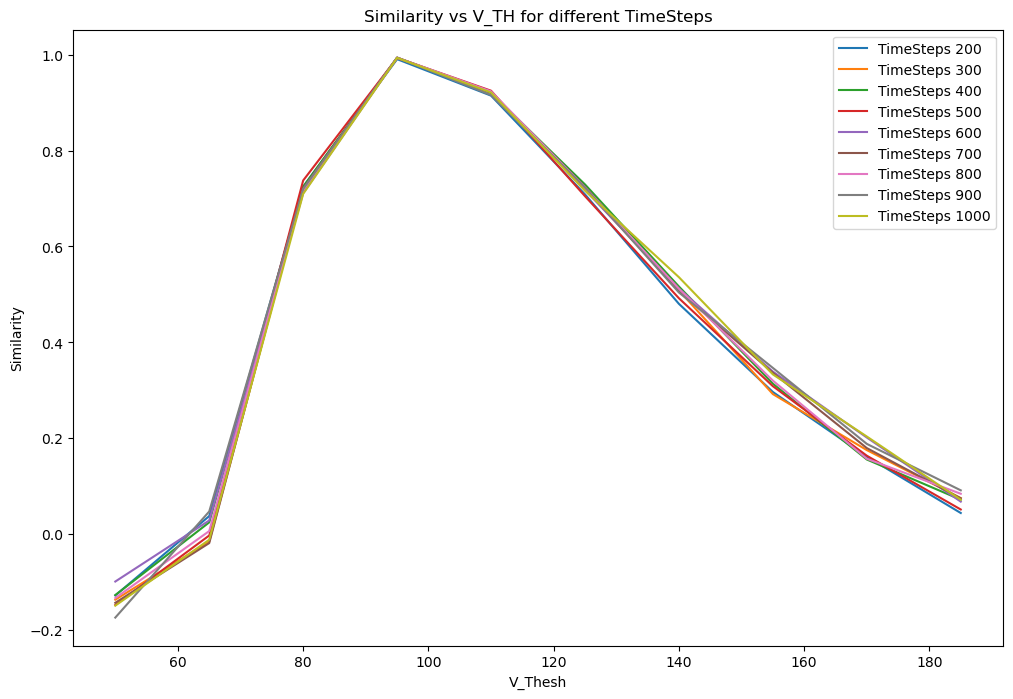

In [38]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for ts, sim_list in similarities.items():
    plt.plot(threshold_lst, sim_list, label=f'TimeSteps {ts}')
plt.xlabel('V_Thesh')
plt.ylabel('Similarity')
plt.title('Similarity vs V_TH for different TimeSteps')
plt.legend()

plt.savefig('foo-dim-1000.png')
plt.show()



## Error percentage and resolution

In [73]:
errors = np.linspace(0.02, 0.20, 5)
# errors = [0.02]

degrees = 100
resolution = math.radians(degrees)

# print(errors * 100)
print(resolution)

1.7453292519943295


In [74]:
# random_normalized_vector = np.array([-0.43835684-0.17897514j, -0.41302636-0.23150871j,
#        -0.08678763-0.51561787j, -0.48029071+0.18454118j,
#        -0.11589898-0.00794145j])

In [75]:
# Iterate over dimensions and thresholds with a progress bar
dim = 1000
random_dist_count = 1
similarities = {}

voltages = []
voltages_dec = []
# for i, error in enumerate(tqdm(errors)):
for i, error in enumerate((errors)):
    similarities[error] = []
    for j in range(random_dist_count):
        # Generate a random normalized complex vector
        random_normalized_vector = generate_random_normalized_vector(dim)
        # random_normalized_vector = random_normalized_vector
        # rnd_vectors.append(random_normalized_vector)

        lib.set_params_auto( error, resolution )
        # lib.GlobalVars.time_steps = 600

        print(lib.GlobalVars.global_threshold, lib.GlobalVars.time_steps)

        # print(util.convert_rad2deg(util.complexarr2phase(random_normalized_vector)[:10], True))
        
        # Convert to phase representation, encode, decode, and convert back
        encoder = lib.FHRR_Encoder(vec=random_normalized_vector)
        encoder.vth = lib.GlobalVars.global_threshold
        decoder = lib.FHRR_Decoder(dimension=random_normalized_vector.shape[0])
        decoder.vth = lib.GlobalVars.global_threshold
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        decoder.run(condition=RunSteps(num_steps=lib.GlobalVars.time_steps), run_cfg=Loihi1SimCfg())
        # for i in range( int(lib.GlobalVars.time_steps) ):
        #     decoder.run(condition=RunSteps(num_steps=1), run_cfg=Loihi1SimCfg())
        #     voltages.append(encoder.get_v())
        #     voltages_dec.append(decoder.get_v())
            # print(decoder.a_period)
        
        raw_rslt = decoder.get_decoded_value()
        # print(f'raw_rslt: {raw_rslt}')
        rect_rslt = util.phase2complex_array(raw_rslt)

        # print(raw_rslt[:10])
        # print(util.convert_rad2deg(raw_rslt[:10], True))
        # print(util.convert_rad2deg(util.complexarr2phase(raw_rslt)[:10], True))

        # snn_vectors.append(rect_rslt)
        # Compute similarity
        similarity = util.similarity(rect_rslt, random_normalized_vector)
        
        print(similarity)
        print("")
        # print(rect_rslt[:10])
        # print(random_normalized_vector[:10])
        similarities[error].append(similarity)

308 177.0
0.8545847098757184

90 52.0
0.8616288657274742

51 30.0
0.847733096793753

34 20.0
0.8360347065303695

25 15.0
0.7863942073046485



In [76]:
similarities

{0.02: [0.8545847098757184],
 0.065: [0.8616288657274742],
 0.11000000000000001: [0.847733096793753],
 0.155: [0.8360347065303695],
 0.2: [0.7863942073046485]}

In [77]:
# np_voltages = np.array(voltages)
# np_voltages_dec = np.array(voltages_dec)

In [42]:
# plt.plot(np_voltages_dec[:,0])

In [78]:
keys6, values6 = similarities.keys(), similarities.values()

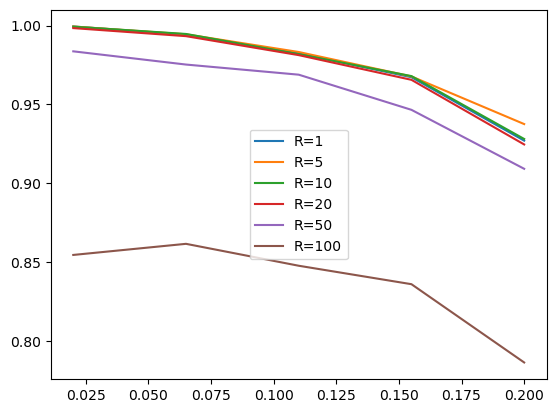

In [79]:
plt.plot(keys, [np.mean(v) for v in values], label="R=1")
plt.plot(keys2, [np.mean(v) for v in values2], label="R=5")
plt.plot(keys3, [np.mean(v) for v in values3], label="R=10")
plt.plot(keys4, [np.mean(v) for v in values4], label="R=20")
plt.plot(keys5, [np.mean(v) for v in values5], label="R=50")
plt.plot(keys6, [np.mean(v) for v in values6], label="R=100")
plt.legend()
plt.show()

## Loop it for different R and Error

In [23]:
# errors = np.linspace(0.01, 0.50, 10)
errors = np.array([1, 5, 10, 15, 20, 30, 40, 50]) / 100
# errors = [0.02]

# degrees = list(range(1, 32, 3))
degrees = np.array( [10, 20, 50, 75, 90, 120, 150, 180] )
resolution =  [math.radians(degree) for degree in degrees]

print(errors * 100)
print(degrees)

[ 1.  5. 10. 15. 20. 30. 40. 50.]
[ 10  20  50  75  90 120 150 180]


In [24]:
# Iterate over dimensions and thresholds with a progress bar
dim = 1000
random_dist_count = 5
similarities = {}

for res in resolution:
    similarities[res] = {}
    for i, error in enumerate((errors)):
        similarities[res][error] = []
        for j in range(random_dist_count):
            # Generate a random normalized complex vector
            random_normalized_vector = generate_random_normalized_vector(dim)
    
            lib.set_params_auto( error, res )
    
            print(lib.GlobalVars.global_threshold, lib.GlobalVars.time_steps)
            
            # Convert to phase representation, encode, decode, and convert back
            encoder = lib.FHRR_Encoder(vec=random_normalized_vector)
            encoder.vth = lib.GlobalVars.global_threshold
            decoder = lib.FHRR_Decoder(dimension=random_normalized_vector.shape[0])
            decoder.vth = lib.GlobalVars.global_threshold
            encoder.spikes_out.connect(decoder.spikes_a_in)
            
            decoder.run(condition=RunSteps(num_steps=lib.GlobalVars.time_steps), run_cfg=Loihi1SimCfg())
            
            raw_rslt = decoder.get_decoded_value()
            rect_rslt = util.phase2complex_array(raw_rslt)
            # Compute similarity
            similarity = util.similarity(rect_rslt, random_normalized_vector)
            
            print(similarity)
            print("")

            decoder.stop()
            
            similarities[res][error].append(similarity)

622 3564.0
0.9996497316990456

622 3564.0
0.9997587010657549

622 3564.0
0.9997748424171354

622 3564.0
0.9997058862976391

622 3564.0
0.9997077881418167

119 682.0
0.9962508643940677

119 682.0
0.9964670318230262

119 682.0
0.9960635779447232

119 682.0
0.9963808106840274

119 682.0
0.9964393631216192

57 327.0
0.9839021380892208

57 327.0
0.9854911642829759

57 327.0
0.9852885325584739

57 327.0
0.9848001476355589

57 327.0
0.9843233997076698

36 207.0
0.9687473191535267

36 207.0
0.9677585305060845

36 207.0
0.9683296483355548

36 207.0
0.9693988418995604

36 207.0
0.9720309253614952

25 144.0
0.9290075992947777

25 144.0
0.9255272460283083

25 144.0
0.9321877872445405

25 144.0
0.9295747490465857

25 144.0
0.9233082642188886

15 86.0
0.8860606751378145

15 86.0
0.8861979662899819

15 86.0
0.8787898425871856

15 86.0
0.8876144402514347

15 86.0
0.8895453474184035

9 52.0
0.7749409402297579

9 52.0
0.7726704473066835

9 52.0
0.7846072297945225

9 52.0
0.7843560846463988

9 52.0
0.781

In [25]:
# similarities

In [26]:
mean_reconstruction_sim = {}
for res in resolution:
    mean_reconstruction_sim[res] = {}
    for error in errors:
        mean_reconstruction_sim[res][error] = np.mean( similarities[res][error] )

In [27]:
# mean_reconstruction_sim

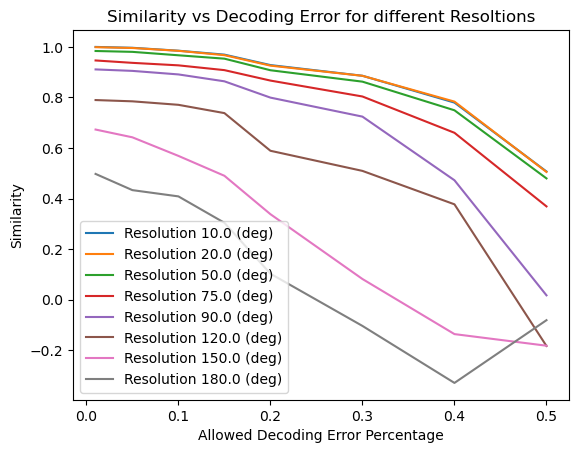

In [28]:
# plt.figure(figsize=(12, 8))
for res, err_data in mean_reconstruction_sim.items():
    # print(res, err_data)
    plt.plot(errors, err_data.values(), label=f'Resolution {round(math.degrees(res),2)} (deg)')
plt.xlabel('Allowed Decoding Error Percentage')
plt.ylabel('Similarity')
plt.title('Similarity vs Decoding Error for different Resoltions')
plt.legend()

plt.savefig('Similarity vs Decoding Error for different Resoltions dim1000-3.png')
plt.show()

## Online decoding experiment for fixed resolution

In [59]:
# errors = np.linspace(0.01, 0.50, 10)
errors = np.array([1, 5, 10, 15, 20, 30, 40, 50]) / 100
# errors = [0.02]

# degrees = list(range(1, 32, 3))
degrees = np.array( [20] )
resolution =  [math.radians(degree) for degree in degrees]

print(errors * 100)
print(degrees)

[ 1.  5. 10. 15. 20. 30. 40. 50.]
[20]


In [60]:
# Iterate over dimensions and thresholds with a progress bar
dim = 1000
random_dist_count = 1
similarities = {}

for error in errors:
    similarities[error] = {}
    for res in resolution:
        similarities[error][res] = []
        # for j in range(random_dist_count):
            # Generate a random normalized complex vector
        random_normalized_vector = generate_random_normalized_vector(dim)

        lib.set_params_auto( error, res )

        print(lib.GlobalVars.global_threshold, lib.GlobalVars.time_steps)
        
        # Convert to phase representation, encode, decode, and convert back
        encoder = lib.FHRR_Encoder(vec=random_normalized_vector)
        encoder.vth = lib.GlobalVars.global_threshold
        decoder = lib.FHRR_Decoder(dimension=random_normalized_vector.shape[0])
        decoder.vth = lib.GlobalVars.global_threshold
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        for k in range(math.ceil(lib.GlobalVars.time_steps)):
            decoder.run(condition=RunSteps(num_steps=1), run_cfg=Loihi1SimCfg())
            
            raw_rslt  = decoder.get_decoded_value()
            rect_rslt = util.phase2complex_array(raw_rslt)
            # Compute similarity
            similarity = util.similarity(rect_rslt, random_normalized_vector)

            similarities[error][res].append(similarity)
        
        print(error)
        # print("")

        decoder.stop()
            
            

622 1782.0
0.01
119 341.0
0.05
57 164.0
0.1
36 104.0
0.15
25 72.0
0.2
15 43.0
0.3
9 26.0
0.4
6 18.0
0.5


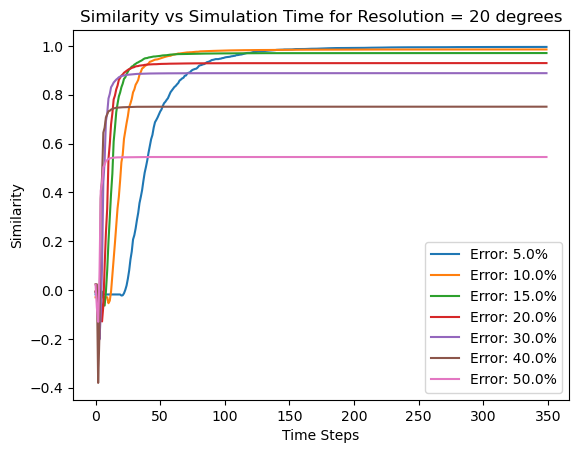

In [61]:
# plt.figure(figsize=(12, 8))
for error in errors:
    # print(res, err_data)
    if error == 0.01:
        continue
    plt.plot(similarities[error][resolution[0]], label=f'Error: {error*100}%')
plt.xlabel('Time Steps')
plt.ylabel('Similarity')
plt.title('Similarity vs Simulation Time for Resolution = 20 degrees')
plt.legend()

plt.savefig('Similarity vs Simulation Time for Resolution 20 degrees dim1000-2.png')
plt.show()

# plt.plot(similarities[errors[0]][resolution[0]])

## Dimension vs Similarity for different 

In [1]:
## RANDOM TESTS

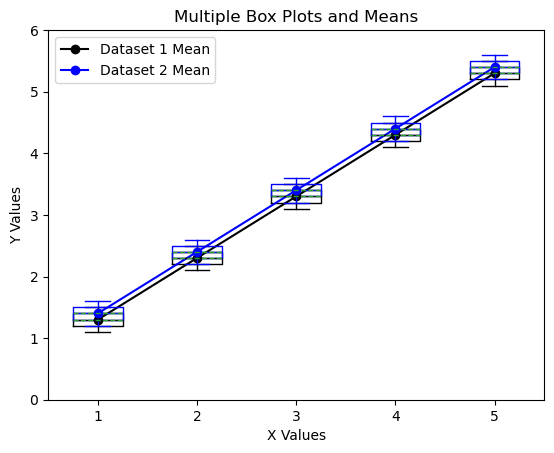

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multiple_box_plots(data_sets, x_title="X Values", y_title="Y Values", title="", show_box_plots=True, y_limits=None):
    """
    Plots multiple sets of customized black and white box plots for each x value with multiple y values,
    indicates outliers, and adds a line graph connecting the means of y values for each dataset.

    Parameters:
    data_sets (list of dicts): List of dictionaries, each containing 'x_values', 'y_values', and 'title' keys.
                               Each dictionary represents a dataset.
    x_title (str): Label for the x-axis.
    y_title (str): Label for the y-axis.
    title (str): Overall title of the plot.
    show_box_plots (bool): If True, display box plots. If False, only plot the means.
    y_limits (tuple): Optional parameter to set the y-axis limits. Should be a tuple (y_min, y_max).
    """
    fig, ax = plt.subplots()

    colors = ['black', 'blue', 'green', 'red', 'purple', 'orange']  # Add more colors as needed

    for idx, data_set in enumerate(data_sets):
        x_values = data_set['x_values']
        y_values = data_set['y_values']
        dataset_title = data_set.get('title', f'Dataset {idx + 1}')
        color = colors[idx % len(colors)]
        
        if show_box_plots:
            # Create the box plot
            boxplot = ax.boxplot(y_values, positions=x_values, patch_artist=False, showmeans=True, meanline=True,
                                 flierprops=dict(marker='o', color=color, markersize=5), boxprops=dict(color=color),
                                 whiskerprops=dict(color=color), capprops=dict(color=color), medianprops=dict(color=color))
        
        # Calculate means of y values
        means = [np.mean(y) for y in y_values]
        
        # Plot the line graph connecting the means
        ax.plot(x_values, means, color=color, linestyle='-', marker='o', label=f'{dataset_title} Mean')

    # Set the x-axis labels
    ax.set_xticks(x_values)
    ax.set_xticklabels([str(x) for x in x_values])

    # Set labels and title
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)

    # Set y-axis limits if provided
    if y_limits is not None:
        ax.set_ylim(y_limits)

    # Show the legend
    ax.legend()

    # Show the plot
    plt.show()

# Example usage:
data_sets = [
    {
        'x_values': [1, 2, 3, 4, 5],
        'y_values': [
            [1.1, 1.2, 1.3, 1.4, 1.5],
            [2.1, 2.2, 2.3, 2.4, 2.5],
            [3.1, 3.2, 3.3, 3.4, 3.5],
            [4.1, 4.2, 4.3, 4.4, 4.5],
            [5.1, 5.2, 5.3, 5.4, 5.5]
        ],
        'title': 'Dataset 1'
    },
    {
        'x_values': [1, 2, 3, 4, 5],
        'y_values': [
            [1.2, 1.3, 1.4, 1.5, 1.6],
            [2.2, 2.3, 2.4, 2.5, 2.6],
            [3.2, 3.3, 3.4, 3.5, 3.6],
            [4.2, 4.3, 4.4, 4.5, 4.6],
            [5.2, 5.3, 5.4, 5.5, 5.6]
        ],
        'title': 'Dataset 2'
    }
]

plot_multiple_box_plots(data_sets, title="Multiple Box Plots and Means", show_box_plots=True, y_limits=(0, 6))
